# 제15장 - 금융에서의 딥러닝

- 금융 시계열은 변동이 심하고 복잡한 것으로 알려져 있어 모델링이 매우 어려운 과제이나,
- 딥러닝 접근법은 기본 데이터의 분포에 대한 가정을 하지 않고 노이즈에 대해  강건할 수 있기 때문에 이러한 작업에 특히 적합합니다.
    - 단변량과 다변량 시계열 모두를 포함하는 시계열 데이터 작업에도 자연스럽게 적합
- 쉽게 쓸수 있는 fastai부터 Google, Amazon, Meta에서 각 개발한 시계열 딥러닝 모델을 학습해봅시다

## 15.1 `fastai`의 tabular 활용

1. 개요
> fastai의 Tabular Learner는 테이블 형태의 데이터를 딥러닝 모델에 쉽게 구현할 수 있게 해주는 도구입니다. 이 가이드에서는 신용카드 연체 예측을 위한 구현 과정을 다룹니다.

### 장점
- 자동화된 전처리: 결측치 처리, 범주형 변수 인코딩, 
- 정규화를 자동으로 수행
- 엔티티 임베딩: 범주형 변수를 위한 자동 임베딩 생성
- 간편한 API: 복잡한 딥러닝 모델을 쉽게 구현 가능
- 최적화된 성능: 경험적으로 검증된 최적의 접근 방식 적용

1. 라이브러리 가져오기:

In [6]:
from fastai.tabular.all import *
from sklearn.model_selection import train_test_split
from chapter_15_utils import performance_evaluation_report_fastai
import pandas as pd

2. CSV 파일에서 데이터세트를 로드합니다.

In [7]:
df = pd.read_csv("credit_card_default.csv", 
                 na_values="")
df.head()

limit_bal     sex   education marriage   age        payment_status_sep  \
0      20000  Female  University  Married  24.0  Payment delayed 2 months   
1     120000  Female  University   Single  26.0                Payed duly   
2      90000  Female  University   Single  34.0                   Unknown   
3      50000  Female  University  Married  37.0                   Unknown   
4      50000    Male  University  Married  57.0                Payed duly   

         payment_status_aug payment_status_jul payment_status_jun  \
0  Payment delayed 2 months         Payed duly         Payed duly   
1  Payment delayed 2 months            Unknown            Unknown   
2                   Unknown            Unknown            Unknown   
3                   Unknown            Unknown            Unknown   
4                   Unknown         Payed duly            Unknown   

  payment_status_may  ... bill_statement_jun  bill_statement_may  \
0            Unknown  ...                  0                   0   
1            Unknown  ...               3272                3455   
2            Unknown  ...              14331               14948   
3            Unknown  ...              28314               28959   
4            Unknown  ...              20940               19146   

   bill_statement_apr  previous_payment_sep  previous_payment_aug  \
0                   0                     0                   689   
1                3261                     0                  1000   
2               15549                  1518                  1500   
3               29547                  2000                  2019   
4               19131                  2000                 36681   

   previous_payment_jul  previous_payment_jun  previous_payment_may  \
0                     0                     0                     0   
1                  1000                  1000                     0   
2                  1000                  1000                  1000   
3                  1200                  1100                  1069   
4                 10000                  9000                   689   

   previous_payment_apr  default_payment_next_month  
0                     0                           1  
1                  2000                           1  
2                  5000                           0  
3                  1000                           0  
4                   679                           0  

[5 rows x 24 columns]

In [8]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_bal                   30000 non-null  int64  
 1   sex                         29850 non-null  object 
 2   education                   29850 non-null  object 
 3   marriage                    29850 non-null  object 
 4   age                         29850 non-null  float64
 5   payment_status_sep          30000 non-null  object 
 6   payment_status_aug          30000 non-null  object 
 7   payment_status_jul          30000 non-null  object 
 8   payment_status_jun          30000 non-null  object 
 9   payment_status_may          30000 non-null  object 
 10  payment_status_apr          30000 non-null  object 
 11  bill_statement_sep          30000 non-null  int64  
 12  bill_statement_aug          30000 non-null  int64  
 13  bill_statement_jul          300

None

3. 타겟, 범주형/숫자형 특징 목록 및 전처리 단계를 정의합니다.

In [9]:
TARGET = "default_payment_next_month"

cat_features = list(df.select_dtypes("object").columns) # 범주형 특성
num_features = list(df.select_dtypes("number").columns) # 수치형 특성
num_features.remove(TARGET) # 타겟 특성 제거

preprocessing = [FillMissing, Categorify, Normalize] # fastai의 쉬운 도구 활용 : 결측치, 범주형 인코딩, 정규화 파이프라인 

4. 훈련 및 검증 세트를 만드는 데 사용되는 분할기를 정의합니다.

In [10]:
display(help(FillMissing))
display(help(range_of))

Help on class FillMissing in module fastai.tabular.core:

class FillMissing(TabularProc)
 |  FillMissing(self, fill_strategy=<function FillStrategy.median at 0x7fa28594d120>, add_col=True, fill_vals=None)
 |  
 |  Fill the missing values in continuous columns.
 |  
 |  Method resolution order:
 |      FillMissing
 |      TabularProc
 |      fastcore.transform.InplaceTransform
 |      fastcore.transform.Transform
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, fill_strategy=<function FillStrategy.median at 0x7fa28594d120>, add_col=True, fill_vals=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  decodes = 
 |  encodes = (object,object) -> encodes
 |  
 |  setups = (object,object) -> setups
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  __signature__ = <Signature (self, fill_strategy=<function FillSt...t 0...
 |  
 |  -------------------

None

Help on function range_of in module fastcore.basics:

range_of(a, b=None, step=None)
    All indices of collection `a`, if `a` is a collection, otherwise `range`



None

In [11]:
splits = RandomSplitter(valid_pct=0.2, seed=42)(range_of(df)) # 훈련, 검증, 테스트 데이터 분할 
splits

((#24000) [np.int64(27362),np.int64(16258),np.int64(19716),np.int64(9066),np.int64(1258),np.int64(23042),np.int64(18939),np.int64(24443),np.int64(4328),np.int64(4976)...],
 (#6000) [np.int64(7542),np.int64(10109),np.int64(19114),np.int64(5209),np.int64(9270),np.int64(15555),np.int64(12970),np.int64(10207),np.int64(13694),np.int64(1745)...])

5. `TabularPandas` 데이터세트를 생성합니다.

In [12]:
import warnings
warnings.filterwarnings('ignore')

tabular_df = TabularPandas(
    df, 
    procs=preprocessing,
    cat_names=cat_features,
    cont_names=num_features,
    y_names=TARGET,
    y_block=CategoryBlock(),
    splits=splits
)

PREVIEW_COLS = ["sex", "education", "marriage", 
                "payment_status_sep", "age_na", "limit_bal",
                "age", "bill_statement_sep"]
tabular_df.xs.iloc[:5][PREVIEW_COLS]

sex  education  marriage  payment_status_sep  age_na  limit_bal  \
27362    2          4         3                  10       1  -0.290227   
16258    1          4         1                  10       1  -0.443899   
19716    1          1         3                   2       1   2.014862   
9066     1          2         3                   3       1  -0.674408   
1258     2          1         3                   1       1   0.324464   

            age  bill_statement_sep  
27362 -0.919919           -0.399403  
16258 -0.266960            0.731335  
19716 -0.158134           -0.493564  
9066  -0.919919           -0.646319  
1258  -0.266960           -0.692228

In [13]:
tabular_df.xs.columns

Index(['sex', 'education', 'marriage', 'payment_status_sep',
       'payment_status_aug', 'payment_status_jul', 'payment_status_jun',
       'payment_status_may', 'payment_status_apr', 'age_na', 'limit_bal',
       'age', 'bill_statement_sep', 'bill_statement_aug', 'bill_statement_jul',
       'bill_statement_jun', 'bill_statement_may', 'bill_statement_apr',
       'previous_payment_sep', 'previous_payment_aug', 'previous_payment_jul',
       'previous_payment_jun', 'previous_payment_may', 'previous_payment_apr'],
      dtype='object')

6. `TabularPandas` 데이터세트에서 `DataLoaders` 객체를 정의합니다.

In [14]:
data_loader = tabular_df.dataloaders(bs=64, drop_last=True)
data_loader.show_batch()

- 성능 개선을 위한 팁
    - 레이어 크기 조정: 모델의 복잡도 조절
    - 가중치 감쇠 (Weight Decay): 과적합 방지
    - 드롭아웃 적용: 모델의 일반화 성능 향상
    - 학습률 조정: 더 나은 수렴을 위한 학습률 최적화
    - 배치 크기 조정: 메모리 사용량과 학습 속도 최적화

In [15]:
recall = Recall()
precision = Precision()
learn = tabular_learner(
    data_loader, 
    [500, 200], 
    metrics=[accuracy, recall, precision]
)
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3, 3)
    (1): Embedding(5, 4)
    (2): Embedding(4, 3)
    (3-6): 4 x Embedding(11, 6)
    (7-8): 2 x Embedding(10, 6)
    (9): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=63, out_features=500, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=500, out_features=200, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=200, out_features=2, bias=True)
    )
  )
)

In [16]:
# 다음 스니펫을 사용하여 임베딩을 알아낼 수도 있습니다.
emb_szs = get_emb_sz(tabular_df)
emb_szs

[(3, 3),
 (5, 4),
 (4, 3),
 (11, 6),
 (11, 6),
 (11, 6),
 (11, 6),
 (10, 6),
 (10, 6),
 (3, 3)]

`Embedding(11, 6)`은 11개의 입력 값과 6개의 출력 잠재 특징을 사용하여 범주형 임베딩이 생성되었음을 의미합니다.

8. 제안된 학습률을 찾으세요:

SuggestedLRs(valley=0.0030199517495930195)

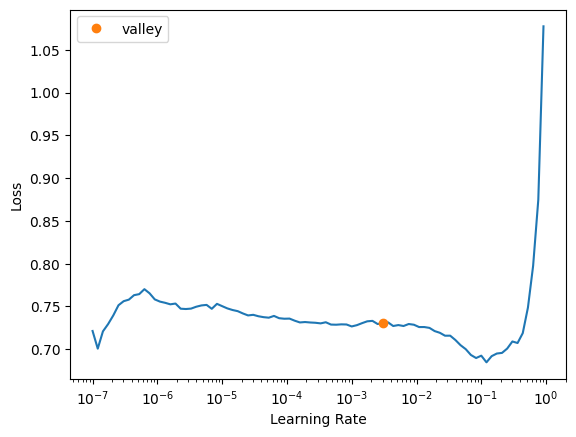

In [17]:
learn.lr_find()

# plt.savefig("이미지/피규어_15_3")

9. Tabular 학습자 교육:

In [18]:
learn.fit(n_epoch=25, lr=1e-3, wd=0.2)

10. 손실을 차트로 그려보기

NameError: name 'sns' is not defined

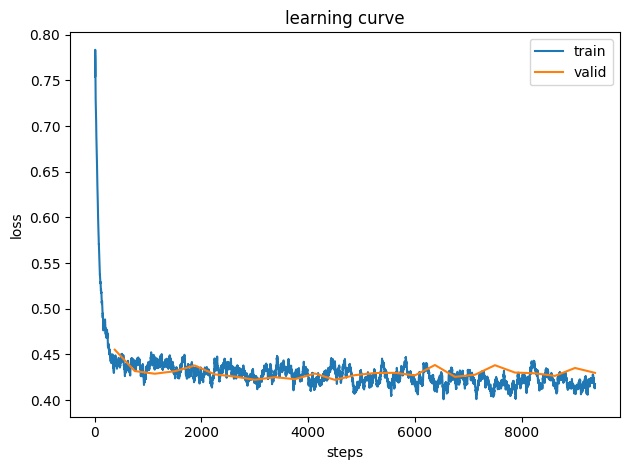

In [20]:
learn.recorder.plot_loss()

plt.tight_layout()
sns.despine()
# plt.savefig("이미지/피규어_15_5")

11. `DataLoaders` 검증을 정의합니다.

In [21]:
valid_data_loader = learn.dls.test_dl(df.loc[list(splits[1])])
valid_data_loader.show_batch()

12. 검증 세트의 성능 평가:

In [22]:
learn.validate(dl=valid_data_loader)

(#4) [0.4297766387462616,0.8253333568572998,0.3841940532081377,0.6529255319148937]

13. 검증 세트에 대한 예측을 얻으세요:

In [23]:
preds, y_true = learn.get_preds(dl=valid_data_loader)

In [49]:
preds

tensor([[0.7861, 0.2139],
        [0.9289, 0.0711],
        [0.8109, 0.1891],
        ...,
        [0.9286, 0.0714],
        [0.9058, 0.0942],
        [0.8740, 0.1260]])

In [50]:
preds.argmax(dim=-1)

tensor([0, 0, 0,  ..., 0, 0, 0])

In [51]:
y_true

tensor([[1],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]], dtype=torch.int8)

14. 성과 평가 지표를 검사합니다.

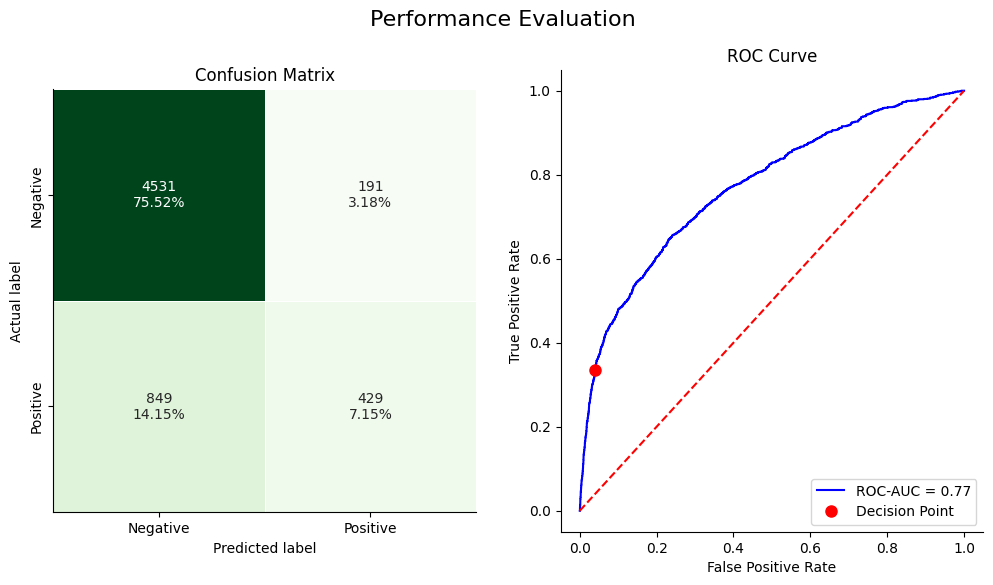

In [52]:
perf = performance_evaluation_report_fastai(
    learn, valid_data_loader, show_plot=True
)

sns.despine()
# plt.savefig("이미지/피규어_15_6", dpi=200)

In [53]:
perf

{'accuracy': 0.8266666666666667,
 'precision': np.float64(0.6919354838709677),
 'recall': np.float64(0.33568075117370894),
 'specificity': np.float64(0.9595510376958916),
 'f1_score': np.float64(0.4520547945205479),
 'cohens_kappa': np.float64(0.3634783460229638),
 'matthews_corr_coeff': np.float64(0.397104267004595),
 'roc_auc': np.float64(0.7720413023578906),
 'pr_auc': np.float64(0.5364075281646393),
 'average_precision': np.float64(0.5369577254011916)}

### 추가 고려사항

- 데이터 불균형이 있는 경우 가중치 부여나 샘플링 기법 고려
- 특성 중요도 분석을 통한 모델 해석
- 교차 검증을 통한 더 견고한 성능 평가
- 하이퍼파라미터 최적화를 통한 성능 개선

### 추가 예시


훈련/검증 분할을 생성할 때 더 구체적으로 지정할 수도 있습니다. 아래에서 `sklearn` 함수를 사용하고 인덱스를 `IndexSplitter` 클래스에 전달합니다.

In [54]:
from sklearn.model_selection import StratifiedKFold

X = df.copy()
y = X.pop(TARGET)

strat_split = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_ind, test_ind = next(strat_split.split(X, y))
ind_splits = IndexSplitter(valid_idx=list(test_ind))(range_of(df))

tabular_df = TabularPandas(
    df, 
    procs=preprocessing,
    cat_names=cat_features,
    cont_names=num_features,
    y_names=TARGET,
    y_block=CategoryBlock(),
    splits=ind_splits
)

/usr/local/lib/python3.10/dist-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)


예시 결과를 살펴볼 수 있습니다.

In [55]:
learn.show_results()

또는 단일 행에 대한 예측을 생성합니다.

In [56]:
row, clas, probs = learn.predict(df.iloc[0])

/usr/local/lib/python3.10/dist-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)


In [ ]:
row

In [ ]:
clas

In [ ]:
probs

## 15.2 Google의 TabNet 탐색
> TabNet은 구글에서 개발한 테이블 데이터를 위한 딥러닝 모델로, 다음과 같은 특징을 가집니다:

- 특성 선택을 위한 sequential attention 메커니즘
- 인스턴스별 특성 해석 가능
- 최소한의 전처리 요구

### 방법은...

1. 라이브러리 가져오기:

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import recall_score

from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.metrics import Metric
import torch

import pandas as pd
import numpy as np

2. CSV 파일에서 데이터세트를 로드합니다.

In [25]:
df = pd.read_csv("credit_card_default.csv", 
                 na_values="")
df.head()

limit_bal     sex   education marriage   age        payment_status_sep  \
0      20000  Female  University  Married  24.0  Payment delayed 2 months   
1     120000  Female  University   Single  26.0                Payed duly   
2      90000  Female  University   Single  34.0                   Unknown   
3      50000  Female  University  Married  37.0                   Unknown   
4      50000    Male  University  Married  57.0                Payed duly   

         payment_status_aug payment_status_jul payment_status_jun  \
0  Payment delayed 2 months         Payed duly         Payed duly   
1  Payment delayed 2 months            Unknown            Unknown   
2                   Unknown            Unknown            Unknown   
3                   Unknown            Unknown            Unknown   
4                   Unknown         Payed duly            Unknown   

  payment_status_may  ... bill_statement_jun  bill_statement_may  \
0            Unknown  ...                  0                   0   
1            Unknown  ...               3272                3455   
2            Unknown  ...              14331               14948   
3            Unknown  ...              28314               28959   
4            Unknown  ...              20940               19146   

   bill_statement_apr  previous_payment_sep  previous_payment_aug  \
0                   0                     0                   689   
1                3261                     0                  1000   
2               15549                  1518                  1500   
3               29547                  2000                  2019   
4               19131                  2000                 36681   

   previous_payment_jul  previous_payment_jun  previous_payment_may  \
0                     0                     0                     0   
1                  1000                  1000                     0   
2                  1000                  1000                  1000   
3                  1200                  1100                  1069   
4                 10000                  9000                   689   

   previous_payment_apr  default_payment_next_month  
0                     0                           1  
1                  2000                           1  
2                  5000                           0  
3                  1000                           0  
4                   679                           0  

[5 rows x 24 columns]

3. 타겟과 피처를 분리하고 숫자형/범주형 피처를 사용하여 목록을 만듭니다.

In [34]:
X = df.copy()
y = X.pop("default_payment_next_month")

cat_features = list(X.select_dtypes("object").columns)
num_features = list(X.select_dtypes("number").columns)

In [35]:
# 알림으로서, 누락될 수 있는 값은 다음과 같습니다.
X.isna().any()

limit_bal               False
sex                      True
education                True
marriage                 True
age                      True
payment_status_sep      False
payment_status_aug      False
payment_status_jul      False
payment_status_jun      False
payment_status_may      False
payment_status_apr      False
bill_statement_sep      False
bill_statement_aug      False
bill_statement_jul      False
bill_statement_jun      False
bill_statement_may      False
bill_statement_apr      False
previous_payment_sep    False
previous_payment_aug    False
previous_payment_jul    False
previous_payment_jun    False
previous_payment_may    False
previous_payment_apr    False
dtype: bool

4. 범주형 피처에서 누락된 값을 입력하고 `LabelEncoder`를 사용하여 인코딩한 다음 피처당 고유 범주 수를 저장합니다.


In [36]:
cat_dims = {}

for col in cat_features:
    label_encoder = LabelEncoder()
    X[col] = X[col].fillna("Missing")
    X[col] = label_encoder.fit_transform(X[col].values)
    cat_dims[col] = len(label_encoder.classes_)

cat_dims

{'sex': 3,
 'education': 5,
 'marriage': 4,
 'payment_status_sep': 10,
 'payment_status_aug': 10,
 'payment_status_jul': 10,
 'payment_status_jun': 10,
 'payment_status_may': 9,
 'payment_status_apr': 9}

5. 70-15-15 비율을 사용하여 훈련/유효/테스트 분할을 만듭니다.

In [37]:
# 초기 분할 생성 - 훈련 및 임시
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.3, 
    stratify=y, 
    random_state=42
)

# 유효한 세트와 테스트 세트를 만듭니다.
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, 
    test_size=0.5, 
    stratify=y_temp, 
    random_state=42
)

In [38]:
print("Percentage of data in each set ----")
print(f"훈련: {100 * len(X_train) / len(X):.2f}%")
print(f"유효: {100 * len(X_valid) / len(X):.2f}%")
print(f"테스트: {100 * len(X_test) / len(X):.2f}%")
print("")
print("Class distribution in each set ----")
print(f"훈련: {y_train.value_counts(normalize=True).values}")
print(f"유효: {y_valid.value_counts(normalize=True).values}")
print(f"테스트: {y_test.value_counts(normalize=True).values}")

Percentage of data in each set ----
훈련: 70.00%
유효: 15.00%
테스트: 15.00%

Class distribution in each set ----
훈련: [0.77880952 0.22119048]
유효: [0.77888889 0.22111111]
테스트: [0.77866667 0.22133333]


6. 모든 세트의 숫자형 특징에서 누락된 값을 입력합니다.

In [39]:
for col in num_features:
    imp_mean = X_train[col].mean()
    X_train[col] = X_train[col].fillna(imp_mean)
    X_valid[col] = X_valid[col].fillna(imp_mean)
    X_test[col] = X_test[col].fillna(imp_mean)

7. 범주적 특징의 인덱스와 고유 범주의 수를 포함하는 목록을 준비합니다.

In [40]:
features = X.columns.to_list()
cat_ind = [features.index(feat) for feat in cat_features] 
cat_dims = list(cat_dims.values())
cat_ind

[1, 2, 3, 5, 6, 7, 8, 9, 10]

8. 사용자 정의 리콜 메트릭 정의:

In [41]:

class Recall(Metric):
    def __init__(self):
        self._name = "recall"
        self._maximize = True

    def __call__(self, y_true, y_score):
        y_pred = np.argmax(y_score, axis=1)
        return recall_score(y_true, y_pred)

9. TabNet의 매개변수를 정의하고 분류기를 인스턴스화합니다.

In [43]:
tabnet_params = {
    "cat_idxs": cat_ind,
    "cat_dims": cat_dims,
    "optimizer_fn": torch.optim.Adam,
    "optimizer_params": dict(lr=2e-2),
    "scheduler_params": {
        "step_size":20,
        "gamma":0.9
    },
    "scheduler_fn": torch.optim.lr_scheduler.StepLR,
    "mask_type": "sparsemax",
    "seed": 42,
}

tabnet = TabNetClassifier(**tabnet_params)

10. TabNet 분류기를 훈련합니다.

In [44]:
X_train.values

array([[1.600e+05, 0.000e+00, 4.000e+00, ..., 6.000e+03, 6.000e+03,
        5.500e+03],
       [1.000e+05, 0.000e+00, 0.000e+00, ..., 0.000e+00, 2.846e+03,
        1.936e+03],
       [8.000e+04, 1.000e+00, 0.000e+00, ..., 1.600e+03, 1.600e+03,
        1.600e+03],
       ...,
       [1.200e+05, 0.000e+00, 0.000e+00, ..., 2.000e+03, 1.200e+03,
        1.000e+03],
       [3.600e+05, 1.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [3.000e+05, 1.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00]])

In [45]:
tabnet.fit(
    X_train=X_train.values, 
    y_train=y_train.values,
    eval_set=[
        (X_train.values, y_train.values), 
        (X_valid.values, y_valid.values)
    ],
    eval_name=["train", "valid"],
    eval_metric=["auc", Recall],
    max_epochs=200, 
    patience=20,
    batch_size=1024, 
    virtual_batch_size=128,
    weights=1,
)

epoch 0  | loss: 0.69793 | train_auc: 0.63484 | train_recall: 0.56642 | valid_auc: 0.63706 | valid_recall: 0.57286 |  0:00:02s
epoch 1  | loss: 0.63042 | train_auc: 0.70037 | train_recall: 0.49451 | valid_auc: 0.69167 | valid_recall: 0.45829 |  0:00:05s
epoch 2  | loss: 0.60566 | train_auc: 0.72843 | train_recall: 0.5225  | valid_auc: 0.72568 | valid_recall: 0.50251 |  0:00:07s
epoch 3  | loss: 0.60066 | train_auc: 0.74596 | train_recall: 0.5225  | valid_auc: 0.73792 | valid_recall: 0.51156 |  0:00:09s
epoch 4  | loss: 0.5891  | train_auc: 0.74982 | train_recall: 0.52659 | valid_auc: 0.7497  | valid_recall: 0.52161 |  0:00:12s
epoch 5  | loss: 0.58311 | train_auc: 0.75542 | train_recall: 0.53541 | valid_auc: 0.75357 | valid_recall: 0.52362 |  0:00:15s
epoch 6  | loss: 0.58245 | train_auc: 0.76061 | train_recall: 0.54596 | valid_auc: 0.75539 | valid_recall: 0.53166 |  0:00:17s
epoch 7  | loss: 0.57981 | train_auc: 0.76472 | train_recall: 0.5253  | valid_auc: 0.76045 | valid_recall: 0.50

11. 기록 DataFrame을 준비하고 에포크에 따른 점수를 플로팅합니다.

In [70]:
history_df = pd.DataFrame(tabnet.history.history)
history_df.head(10)

loss    lr  train_auc  train_recall  valid_auc  valid_recall
0  0.697926  0.02   0.634842      0.566416   0.637057      0.572864
1  0.630415  0.02   0.700366      0.494510   0.691674      0.458291
2  0.605658  0.02   0.728428      0.522497   0.725675      0.502513
3  0.600658  0.02   0.745959      0.522497   0.737924      0.511558
4  0.589102  0.02   0.749816      0.526588   0.749696      0.521608
5  0.583108  0.02   0.755417      0.535414   0.753570      0.523618
6  0.582454  0.02   0.760606      0.545963   0.755388      0.531658
7  0.579806  0.02   0.764717      0.525296   0.760446      0.504523
8  0.575452  0.02   0.760442      0.511948   0.749793      0.490452
9  0.575167  0.02   0.767376      0.538644   0.762856      0.516583

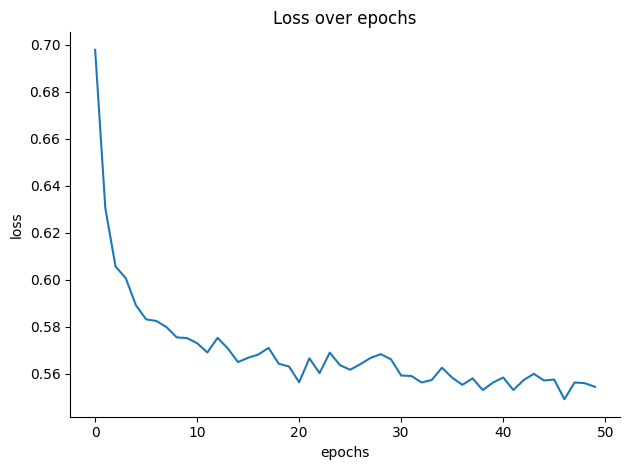

In [71]:
history_df["loss"].plot(
    title="Loss over epochs",
    xlabel="epochs",
    ylabel="loss"
)

plt.tight_layout()
sns.despine()
# plt.savefig("이미지/피규어_15_7")

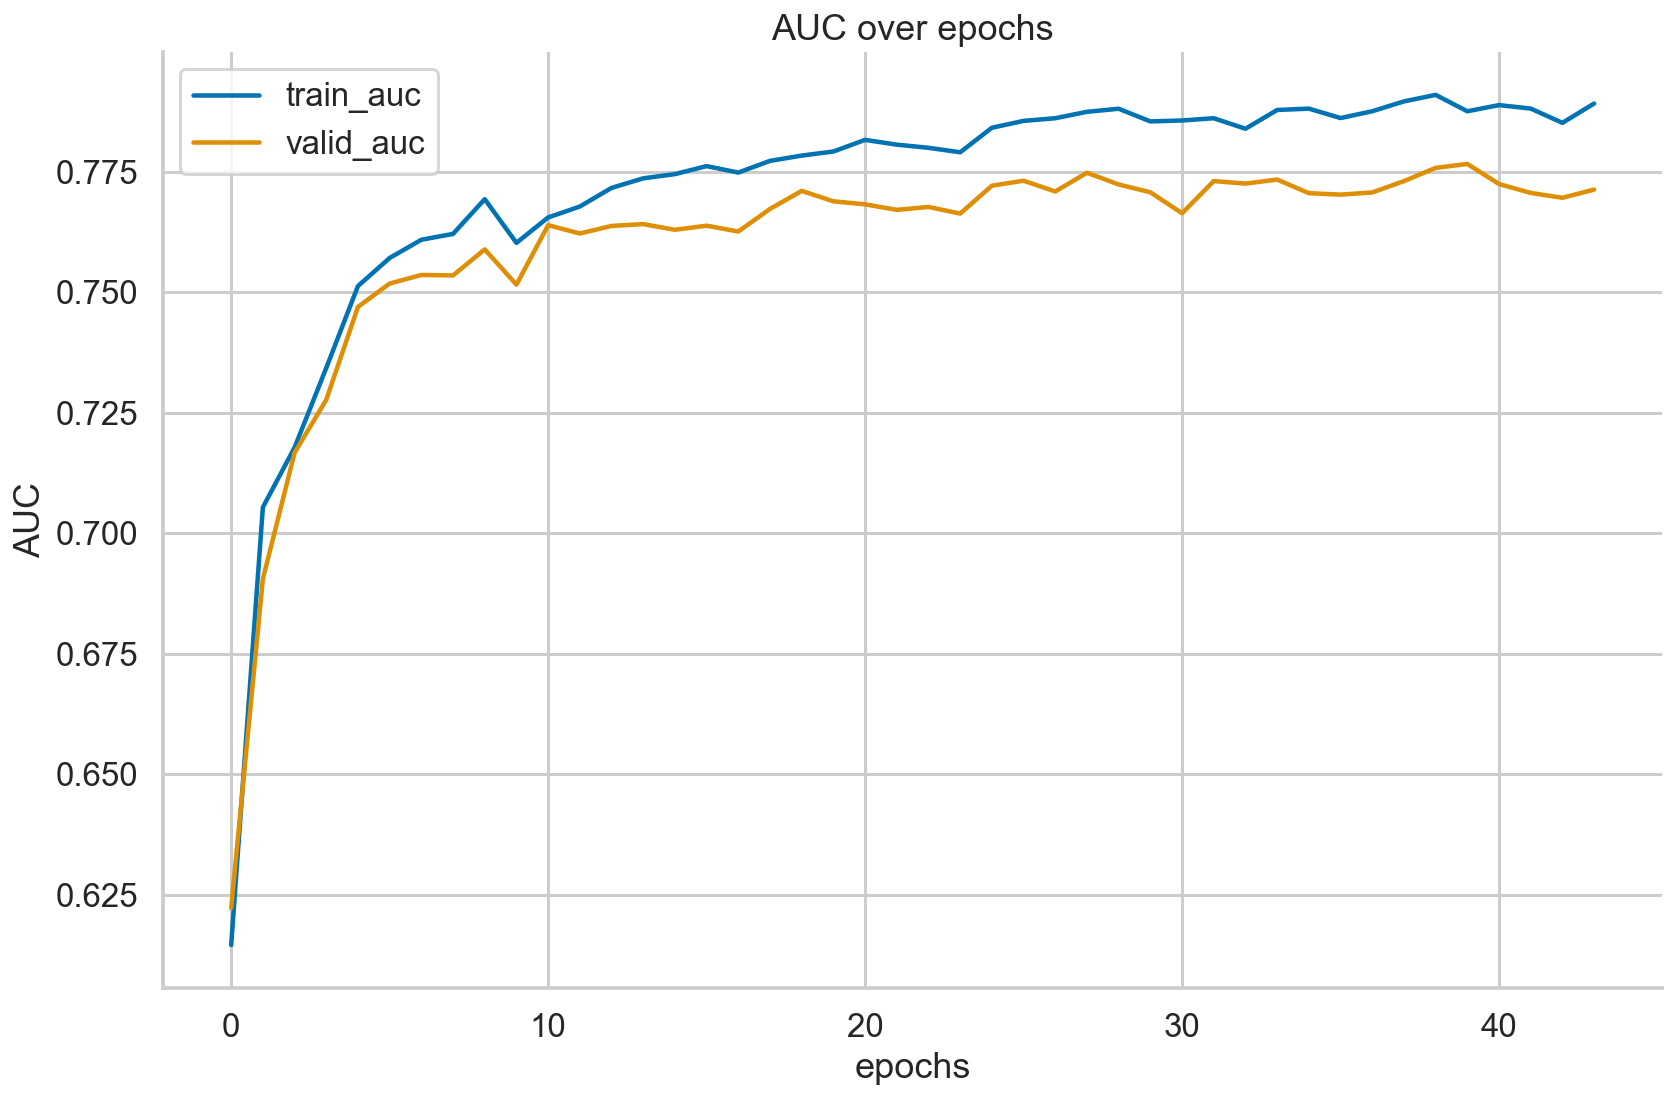

In [18]:
(
    history_df[["train_auc", "valid_auc"]]
    .plot(title="AUC over epochs",
          xlabel="epochs",
          ylabel="AUC")
);

plt.tight_layout()
sns.despine()

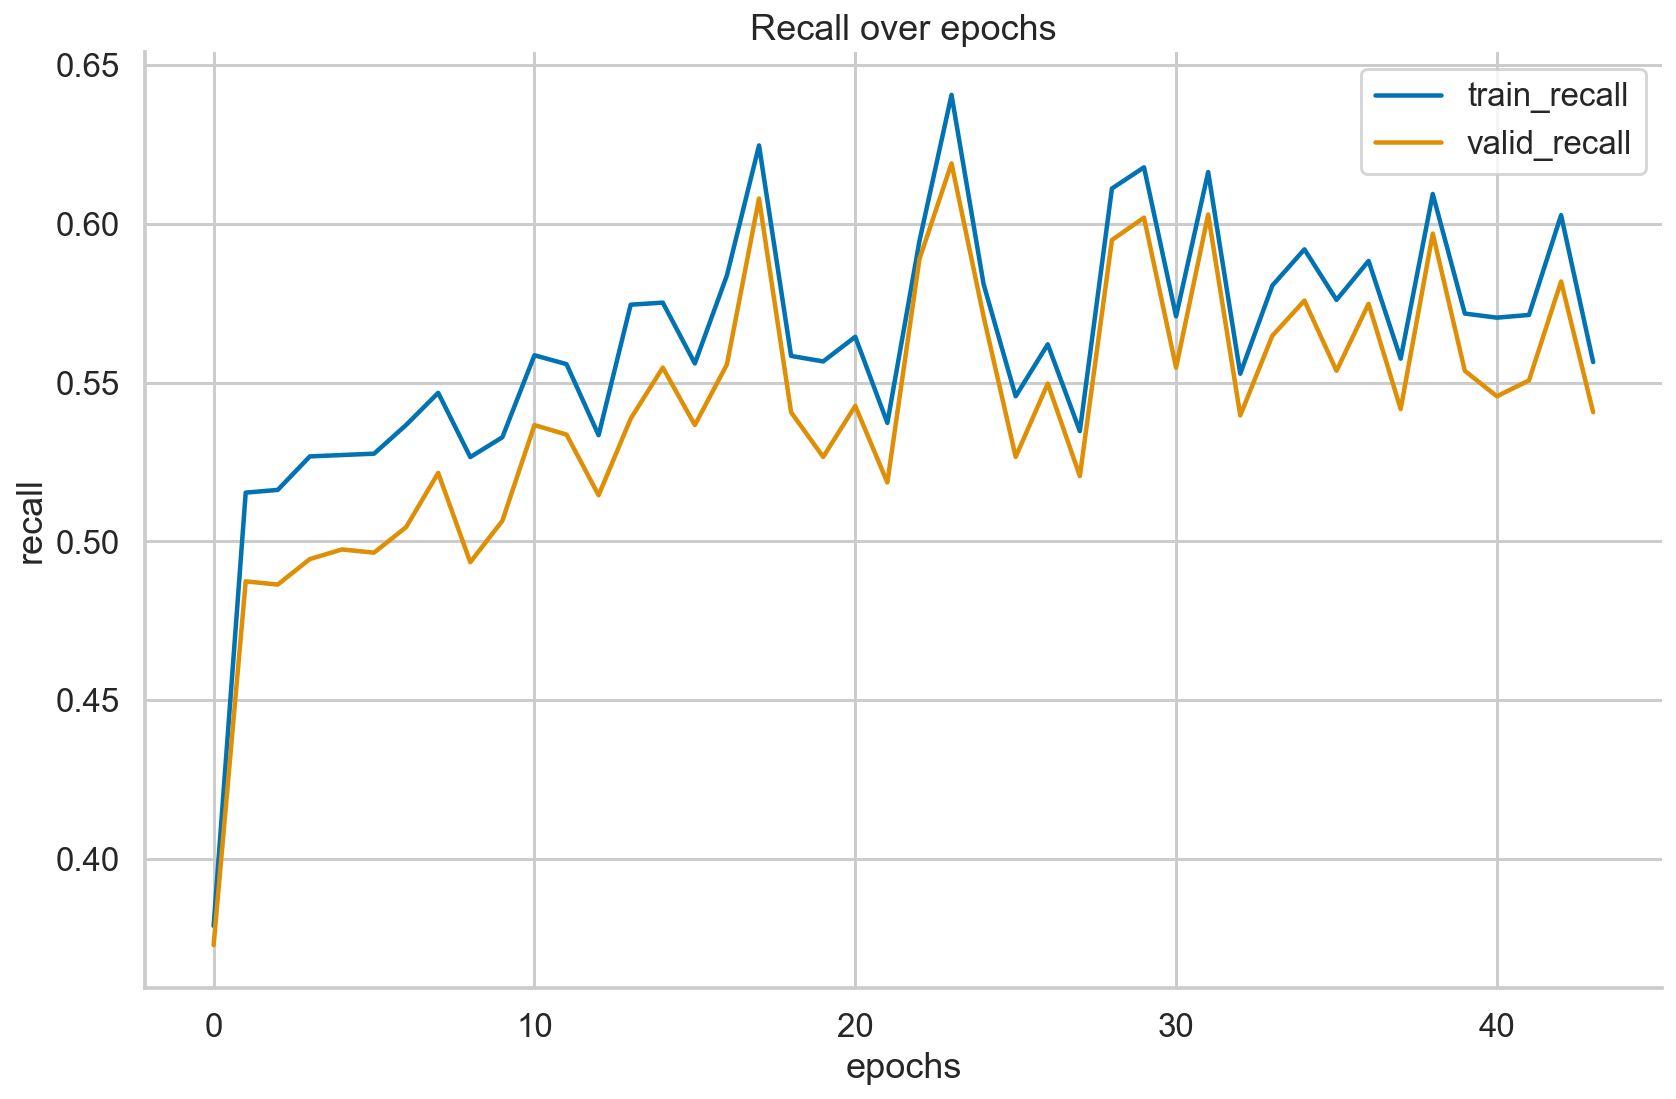

In [19]:
(
    history_df[["train_recall", "valid_recall"]]
    .plot(title="Recall over epochs",
          xlabel="epochs",
          ylabel="recall")
);

plt.tight_layout()
sns.despine()
# plt.savefig("이미지/피규어_15_8")

12. 테스트 세트에 대한 예측을 만들고 성능을 평가합니다.

In [20]:
y_pred = tabnet.predict(X_test.values)

print(f"최고 검증 점수: {tabnet.best_cost:.4f}")
print(f"테스트 세트 점수: {recall_score(y_test, y_pred):.4f}")

Best validation score: 0.6191
Test set score: 0.6275


13. 글로벌 기능 중요도 추출 및 플롯:

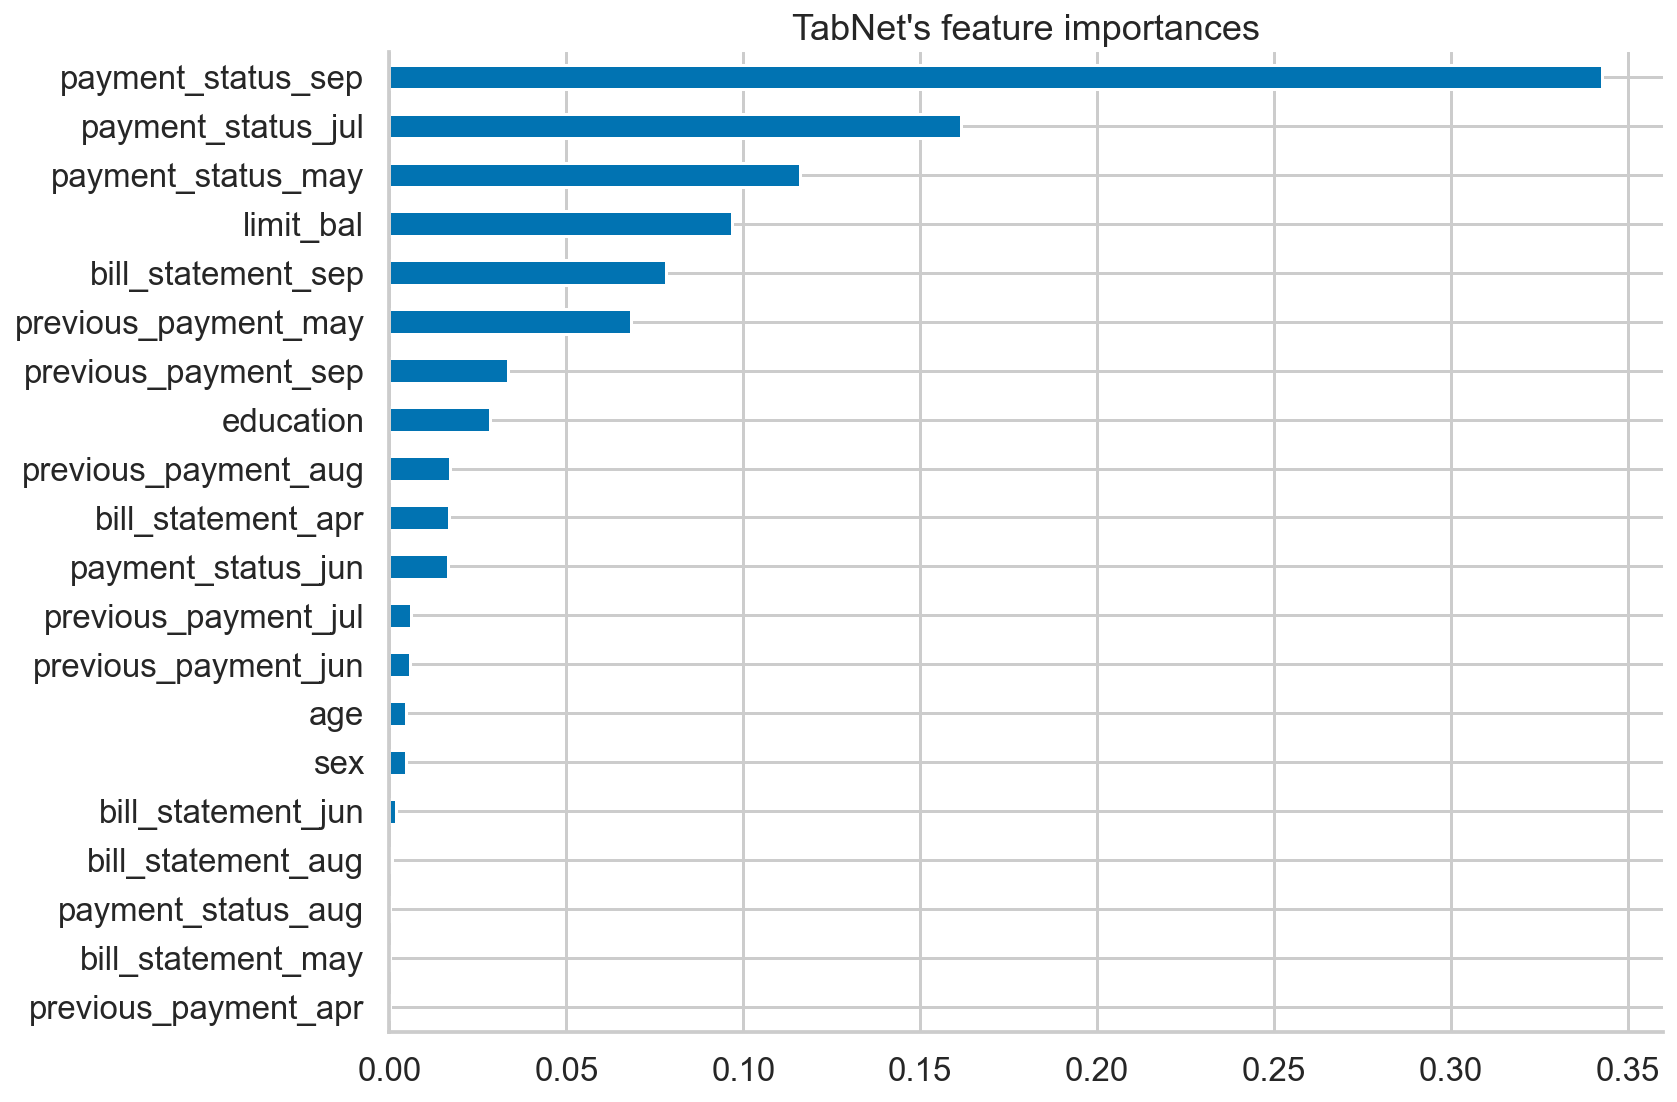

In [21]:
tabnet_feat_imp = pd.Series(tabnet.feature_importances_, 
                            index=X_train.columns)
(
    tabnet_feat_imp
    .nlargest(20)
    .sort_values()
    .plot(kind="barh",
          title="TabNet's feature importances")
)

plt.tight_layout()
sns.despine()
# plt.savefig("이미지/피규어_15_9")

In [41]:
np.sum(tabnet.feature_importances_)

1.0

### 더 많은 것이 있습니다

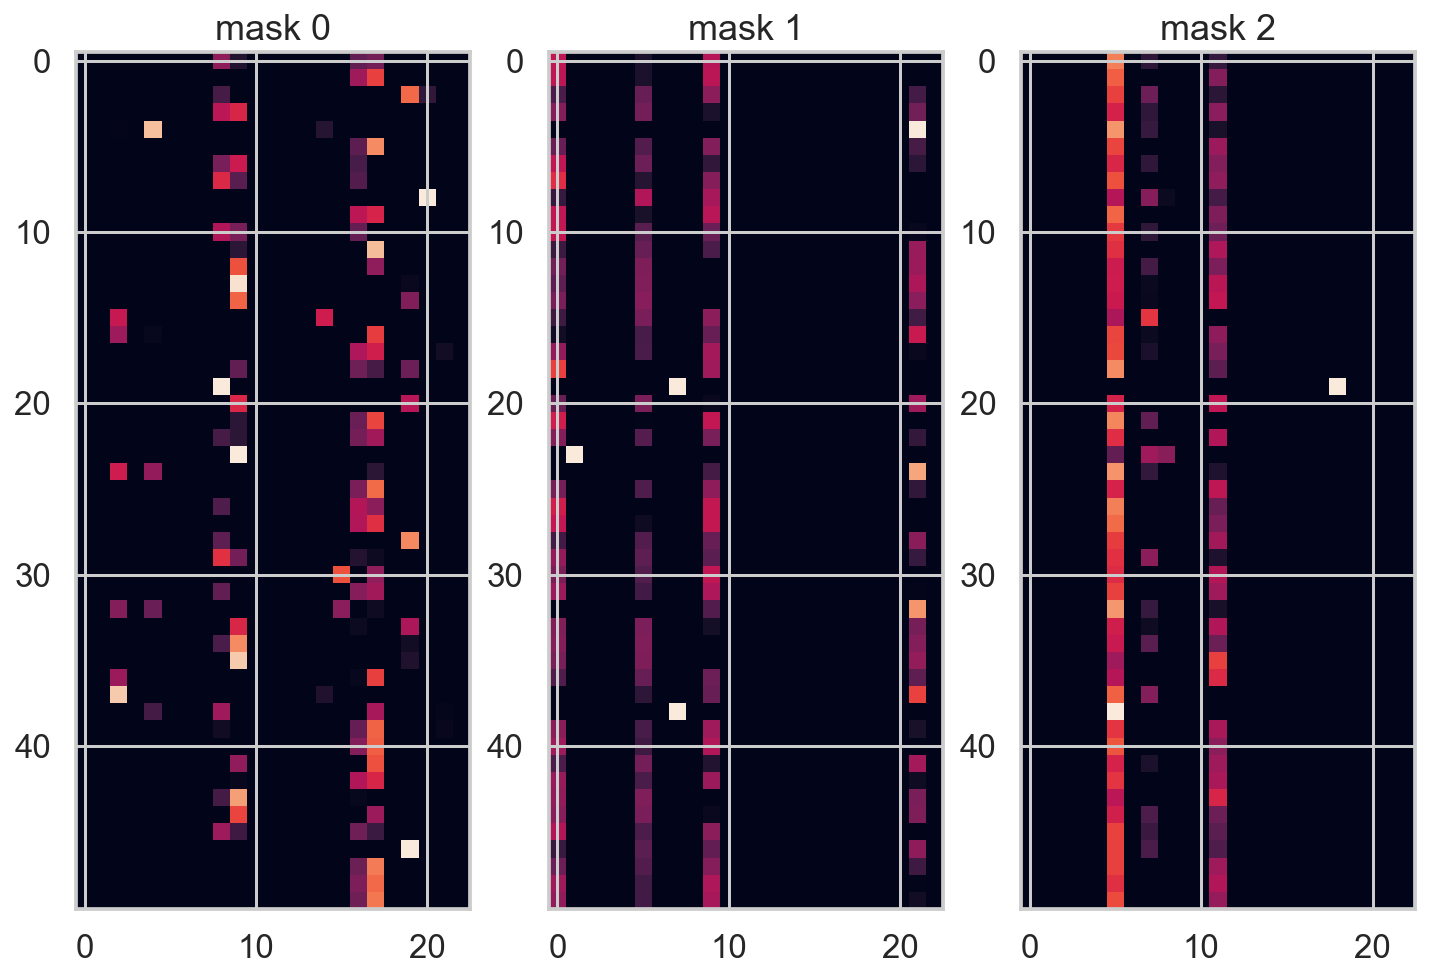

In [38]:
explain_matrix, masks = tabnet.explain(X_test.values)

fig, axs = plt.subplots(1, 3)

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

In [39]:
explain_matrix.shape

(4500, 23)

In [40]:
X_test.shape

(4500, 23)

In [68]:
# tabnet 모델 저장
MODEL_PATH = "models/tabnet_model"
saved_filepath = tabnet.save_model(MODEL_PATH)

# 기본 매개변수와 부하 상태 사전 가중치를 사용하여 새 모델을 정의합니다.
loaded_tabnet = TabNetClassifier()
loaded_tabnet.load_model(saved_filepath)

Successfully saved model at models/tabnet_model.zip
Device used : cpu
Device used : cpu


### TabNet의 주요 장점

- 해석 가능성
    - 전역 특성 중요도
    - 인스턴스별 특성 선택
    - 마스크 시각화를 통한 의사결정 과정 이해
<br>

- 효율적인 학습
    - 희소 특성 (sparse feature)선택
    - 최소한의 전처리 요구
    - GPU 가속 지원
<br>

- 유연성

- 다양한 손실 함수 지원
- 커스텀 메트릭 사용 가능
- 범주형/수치형 변수 통합 처리



9. 성능 최적화 팁

- 하이퍼파라미터 튜닝

    - n_d, n_a: 특성 변환 차원 조정
    - n_steps: 결정 단계 수 조정
    - gamma: 특성 선택의 희소성 조정


- 배치 크기 최적화

    - batch_size와 virtual_batch_size 조정
    - GPU 메모리 효율적 사용


- 학습 안정화

    - 적절한 learning rate 선택
    - 스케줄러 파라미터 조정
    - 조기 종료 기준 설정



TabNet은 특히 대규모 테이블 데이터에서 효과적이며, 모델의 해석 가능성이 중요한 금융 도메인에서 유용하게 활용될 수 있습니다.

## 15.3 Amazon의 DeepAR을 사용한 시계열 예측
> DeepAR은 Amazon에서 개발한 확률적 시계열 예측 모델로 다음과 같은 특징이 있습니다:

- 여러 관련 시계열을 동시에 학습
- 확률적 예측 제공 (예측 구간 포함)
- 계절성과 관련 특성을 자동으로 학습
- 새로운 시계열에 대한 cold-start 문제 해결

### 방법은...

1. 라이브러리 가져오기:

In [46]:
import warnings
warnings.filterwarnings("ignore")

In [47]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import yfinance as yf
from random import sample, seed

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_forecasting import DeepAR, TimeSeriesDataSet

2. SP500 구성 요소의 티커를 다운로드하고 목록에서 무작위 티커 100개를 샘플링합니다.

In [48]:
df = pd.read_html(
    "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
)
df = df[0]

seed(44)
sampled_tickers = sample(df["Symbol"].to_list(), 100)

3. 선택한 주식의 과거 주가를 다운로드하세요:

In [49]:
raw_df = yf.download(sampled_tickers,
                     start="2020-01-01",
                     end="2021-12-31")

[*********************100%***********************]  100 of 100 completed

1 Failed download:
['VLTO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2020-01-01 -> 2021-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1577854800, endDate = 1640926800")')


4. 조정된 종가를 유지하고 값이 누락된 주식을 제거합니다.

In [50]:
df = raw_df["Adj Close"]
df = df.loc[:, ~df.isna().any()]
selected_tickers = df.columns
df.head()

Ticker             ACN         ADI        ADSK        AEE        AES  \
Date                                                                   
2020-01-02  195.263565  110.377739  187.830002  66.394997  17.096724   
2020-01-03  194.938354  108.434692  184.949997  66.421158  16.900408   
2020-01-06  193.665405  107.160736  187.119995  66.482292  17.096724   
2020-01-07  189.484192  109.598701  187.500000  66.726746  17.156477   
2020-01-08  189.855881  110.588570  189.949997  66.613251  17.122332   

Ticker           AMZN         AON         ARE        ATO          AZO  ...  \
Date                                                                   ...   
2020-01-02  94.900497  200.509750  136.561737  97.846344  1189.739990  ...   
2020-01-03  93.748497  199.722275  137.339752  98.493469  1187.979980  ...   
2020-01-06  95.143997  200.298508  137.673157  98.360481  1165.709961  ...   
2020-01-07  95.343002  198.598633  133.167557  99.016464  1145.380005  ...   
2020-01-08  94.598503  199.414978  134.937332  98.165466  1147.489990  ...   

Ticker            TAP         TDY        TEL         VMC        WAB  \
Date                                                                  
2020-01-02  48.128525  357.489990  88.929123  136.589951  78.508293   
2020-01-03  47.984695  360.049988  87.878677  135.996552  77.907013   
2020-01-06  49.108353  358.630005  87.270500  135.757355  77.586960   
2020-01-07  48.982502  361.089996  89.076546  134.226044  77.557854   
2020-01-08  49.458935  361.549988  89.998001  135.297913  76.229195   

Ticker            WEC          WM        WMB         WY        XEL  
Date                                                                
2020-01-02  77.226120  105.488960  17.642878  24.533123  54.000290  
2020-01-03  77.711586  106.514091  17.717983  24.574860  54.259979  
2020-01-06  77.771217  107.068230  17.950823  24.524773  54.182083  
2020-01-07  77.473106  107.142128  17.950823  24.366180  54.069542  
2020-01-08  77.575333  107.206779  17.672922  24.457996  54.017609  

[5 rows x 98 columns]

5. 데이터 형식을 wide에서 long으로 변환하고 시간 인덱스를 추가합니다.

In [52]:
df = df.reset_index(drop=False)
df = (
    pd.melt(df, 
            id_vars=["Date"], 
            value_vars=selected_tickers, 
            value_name="price"
    ).rename(columns={"variable": "ticker"})
)
df["time_idx"] = df.groupby("ticker").cumcount()
df

ValueError: value_name (price) cannot match an element in the DataFrame columns.

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49392 entries, 0 to 49391
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   index   49392 non-null  int64         
 1   Date    49392 non-null  datetime64[ns]
 2   Ticker  49392 non-null  object        
 3   price   49392 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.5+ MB


6. 모델의 학습을 설정하는 데 사용되는 상수를 정의합니다.

In [54]:
MAX_ENCODER_LENGTH = 40
MAX_PRED_LENGTH = 20
BATCH_SIZE = 128
MAX_EPOCHS = 30
training_cutoff = df["time_idx"].max() - MAX_PRED_LENGTH

KeyError: 'time_idx'

7. 훈련 및 검증 데이터세트 정의:

In [55]:
train_set = TimeSeriesDataSet(
    df[lambda x: x["time_idx"] <= training_cutoff],
    time_idx="time_idx",
    target="price",
    group_ids=["ticker"],
    time_varying_unknown_reals=["price"],
    max_encoder_length=MAX_ENCODER_LENGTH,
    max_prediction_length=MAX_PRED_LENGTH,
)

valid_set = TimeSeriesDataSet.from_dataset(
    train_set, df, min_prediction_idx=training_cutoff+1
)

KeyError: 'time_idx'

8. 데이터세트에서 DataLoader를 가져옵니다.

In [14]:
train_dataloader = train_set.to_dataloader(
    train=True, batch_size=BATCH_SIZE
)
valid_dataloader = valid_set.to_dataloader(
    train=False, batch_size=BATCH_SIZE
)

9. DeepAR 모델을 정의하고 제안된 학습률을 찾으세요.

Global seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Finding best initial lr: 100%|██████████| 100/100 [00:15<00:00,  6.52it/s]
Restoring states from the checkpoint path at /Users/eryk/Documents/eryk/python_for_finance_2nd_private/15_deep_learning_in_finance/.lr_find_843d0230-d9a9-4dff-a7ba-6ab740ca331b.ckpt


Suggested learning rate: 5.0118723362727245e-05


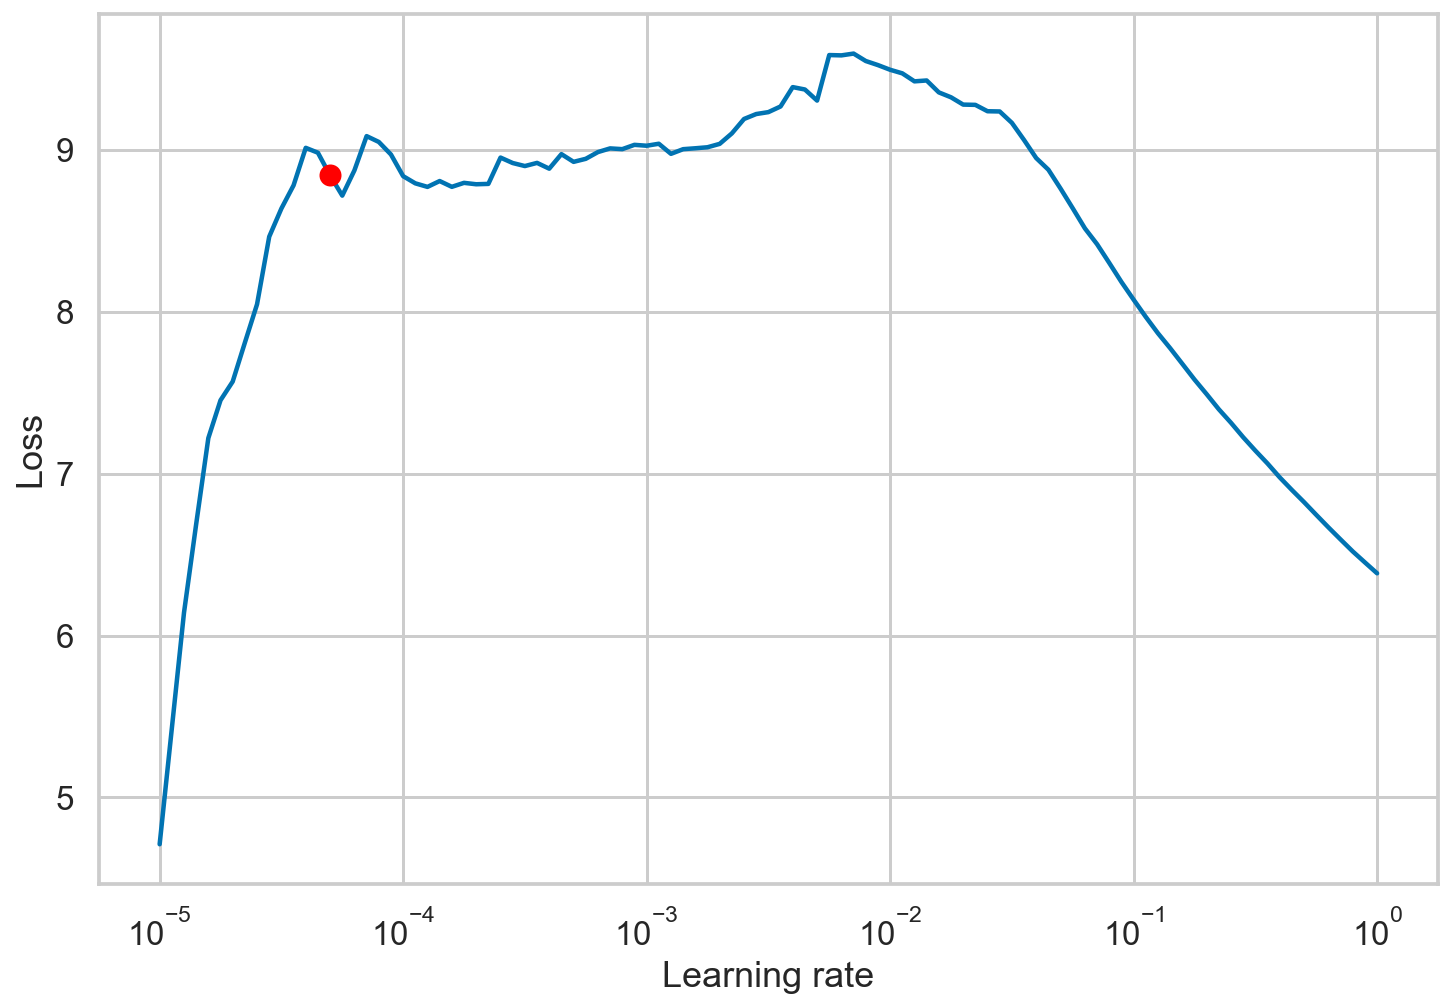

<Figure size 864x576 with 0 Axes>

In [15]:
pl.seed_everything(42)

deep_ar = DeepAR.from_dataset(
    train_set, 
    learning_rate=1e-2,
    hidden_size=30, 
    rnn_layers=4
)

trainer = pl.Trainer(gradient_clip_val=1e-1)
res = trainer.tuner.lr_find(
    deep_ar,
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader,
    min_lr=1e-5,
    max_lr=1e0,
    early_stop_threshold=100,
)

print(f"제안된 학습률: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)

plt.tight_layout()
sns.despine()
# plt.savefig("이미지/피규어_15_11")

10. DeepAR 모델 훈련:

In [14]:
pl.seed_everything(42)

deep_ar.hparams.learning_rate = res.suggestion()

early_stop_callback = EarlyStopping(
    monitor="val_loss", 
    min_delta=1e-4, 
    patience=10
)

trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback]
)

trainer.fit(
    deep_ar,
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader,
)

Global seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /Users/eryk/Documents/eryk/python_for_finance_2nd_private/15_deep_learning_in_finance/lightning_logs

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 0     
3 | rnn                    | LSTM                   | 26.3 K
4 | distribution_projector | Linear                 | 62    
------------------------------------------------------------------
26.3 K    Trainable params
0         Non-trainable params
26.3 K    Total params
0.105     Total estimated model params size (MB)


Epoch 29: 100%|██████████| 323/323 [00:49<00:00,  6.55it/s, loss=2.5, v_num=0, train_loss_step=2.400, val_loss=2.380, train_loss_epoch=2.510] 

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 323/323 [00:49<00:00,  6.55it/s, loss=2.5, v_num=0, train_loss_step=2.400, val_loss=2.380, train_loss_epoch=2.510]


11. 체크포인트에서 최상의 DeepAR 모델 추출:

In [16]:
best_model = DeepAR.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path
)

12. 검증 세트에 대한 예측을 생성하고 그 중 5개를 플롯합니다.

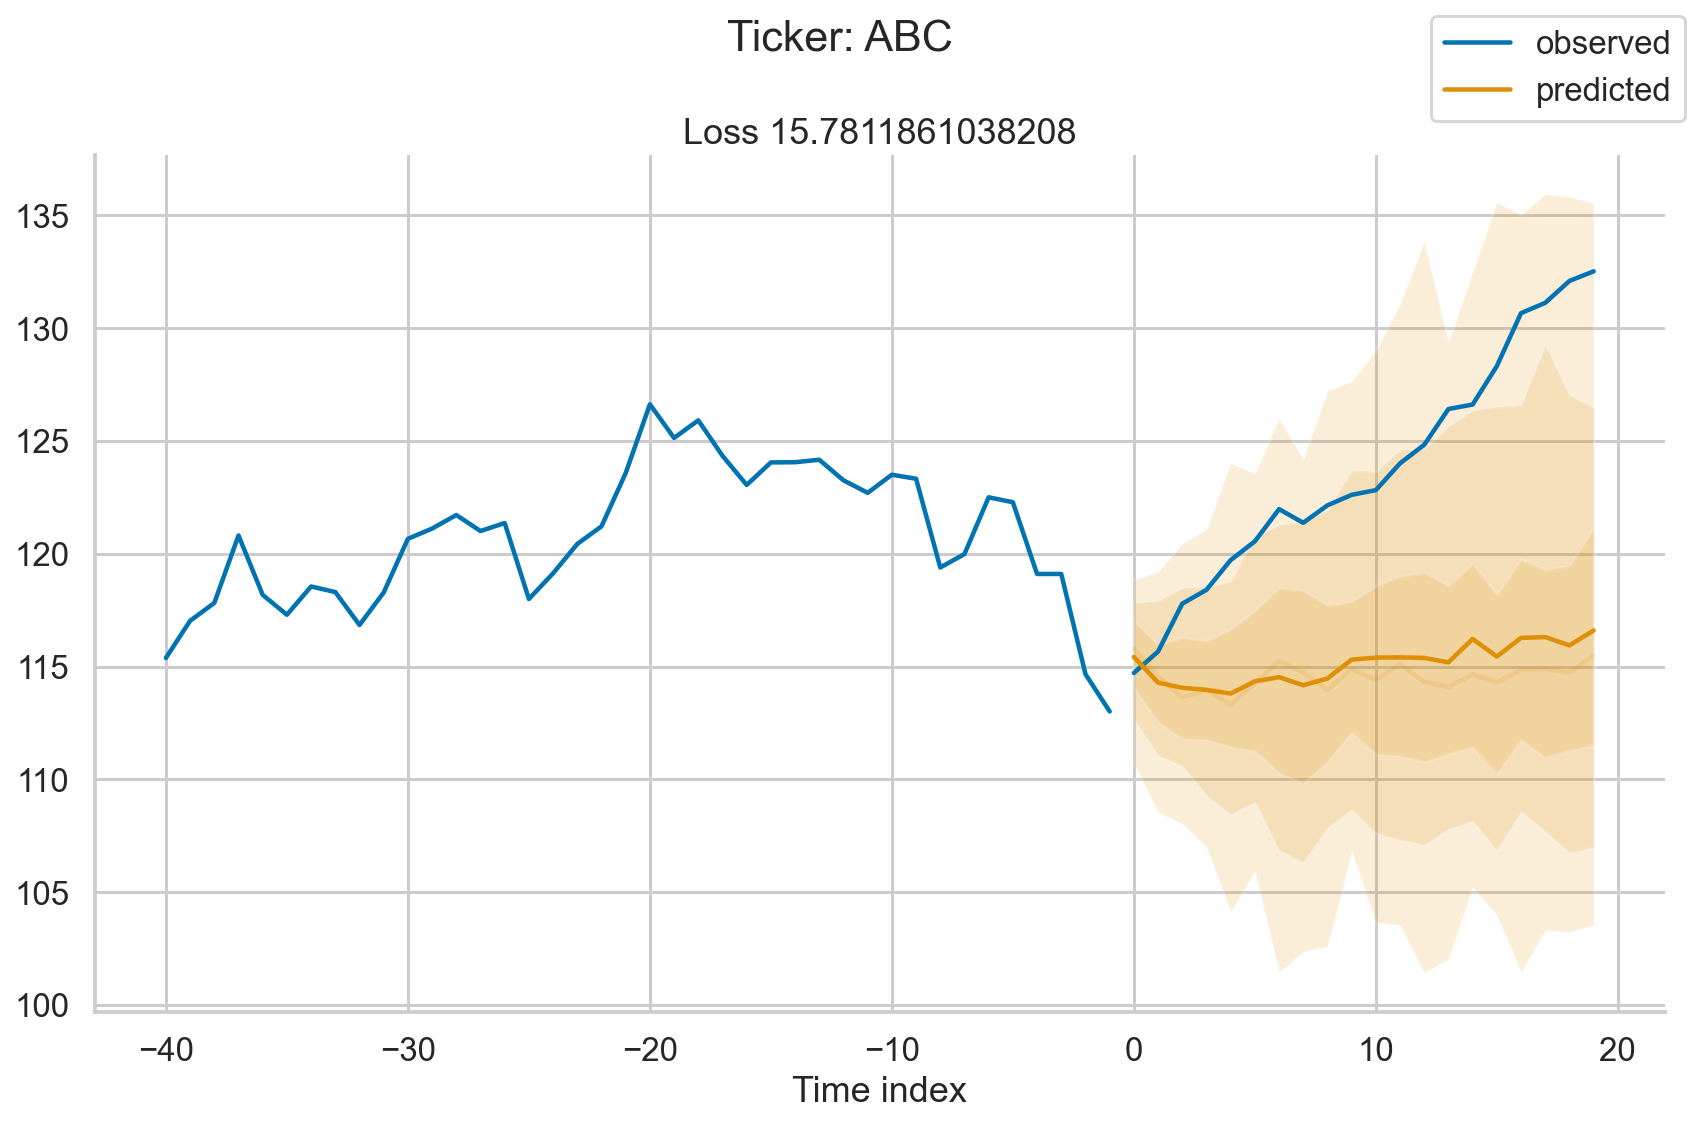

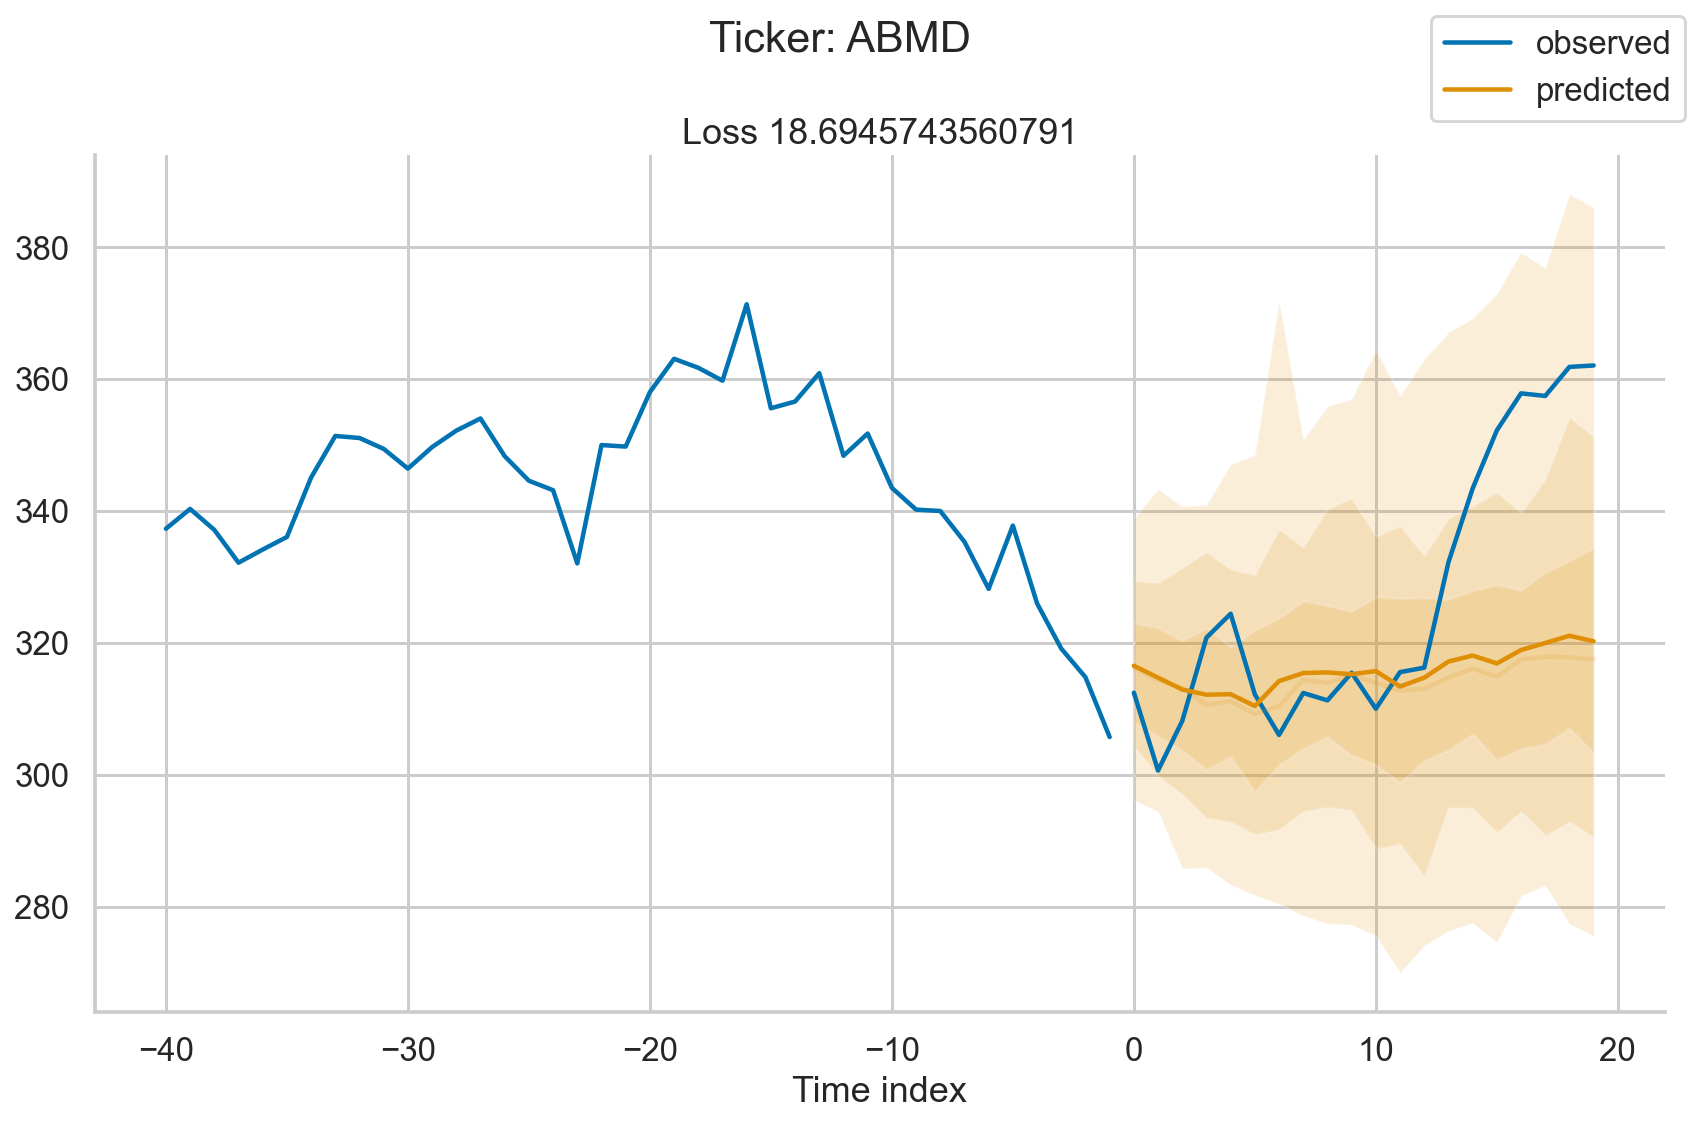

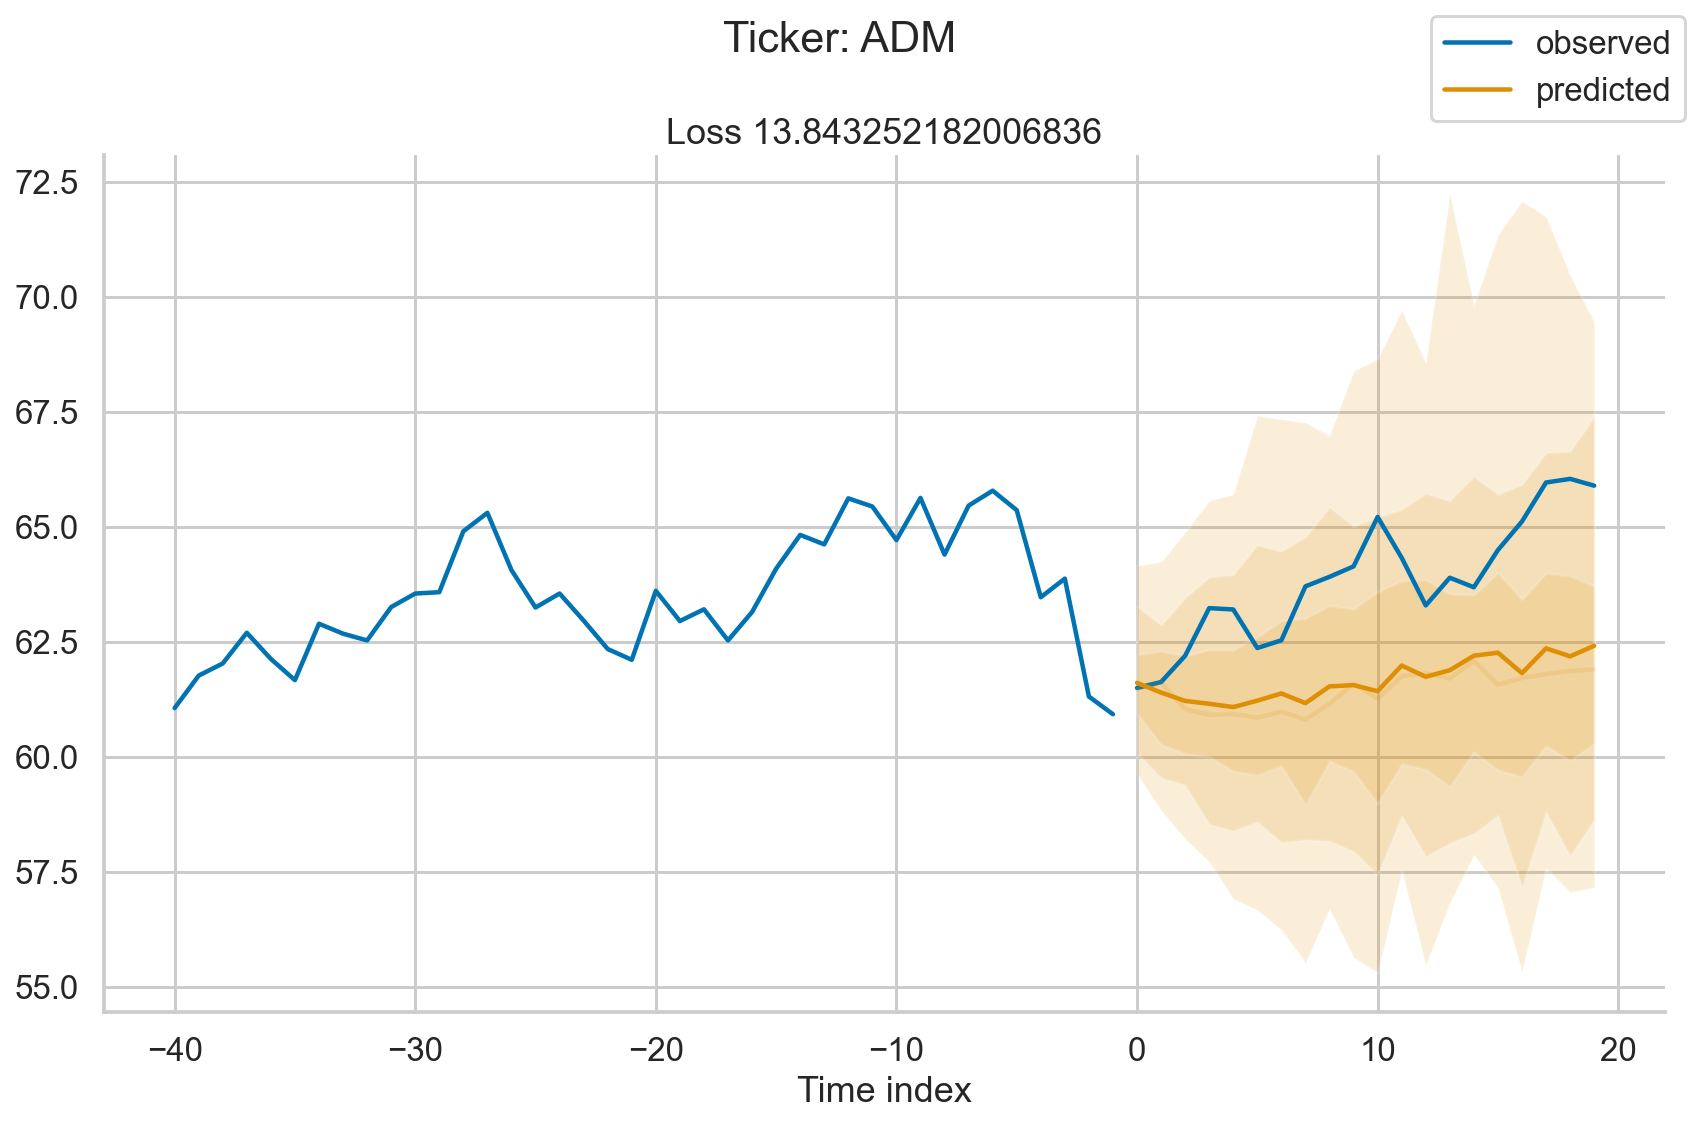

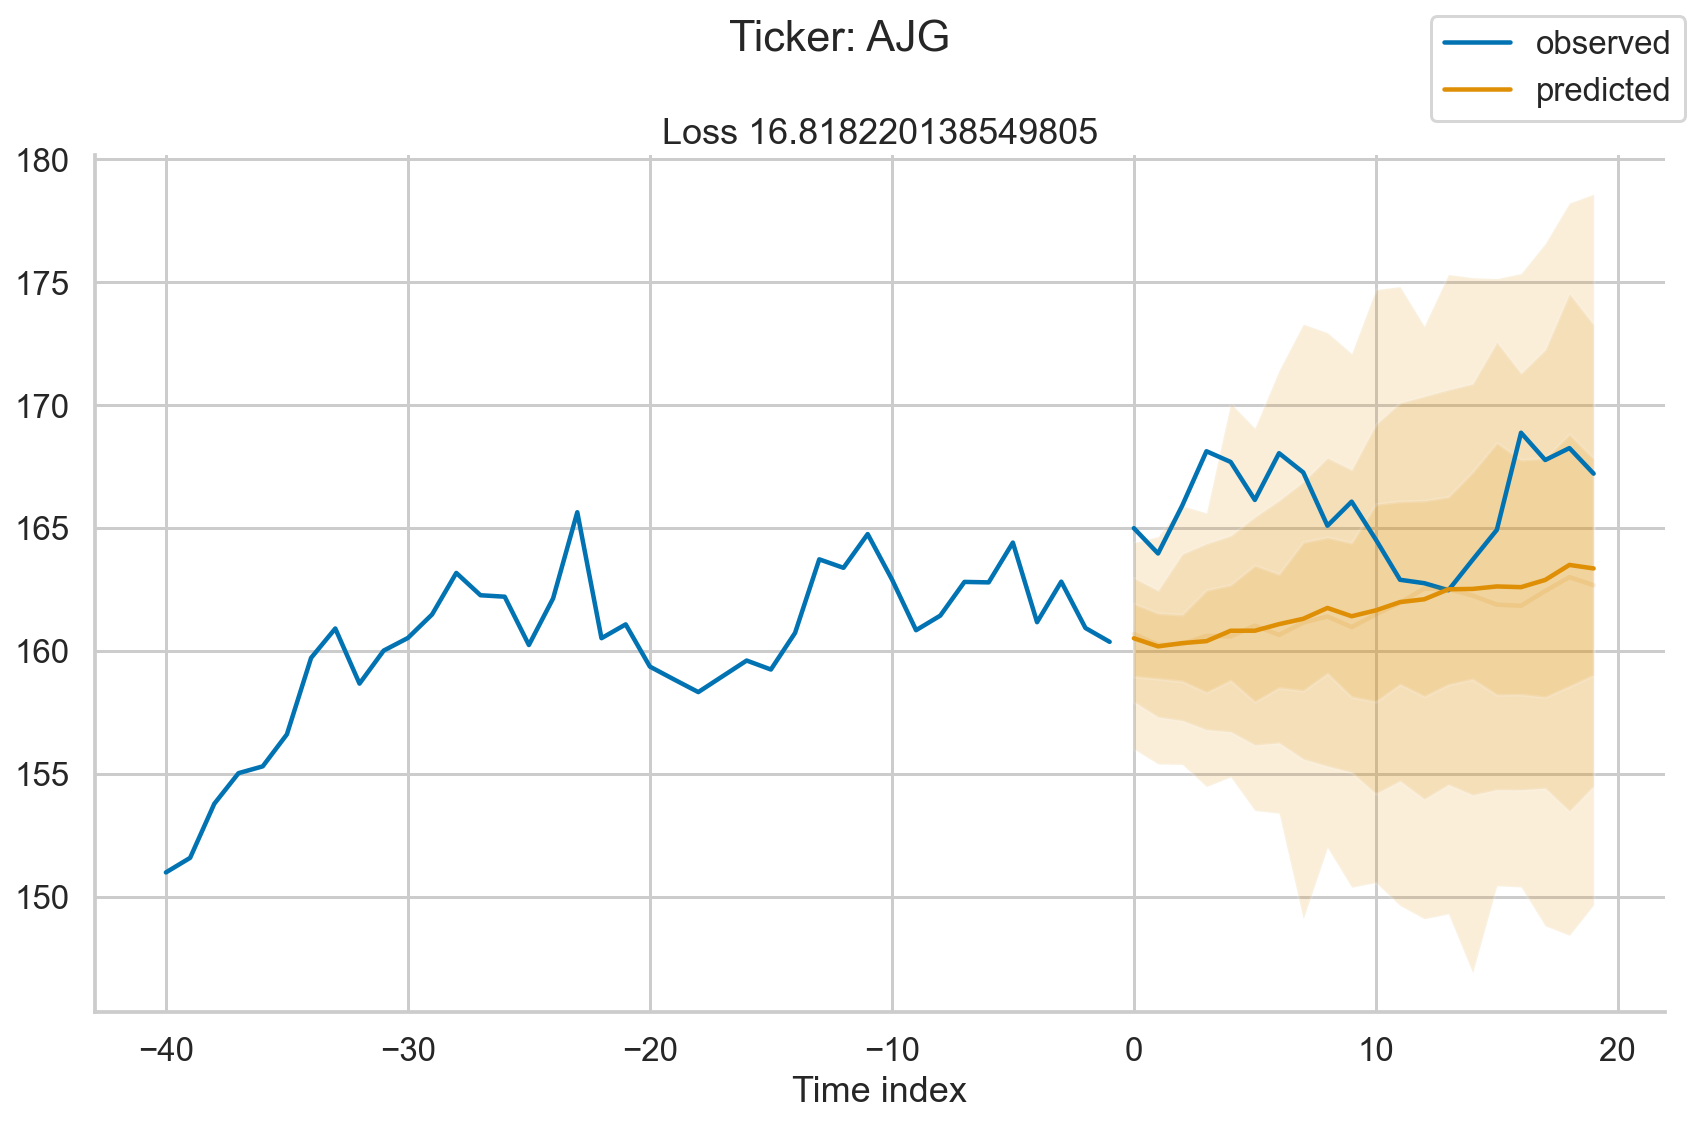

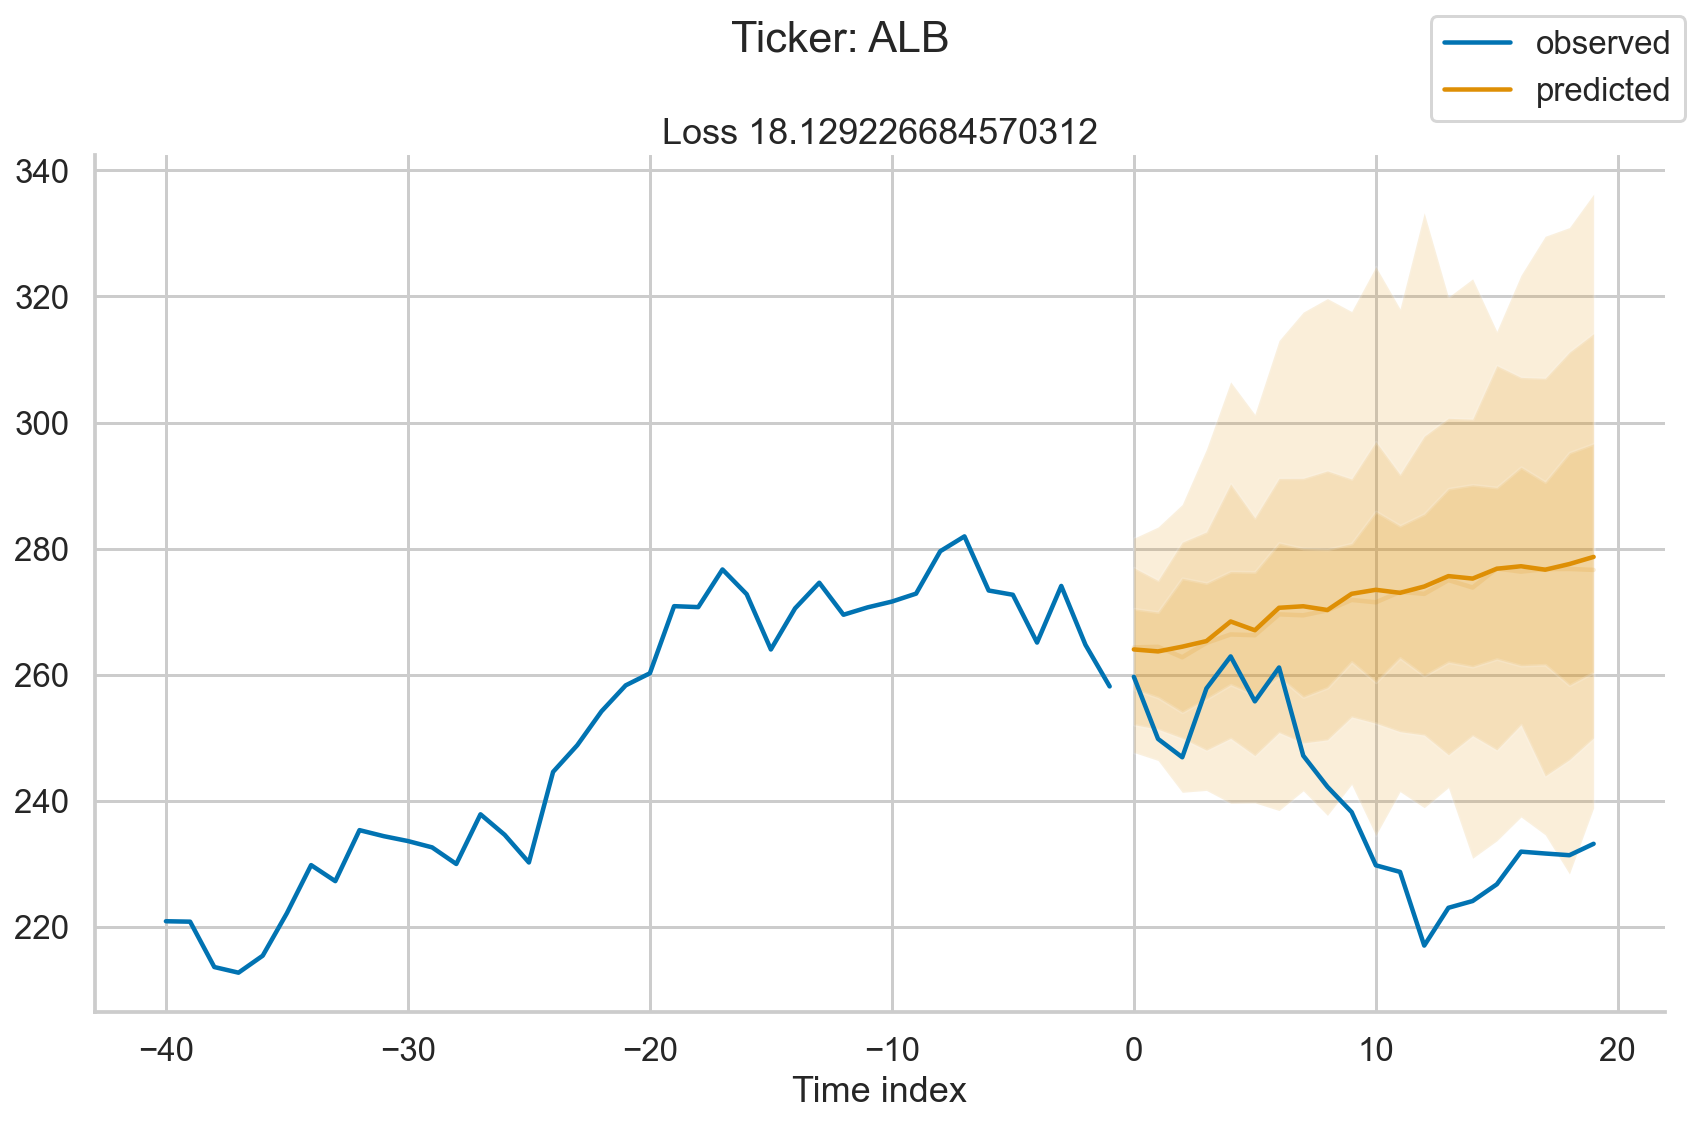

In [17]:
raw_predictions, x = best_model.predict(
    valid_dataloader, 
    mode="raw", 
    return_x=True, 
    n_samples=100
)

tickers = valid_set.x_to_index(x)["ticker"]

for idx in range(5):
    best_model.plot_prediction(
        x, raw_predictions, idx=idx, add_loss_to_title=True
    )
    plt.suptitle(f"Ticker: {tickers.iloc[idx]}")

    plt.tight_layout()
    sns.despine()
    # plt.savefig(f"이미지/피규어_15_12_{idx}")

### 더 많은 것이 있습니다

1. 라이브러리 가져오기:

In [16]:
from pytorch_forecasting.metrics import MultivariateNormalDistributionLoss
import seaborn as sns
import numpy as np

In [17]:
# df = ar_data를 생성합니다(
# 계절성=10.0,
# 시간 단계 = len(원시_차원),
# n_series=len(선택된 티커),
# 씨앗=42
# None
# df["날짜"] = pd.타임스탬프("2020-01-01") + pd.to_timedelta(df.시간_idx, "D")
# df = df.astype(사전(시리즈=str))
# df.columns = ["티커", "시간_IDX", "가격", "날짜"]
# 디에프

2. DataLoaders를 다시 정의하고 이번에는 `batch_sampler`를 지정합니다.

In [18]:
train_set = TimeSeriesDataSet(
    df[lambda x: x["time_idx"] <= training_cutoff],
    time_idx="time_idx",
    target="price",
    group_ids=["ticker"],
    static_categoricals=["ticker"],  
    time_varying_unknown_reals=["price"],
    max_encoder_length=MAX_ENCODER_LENGTH,
    max_prediction_length=MAX_PRED_LENGTH,
)

valid_set = TimeSeriesDataSet.from_dataset(
    train_set, df, min_prediction_idx=training_cutoff+1
)

train_dataloader = train_set.to_dataloader(
    train=True, 
    batch_size=BATCH_SIZE,
    batch_sampler="synchronized"
)
valid_dataloader = valid_set.to_dataloader(
    train=False, 
    batch_size=BATCH_SIZE, 
    batch_sampler="synchronized"
)

3. DeepVAR 모델을 정의하고 학습률을 찾으세요.

Global seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Finding best initial lr: 100%|██████████| 100/100 [00:12<00:00,  8.25it/s]
Restoring states from the checkpoint path at /Users/eryk/Documents/eryk/python_for_finance_2nd_private/15_deep_learning_in_finance/.lr_find_738ad47e-9c6c-4cf2-845a-96c7059437c6.ckpt


Suggested learning rate: 8.912509381337456e-05


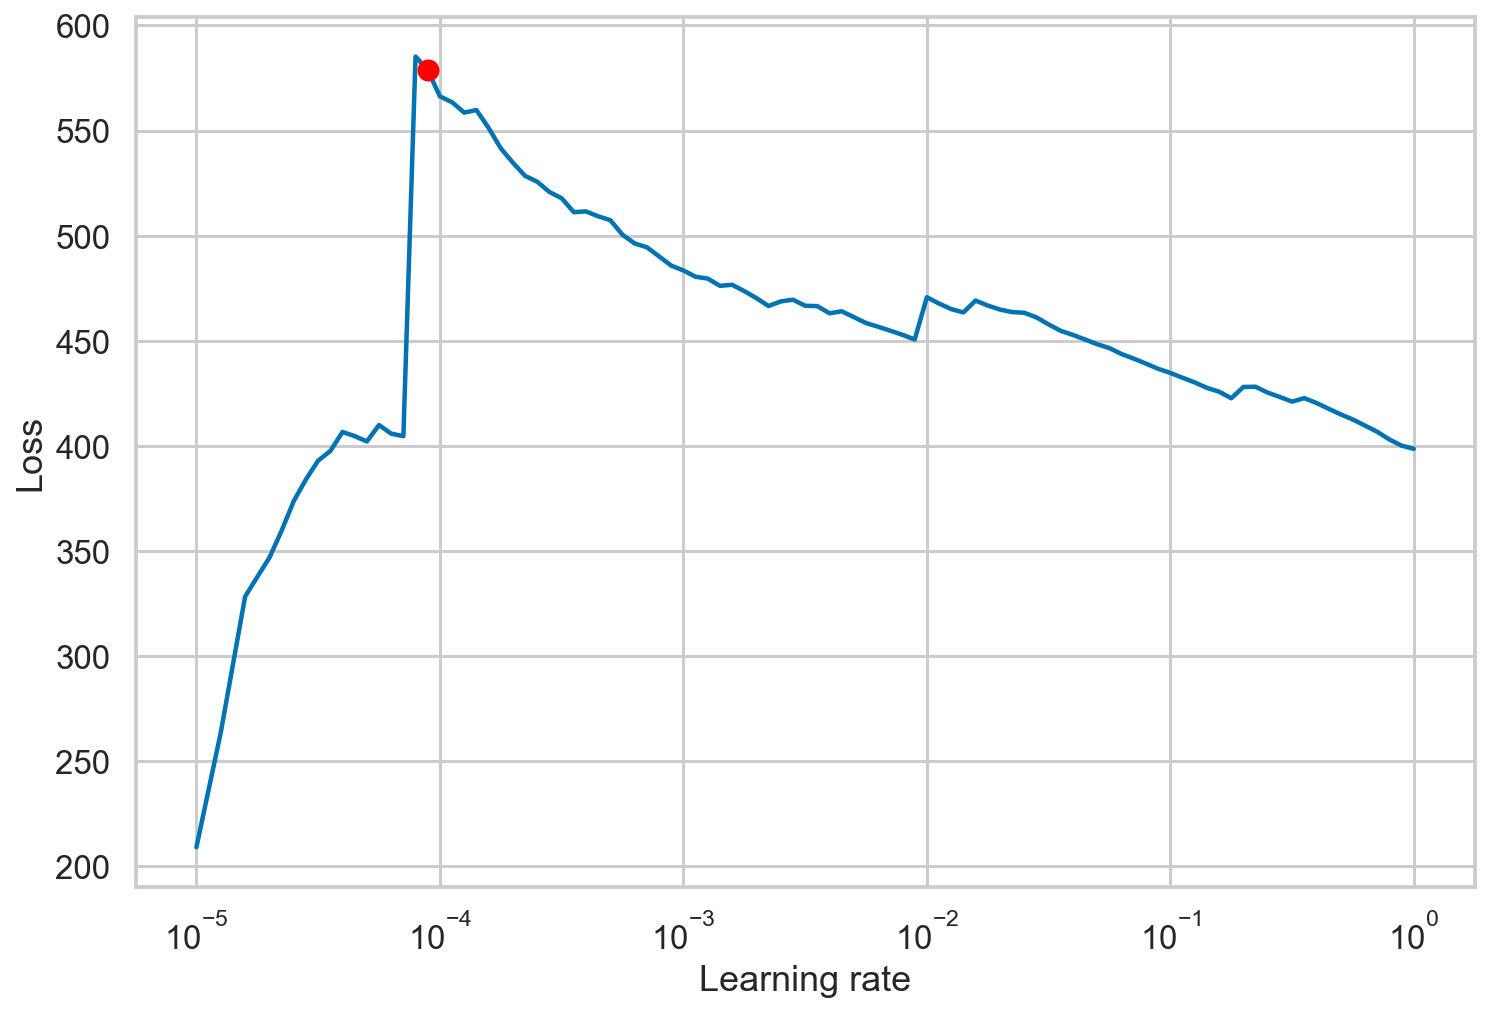

In [19]:
pl.seed_everything(42)

deep_var = DeepAR.from_dataset(
    train_set, 
    learning_rate=1e-2, 
    hidden_size=30, 
    rnn_layers=4,
    loss=MultivariateNormalDistributionLoss()
)

trainer = pl.Trainer(gradient_clip_val=1e-1)
res = trainer.tuner.lr_find(
    deep_var,
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader,
    min_lr=1e-5,
    max_lr=1e0,
    early_stop_threshold=100,
)

print(f"제안된 학습률: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)

4. 선택된 학습률을 사용하여 DeepVAR 모델을 훈련합니다.

In [20]:
pl.seed_everything(42)

deep_var.hparams.learning_rate = res.suggestion()

early_stop_callback = EarlyStopping(
    monitor="val_loss", 
    min_delta=1e-4, 
    patience=10
)

trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback]
)

trainer.fit(
    deep_var,
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader,
)

Global seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                               | Params
------------------------------------------------------------------------------
0 | loss                   | MultivariateNormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList                         | 0     
2 | embeddings             | MultiEmbedding                     | 2.0 K 
3 | rnn                    | LSTM                               | 28.8 K
4 | distribution_projector | Linear                             | 372   
------------------------------------------------------------------------------
31.2 K    Trainable params
0         Non-trainable params
31.2 K    Total params
0.125     Total estimated model params size (MB)


Epoch 29: 100%|██████████| 427/427 [00:57<00:00,  7.43it/s, loss=222, v_num=1, train_loss_step=248.0, val_loss=196.0, train_loss_epoch=214.0]  

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 427/427 [00:57<00:00,  7.43it/s, loss=222, v_num=1, train_loss_step=248.0, val_loss=196.0, train_loss_epoch=214.0]


5. 체크포인트에서 최상의 DeepVAR 모델 추출:

In [21]:
best_model = DeepAR.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path
)

6. 검증 세트에 대한 예측을 생성하고 그 중 5개를 플롯합니다.

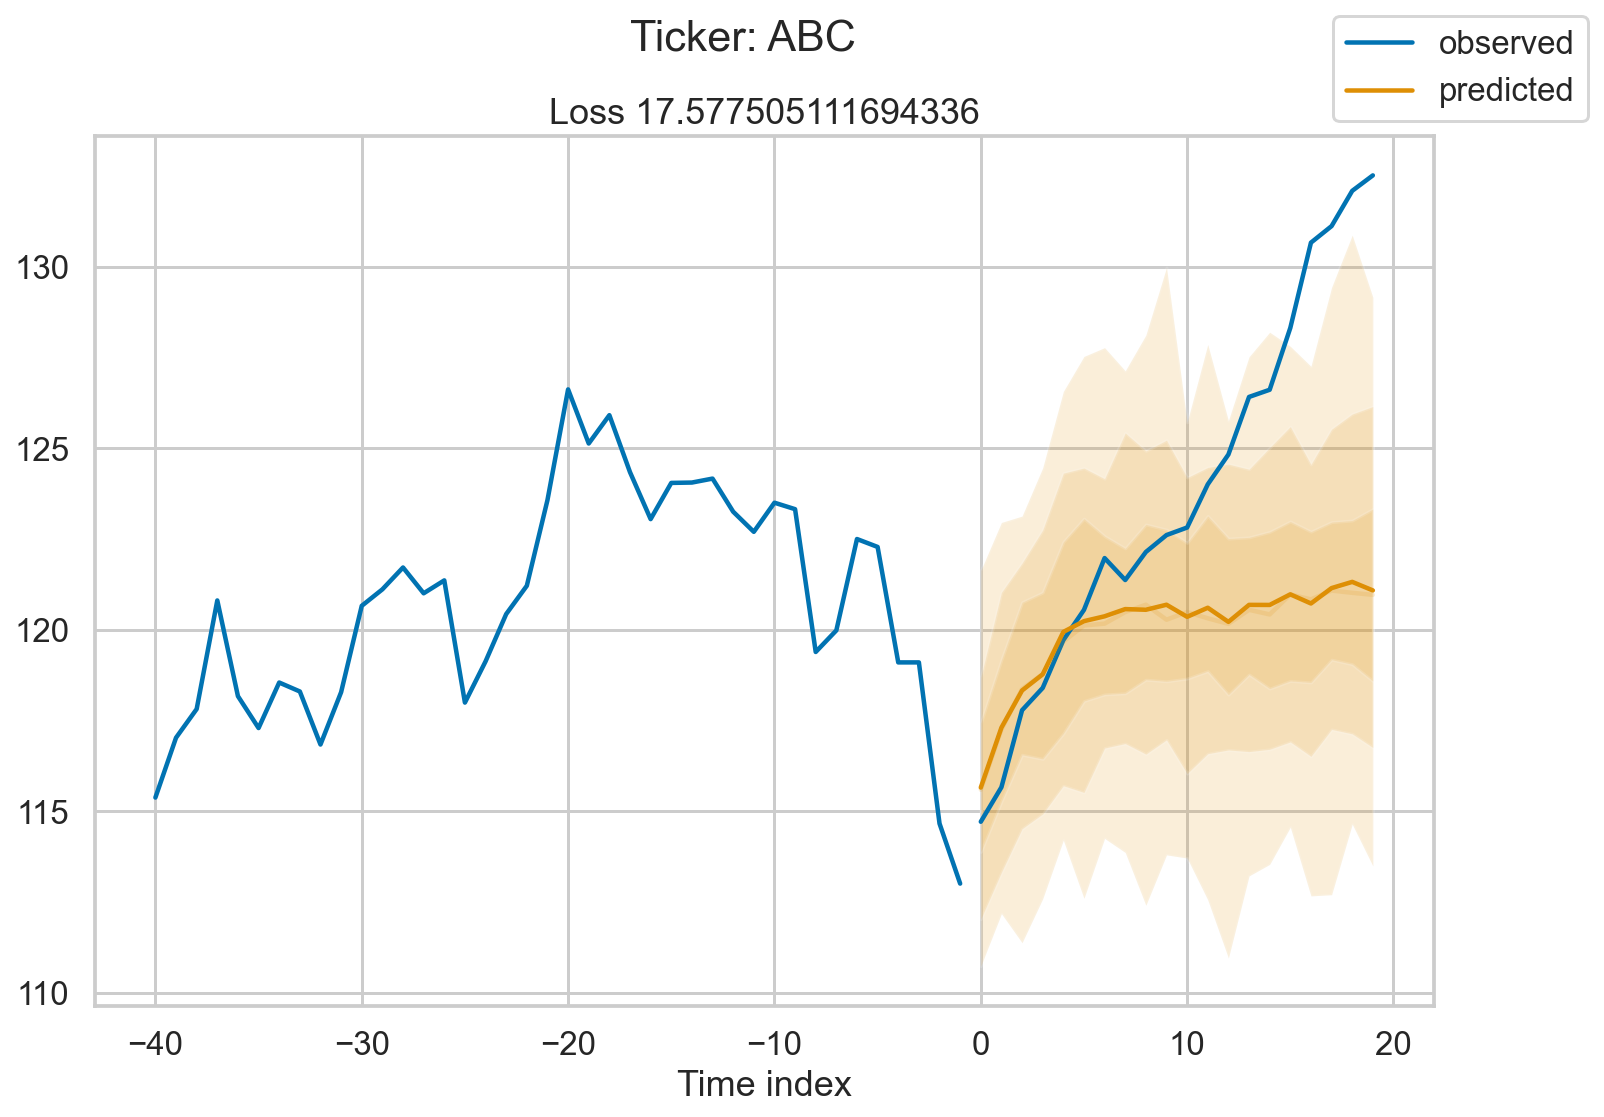

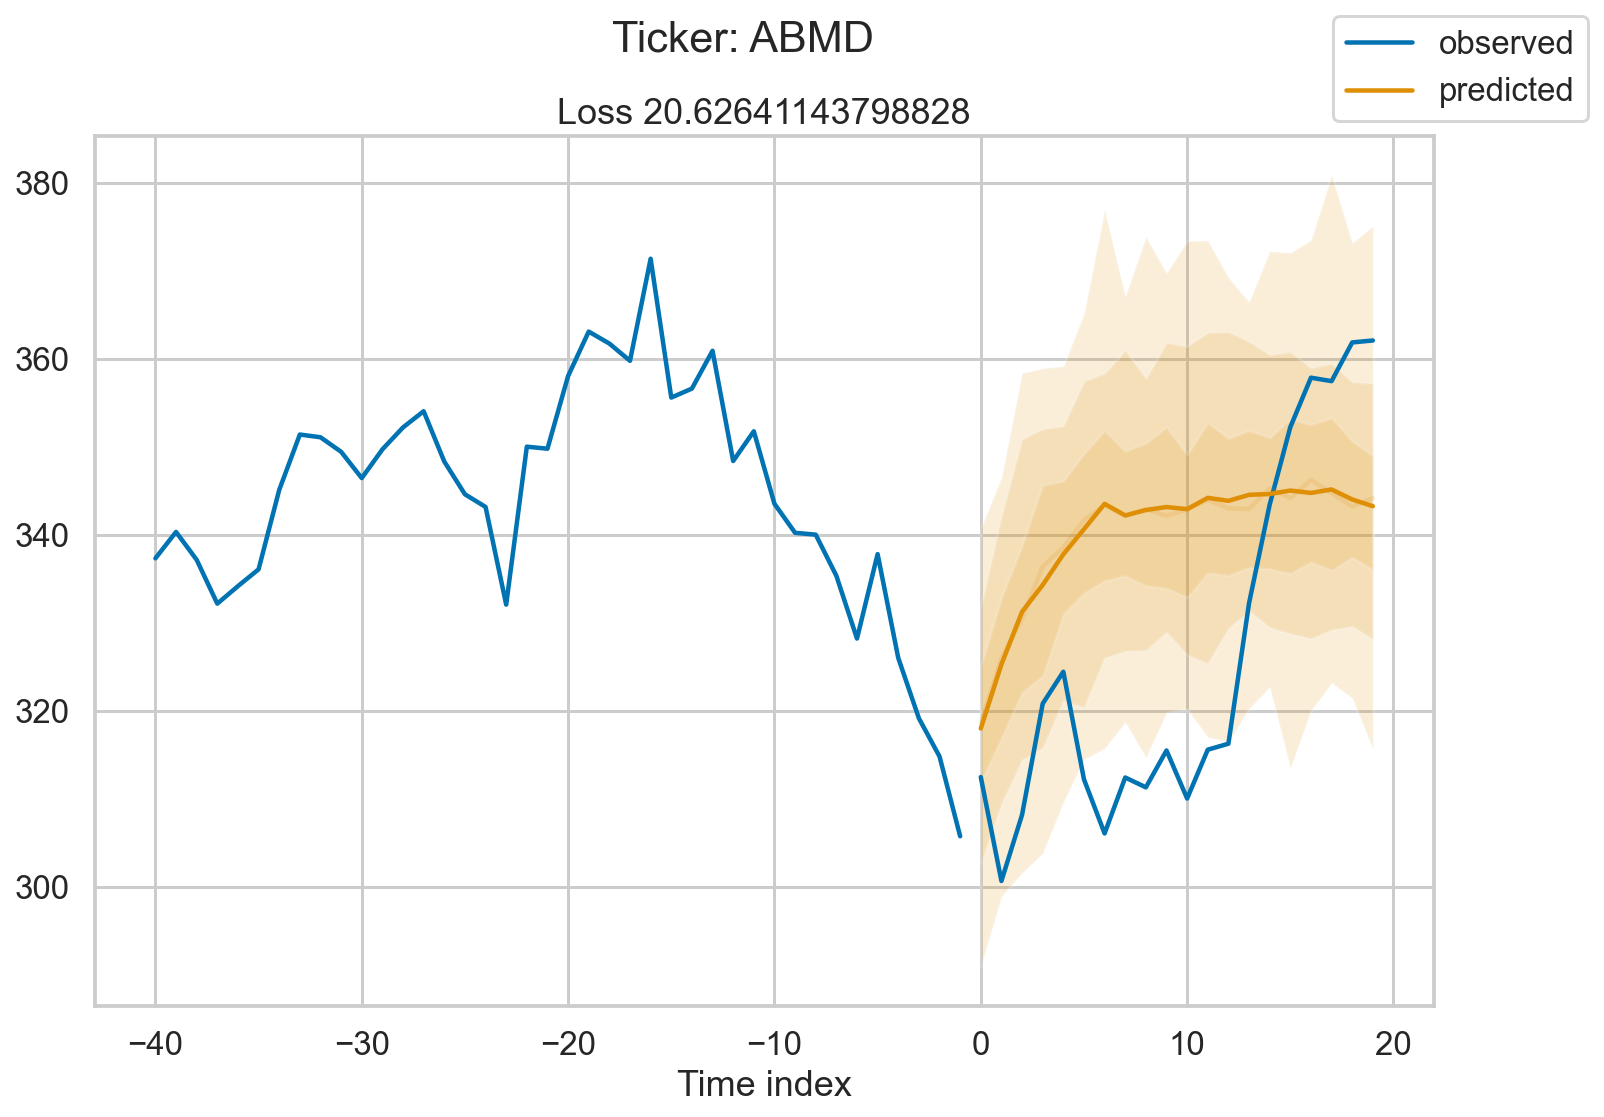

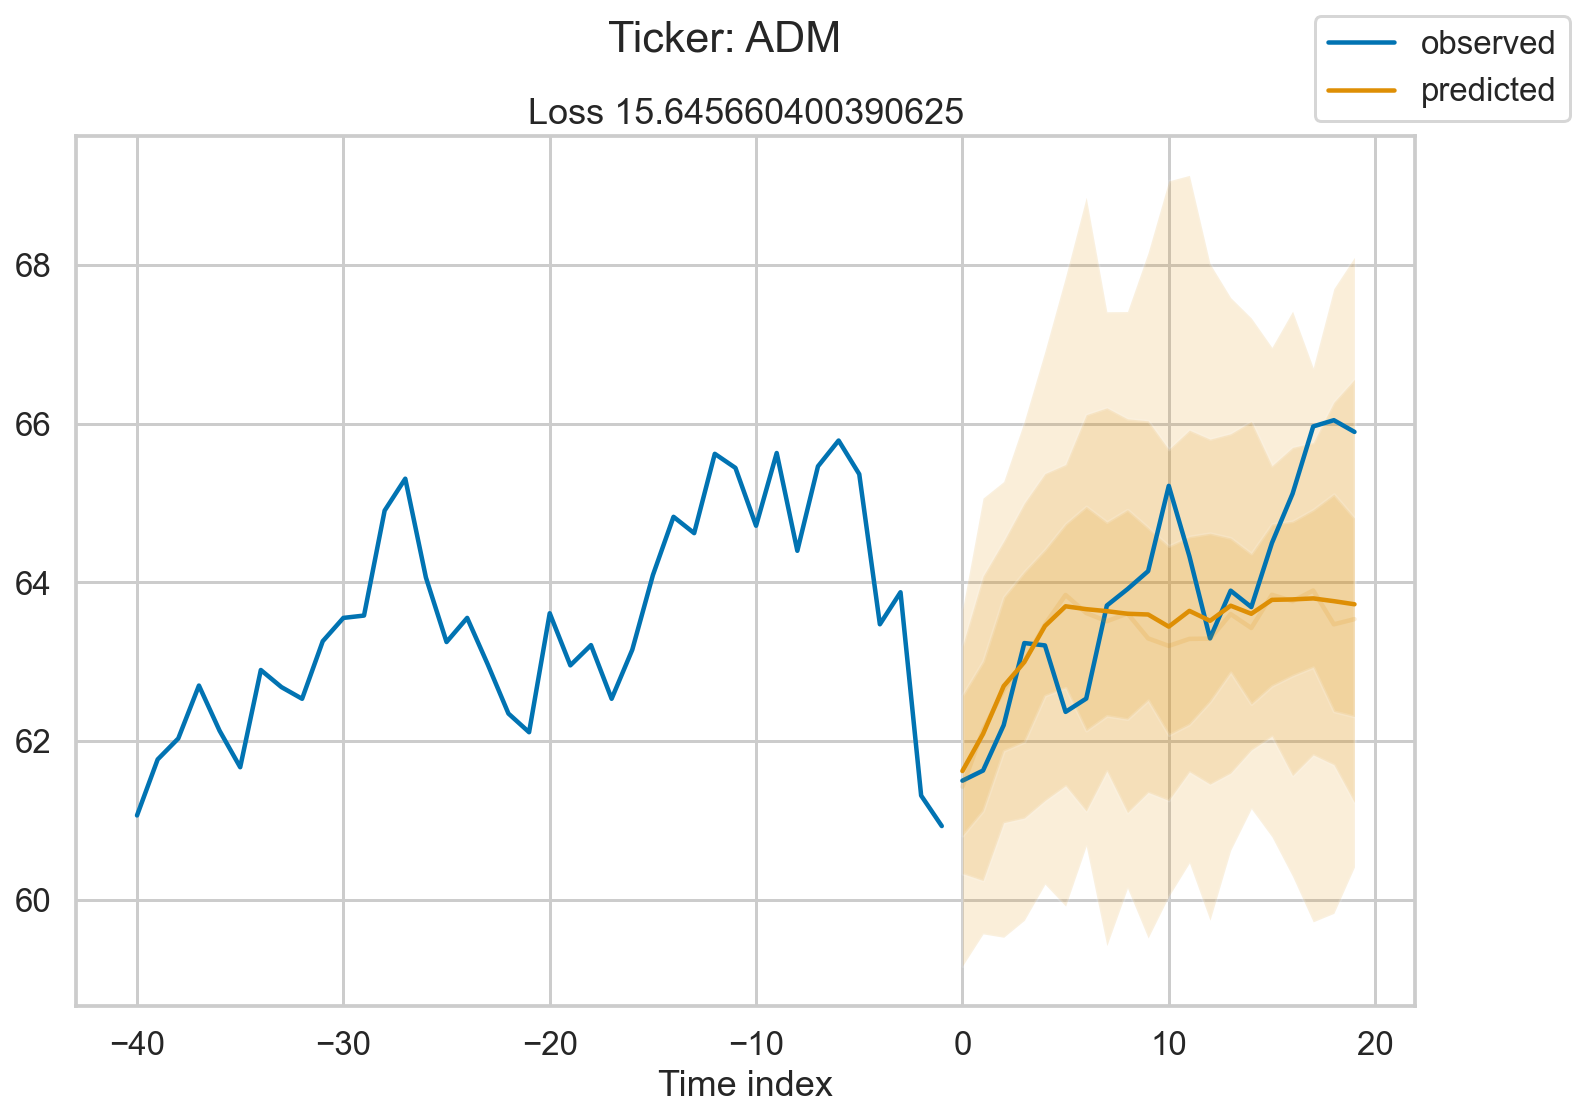

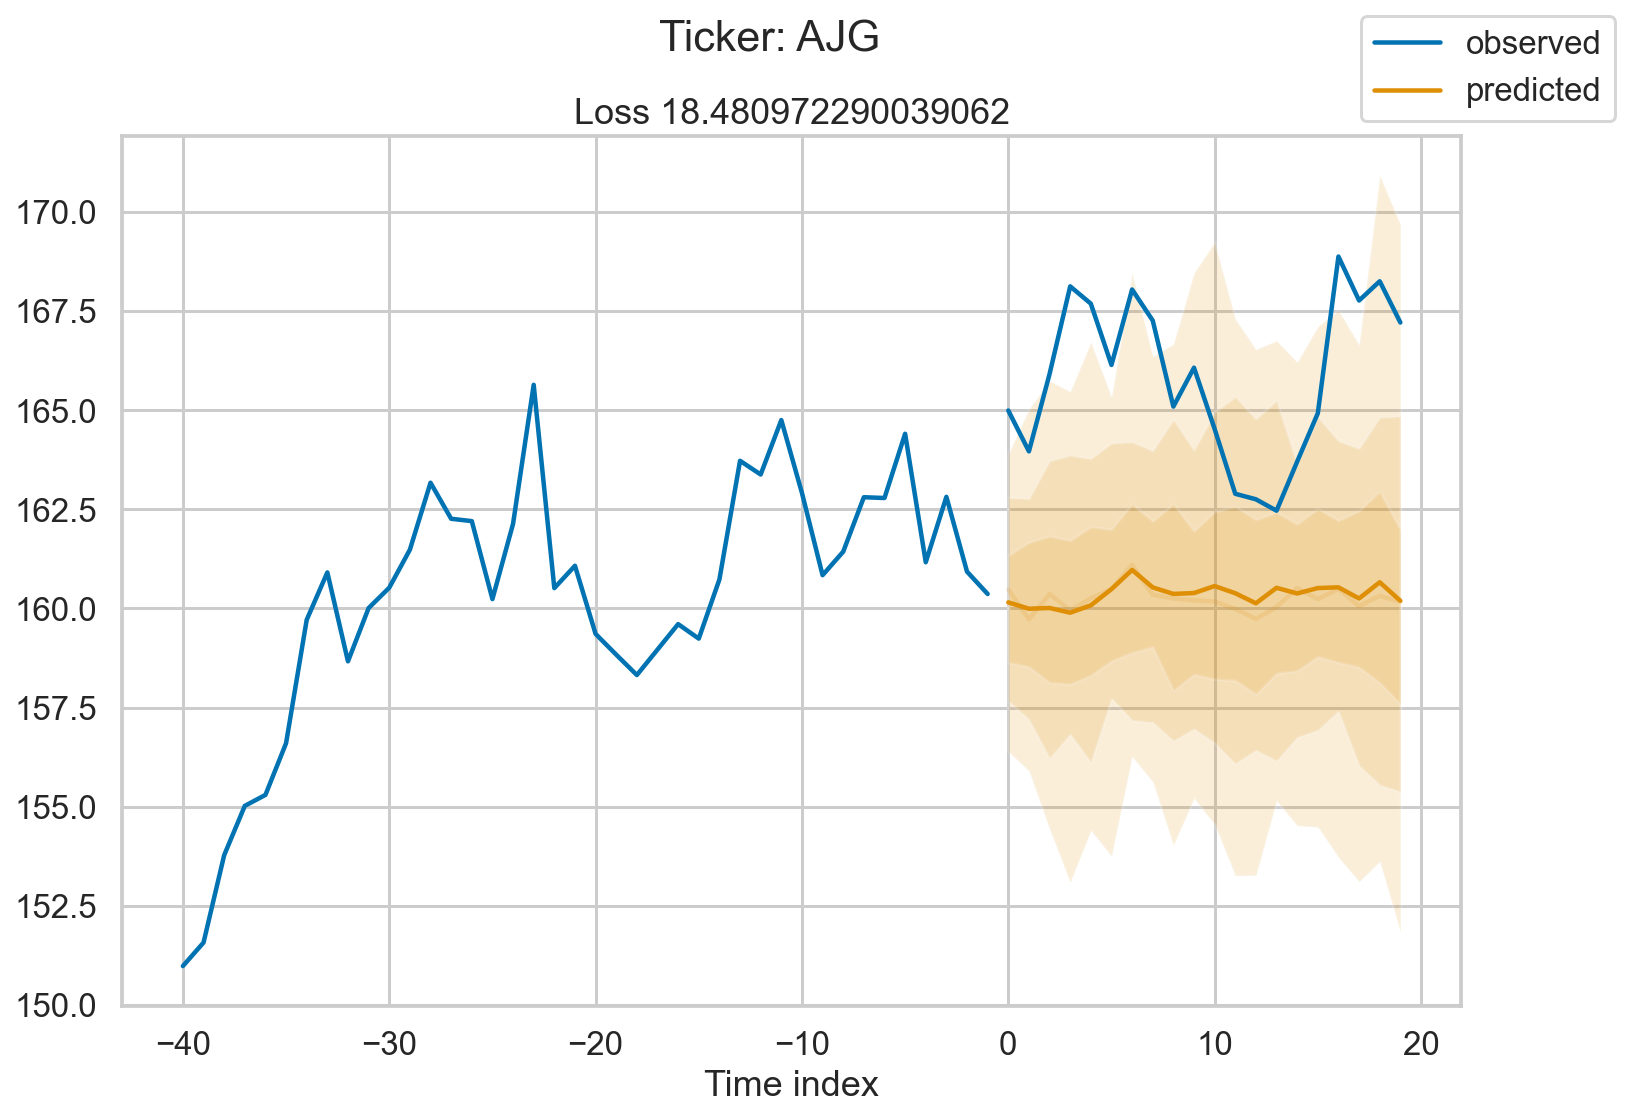

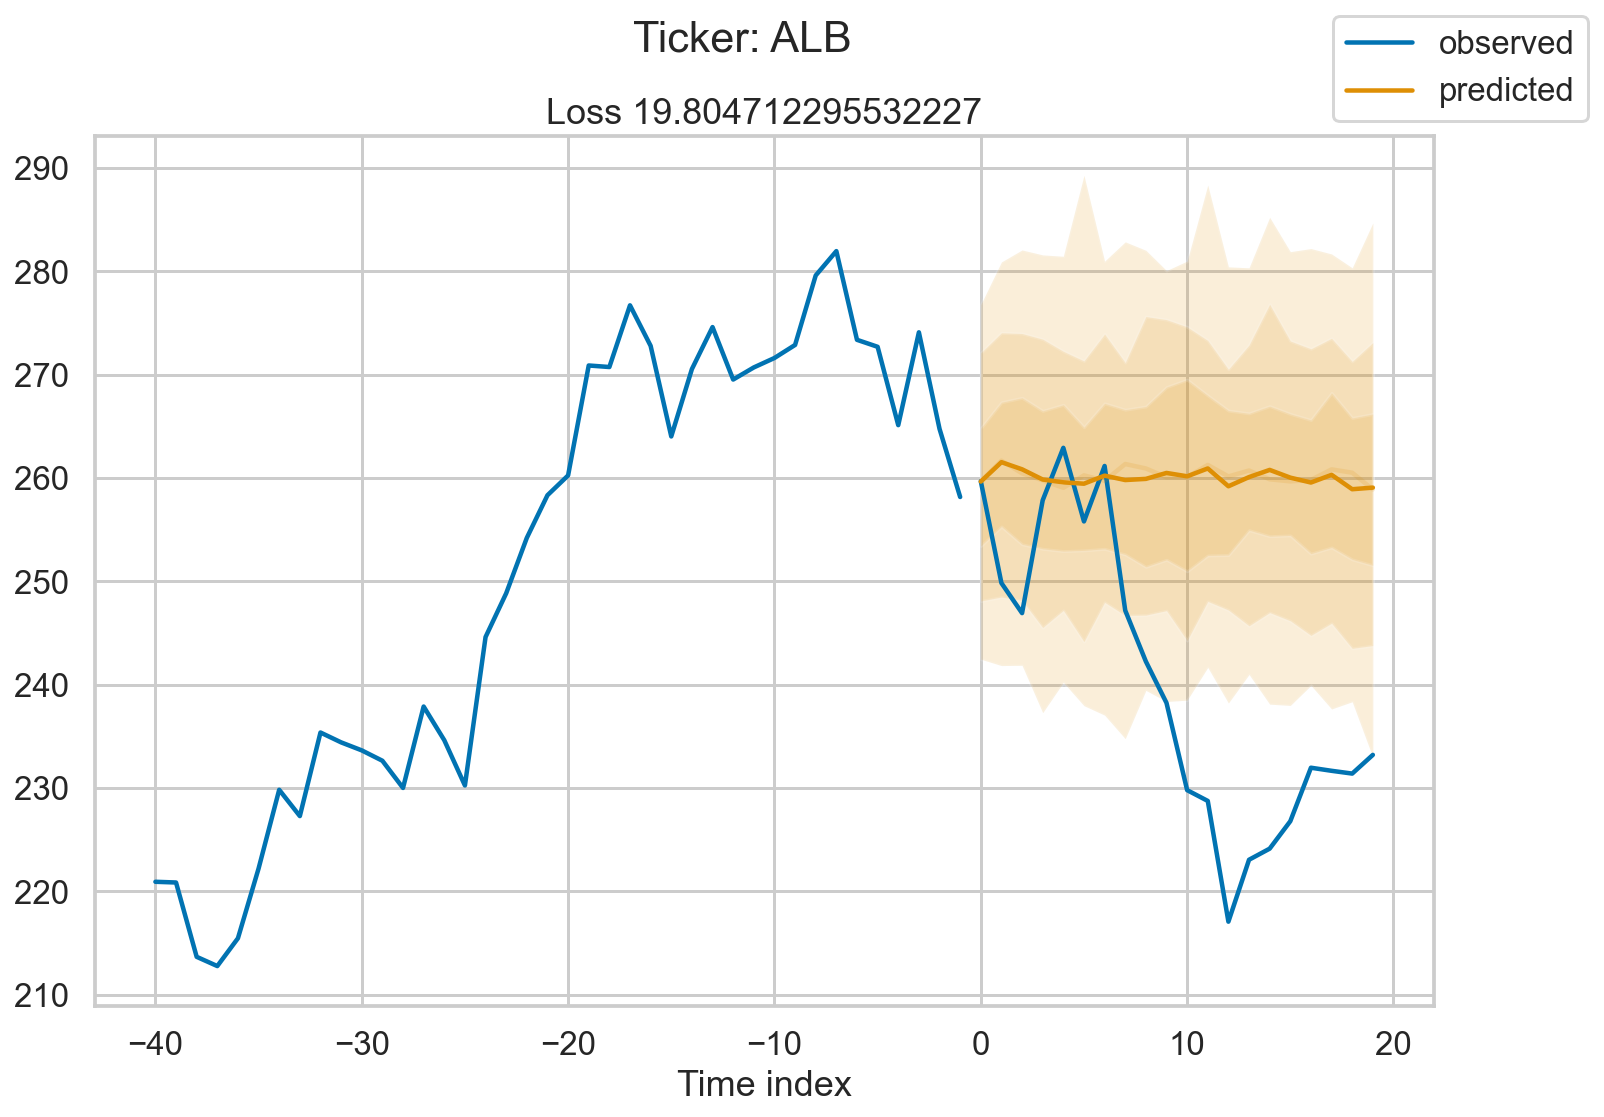

In [22]:
raw_predictions, x = best_model.predict(
    valid_dataloader, 
    mode="raw", 
    return_x=True, 
    n_samples=100
)
tickers = valid_set.x_to_index(x)["ticker"]

for idx in range(5):
    best_model.plot_prediction(
        x, raw_predictions, idx=idx, add_loss_to_title=True
    )
    plt.suptitle(f"Ticker: {tickers.iloc[idx]}")

7. 상관 행렬 추출:

In [23]:
preds = best_model.predict(valid_dataloader, 
                           mode=("raw", "prediction"), 
                           n_samples=None)
                           
cov_matrix = (
    best_model
    .loss
    .map_x_to_distribution(preds)
    .base_dist
    .covariance_matrix
    .mean(0)
)

# 공분산 행렬 대각선을 1.0으로 정규화합니다.
cov_diag_mult = (
    torch.diag(cov_matrix)[None] * torch.diag(cov_matrix)[None].T
)
corr_matrix = cov_matrix / torch.sqrt(cov_diag_mult)


8. 상관 행렬을 그리세요:

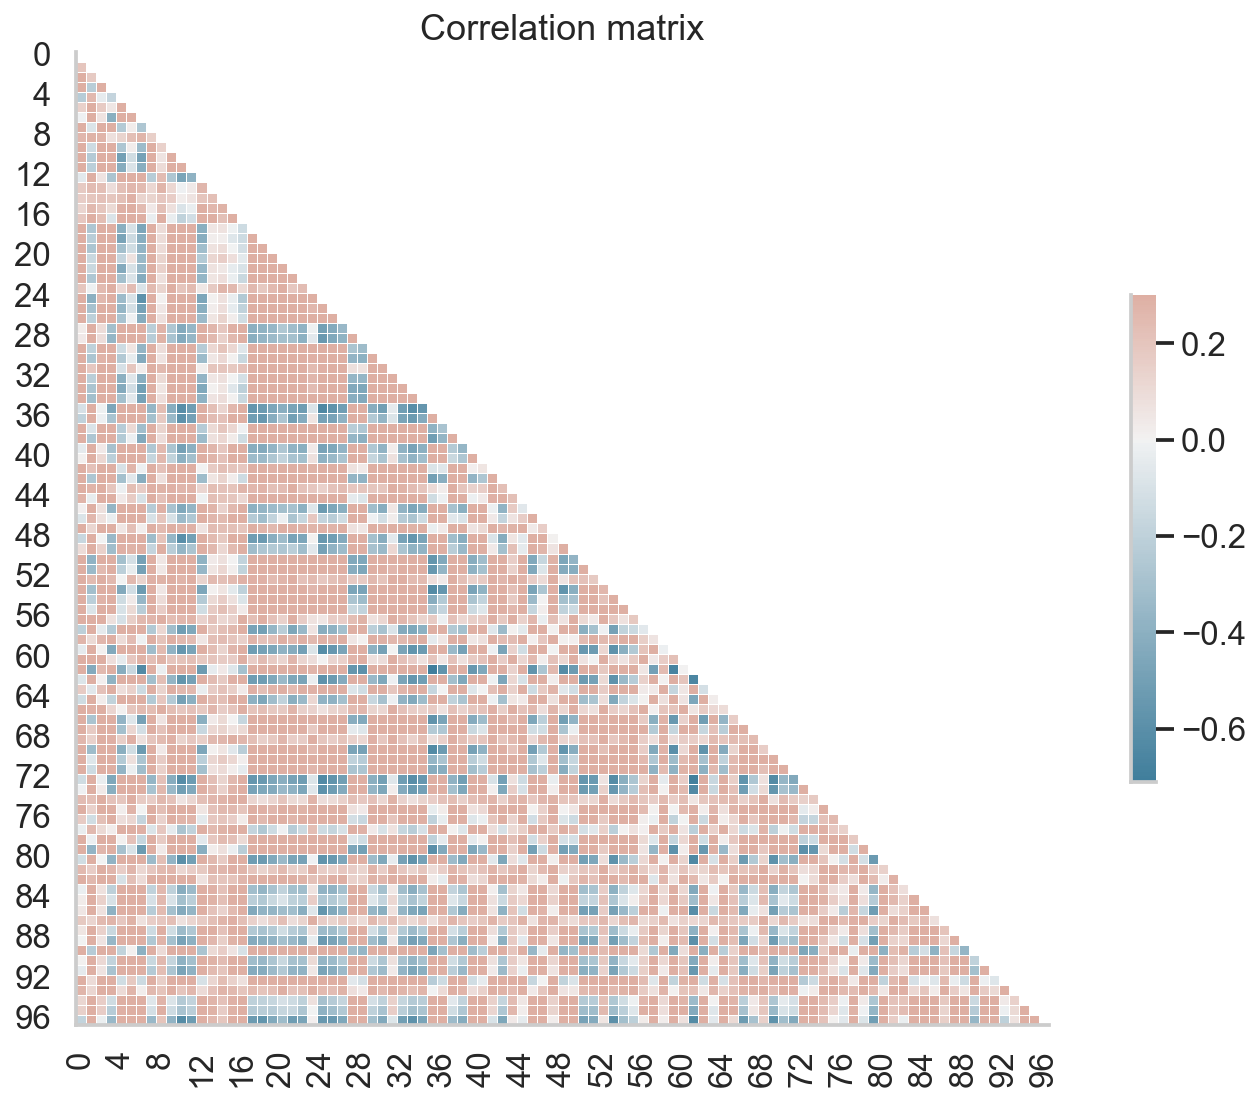

In [24]:
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

fif, ax = plt.subplots()

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(
    corr_matrix, mask=mask, cmap=cmap, 
    vmax=.3, center=0, square=True, 
    linewidths=.5, cbar_kws={"shrink": .5}
)

ax.set_title("Correlation matrix")

plt.tight_layout()
sns.despine()
# plt.savefig("이미지/피규어_15_14")

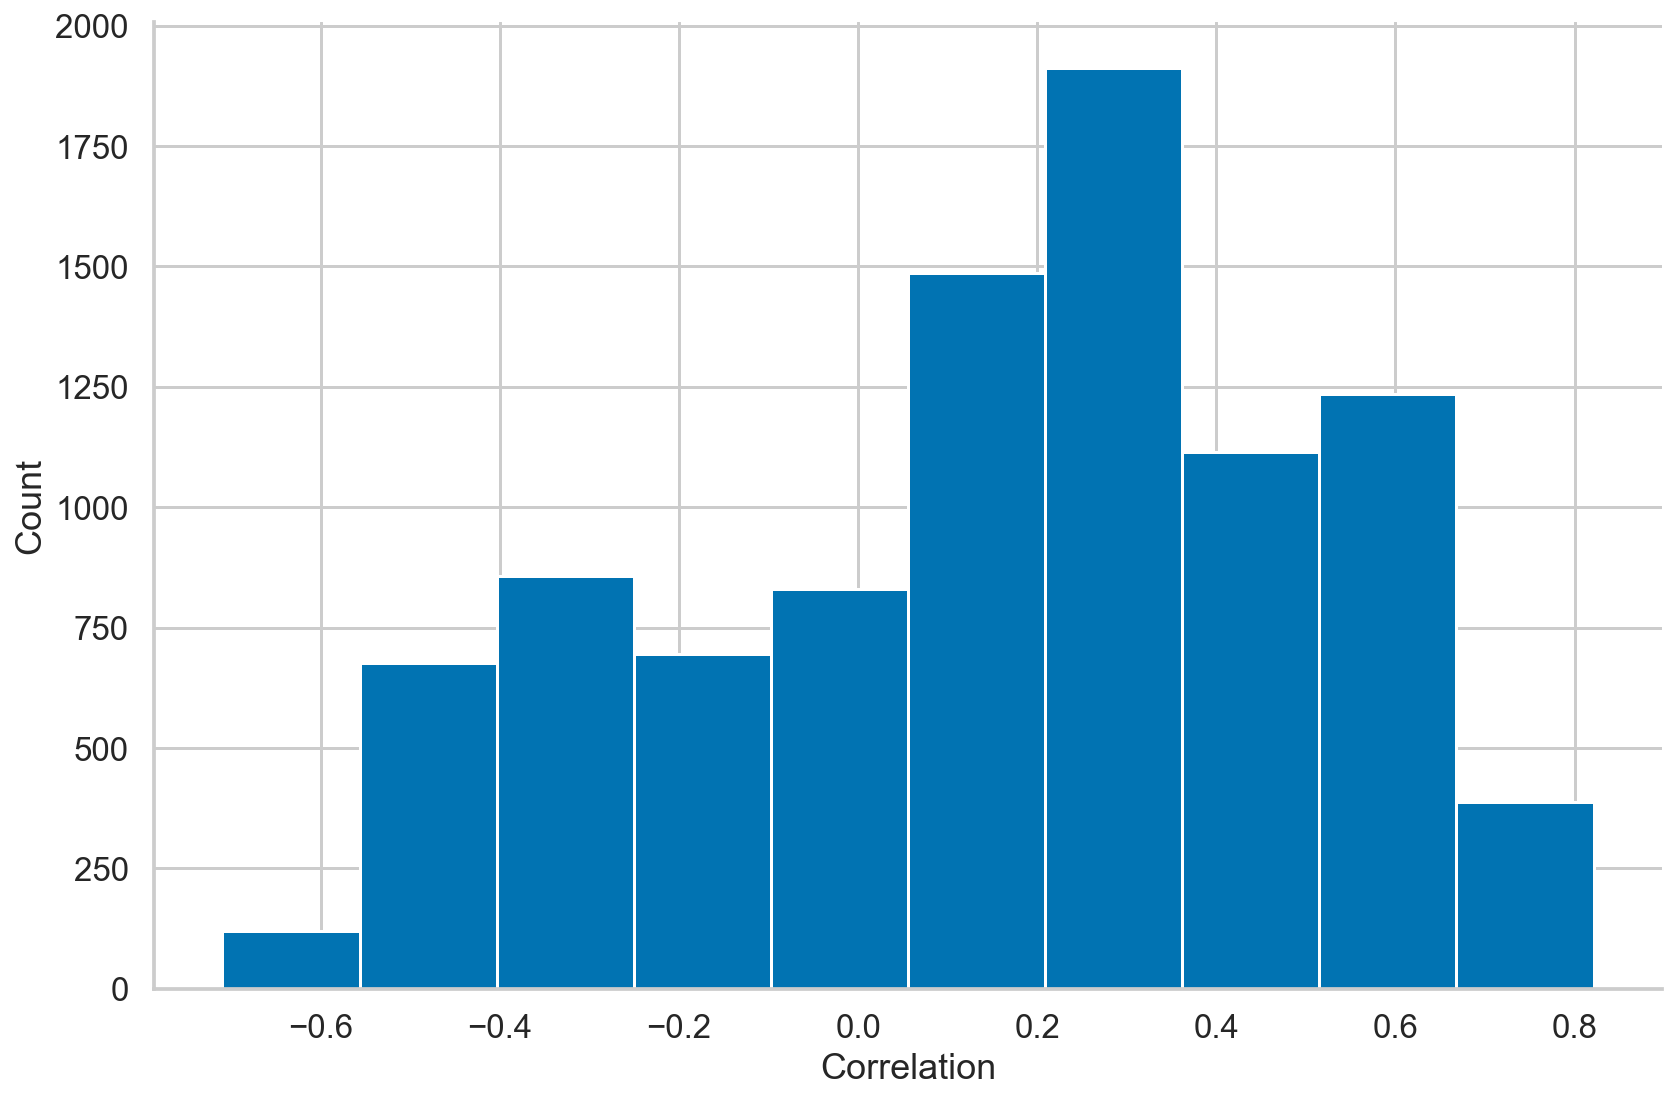

In [26]:
# 대각선이 아닌 상관관계의 분포
plt.hist(corr_matrix[corr_matrix < 1].numpy())

plt.xlabel("Correlation")
plt.ylabel("Count")

plt.tight_layout()
sns.despine()
# plt.savefig("이미지/피규어_15_15")

### DeepAR의 주요 장점

- 다변량 시계열 처리

    + 여러 관련 시계열 동시 학습
    + 시계열 간 패턴 학습
    + Cold-start 문제 해결


- 확률적 예측

    + 예측 불확실성 추정
    + 다양한 시나리오 생성
    + 리스크 평가 용이


- 자동 특성 학습
    + 계절성 자동 감지
    + 추세 학습
    + 외부 변수 통합



9. 성능 최적화 팁

- 데이터 전처리

    + 적절한 정규화 방법 선택
    + 결측치 처리
    + 이상치 처리


- 모델 구조 최적화

    + hidden_size 조정
    + rnn_layers 수 조정
    + dropout 비율 조정


- 학습 과정 최적화
    
    + 배치 크기 조정
    + 학습률 스케줄링
    + 조기 종료 전략



10. 활용 사례

- 수요 예측

    + 제품 판매량 예측
    + 재고 관리
    + 리소스 계획


- 금융 시계열

    + 주가 예측
    + 리스크 평가
    + 포트폴리오 최적화


- 에너지 소비

    + 전력 수요 예측
    + 피크 부하 예측
    + 자원 할당



DeepAR은 특히 많은 관련 시계열 데이터가 있는 경우에 효과적이며, 예측의 불확실성을 고려해야 하는 금융 분야에서 유용하게 활용될 수 있습니다.

## 15.4 NeuralProphet을 사용한 시계열 예측
> NeuralProphet은 Facebook의 Prophet을 확장한 딥러닝 기반 시계열 예측 모델입니다.주요 특징:

- Prophet의 해석가능성 유지
- 자동회귀(AR) 기능 추가
- PyTorch 백엔드 사용
- 향상된 성능과 확장성

NeuralProphet은 다음 구성요소들을 포함합니다:

- 추세 (Trend)
- 계절성 (Seasonality)
- 휴일/이벤트 효과
- 자동회귀(AR)
- 미래 회귀변수
- 과거 회귀변수

### 방법은...

1. 라이브러리 가져오기:

In [3]:
import yfinance as yf
import pandas as pd
from neuralprophet import NeuralProphet
from neuralprophet.utils import set_random_seed
from neuralprophet.utils import set_log_level

2. S&P 500 지수의 과거 가격을 다운로드하고 NeuralProphet으로 모델링하기 위한 DataFrame을 준비합니다.

In [4]:
df = yf.download("^GSPC",
                 start="2010-01-01",
                 end="2021-12-31")
df = df[["Adj Close"]].reset_index(drop=False)
df.columns = ["ds", "y"]

[*********************100%***********************]  1 of 1 completed


3. 훈련/테스트 분할 생성:

In [5]:
TEST_LENGTH = 60
df_train = df.iloc[:-TEST_LENGTH]
df_test = df.iloc[-TEST_LENGTH:]

4. 기본 Prophet 모델을 훈련하고 평가 지표를 플로팅합니다.

 99%|█████████▉| 136/137 [00:00<00:00, 834.56it/s]


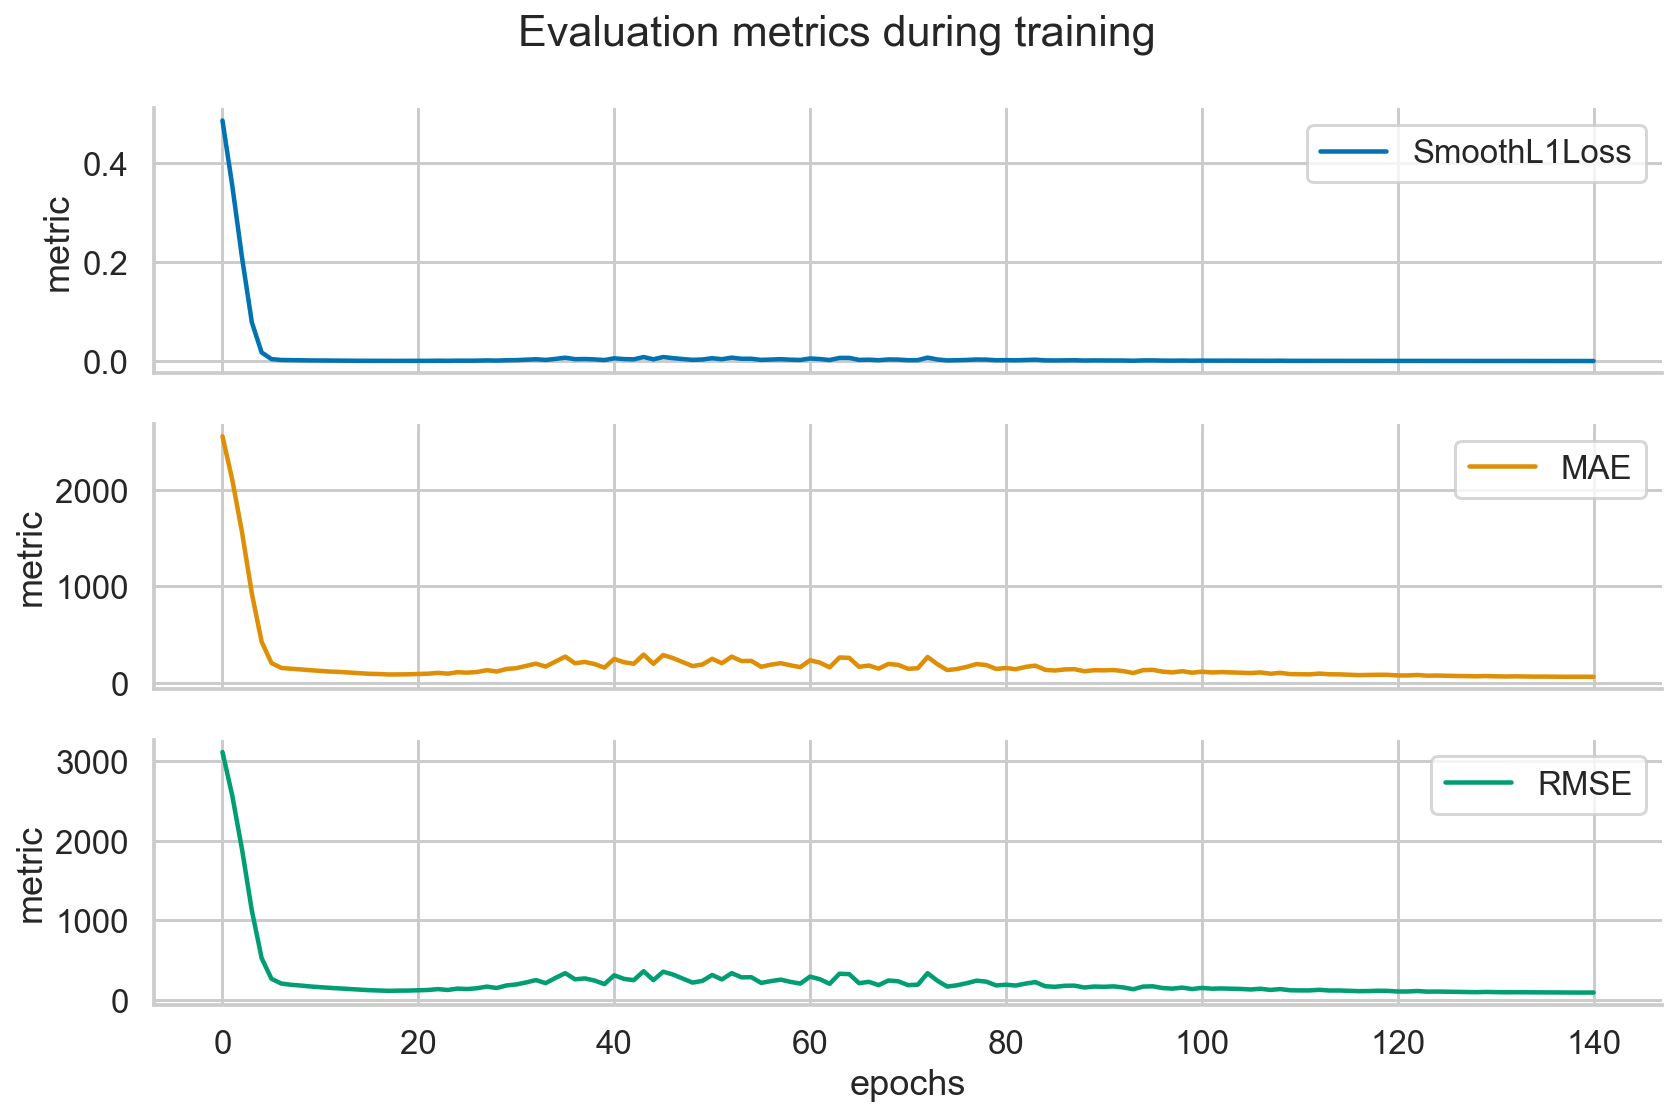

In [6]:
from matplotlib.pyplot import xlabel


set_random_seed(42)
set_log_level(log_level="ERROR")
model = NeuralProphet(changepoints_range=0.95)
metrics = model.fit(df_train, freq="B")

(
    metrics
    .drop(columns=["RegLoss"])
    .plot(title="Evaluation metrics during training", 
          subplots=True,
          xlabel="epochs",
          ylabel="metric")
)

plt.tight_layout()
sns.despine()
# plt.savefig("이미지/피규어_15_16")

5. 예측을 계산하고 적합도를 플로팅합니다.

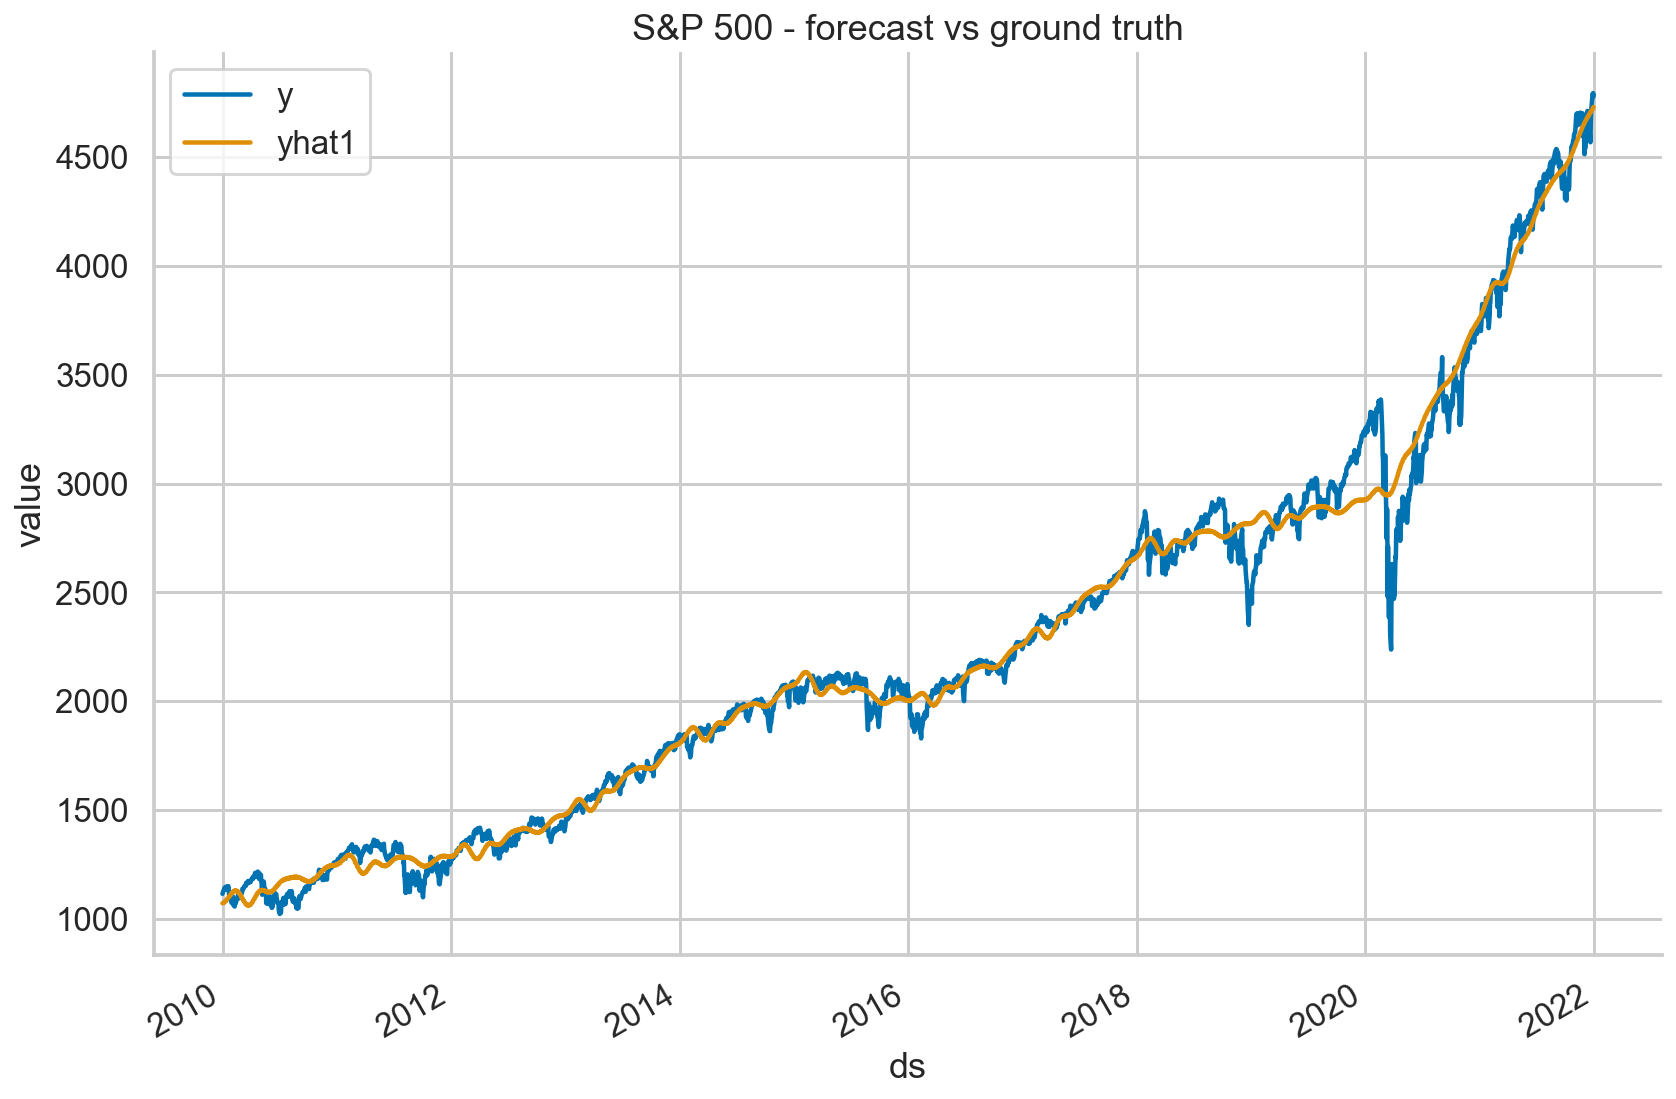

In [7]:
pred_df = model.predict(df)

pred_df.plot(x="ds", y=["y", "yhat1"], 
             title="S&P 500 - forecast vs ground truth",
             ylabel="value");

plt.tight_layout()
sns.despine()
# plt.savefig("이미지/피규어_15_17")

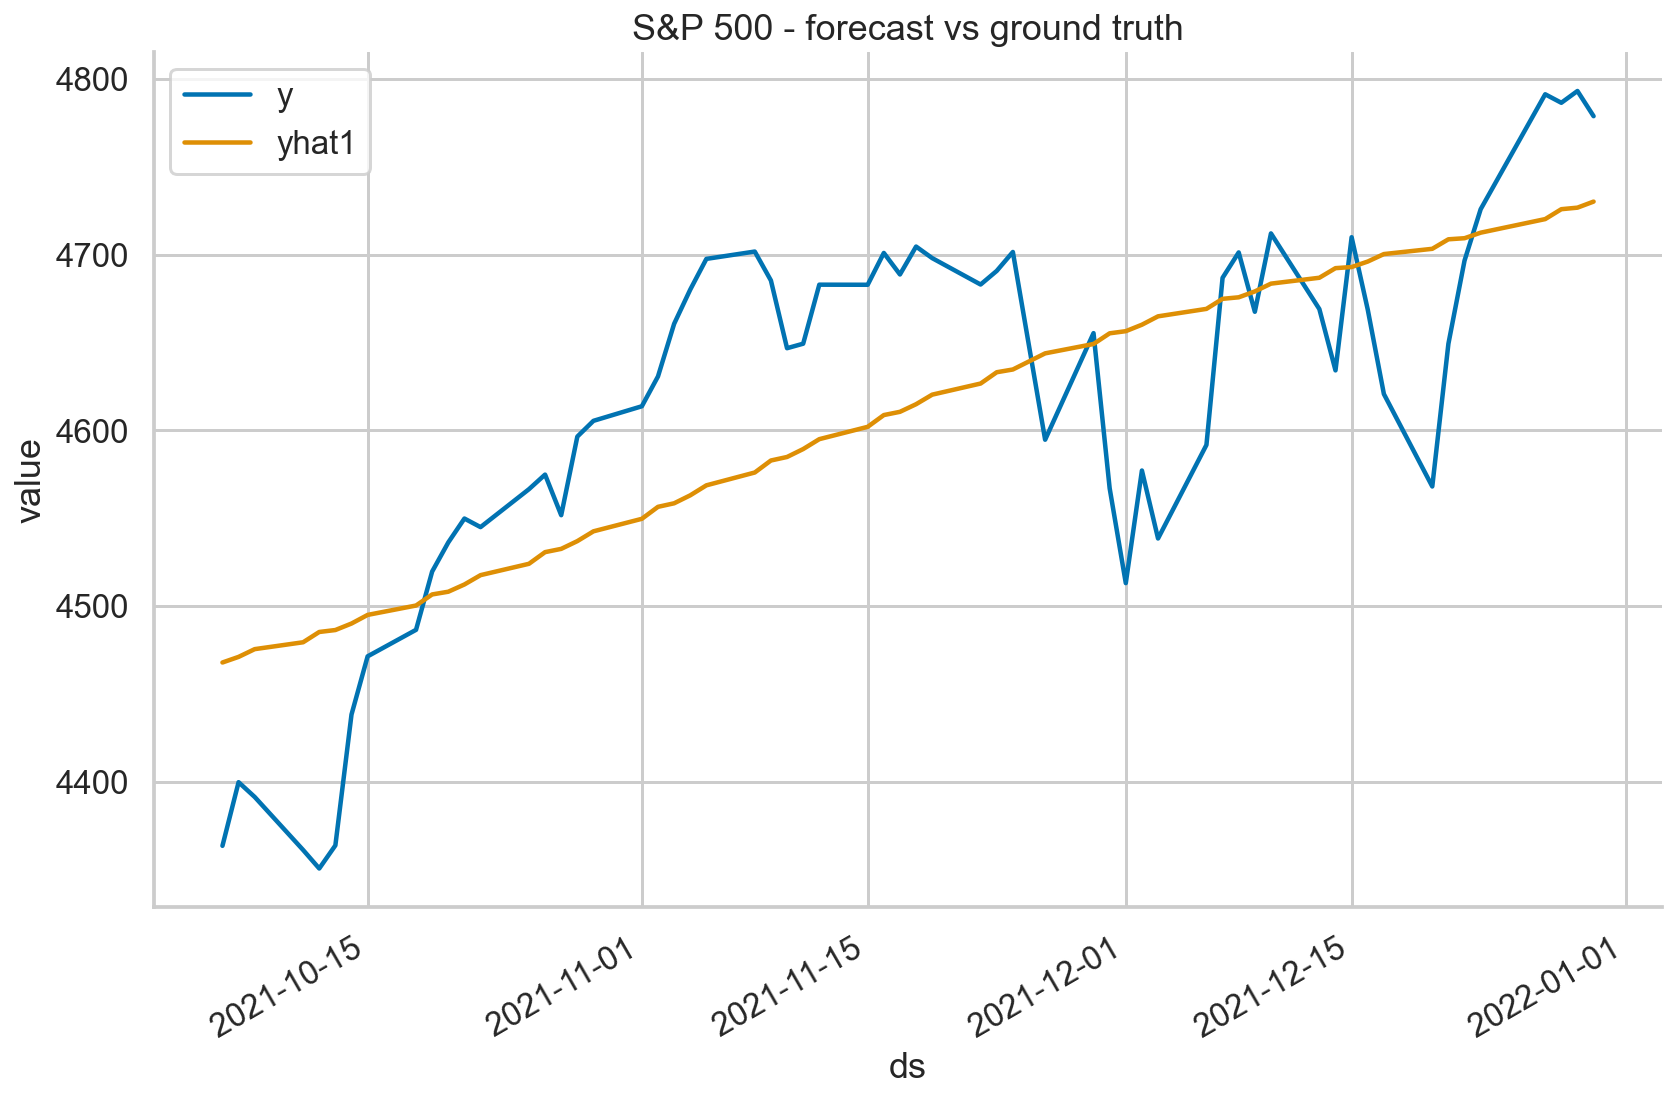

In [8]:
(
    pred_df
    .iloc[-TEST_LENGTH:]
    .plot(x="ds", y=["y", "yhat1"], 
          title="S&P 500 - forecast vs ground truth",
          ylabel="value")
);

plt.tight_layout()
sns.despine()
# plt.savefig("이미지/피규어_15_18")

In [9]:
model.test(df_test)

SmoothL1Loss        MAE       RMSE
0      0.000336  65.007812  74.876572

6. NeuralProphet에 AR 구성 요소를 추가합니다.

100%|██████████| 137/137 [00:00<00:00, 904.97it/s]


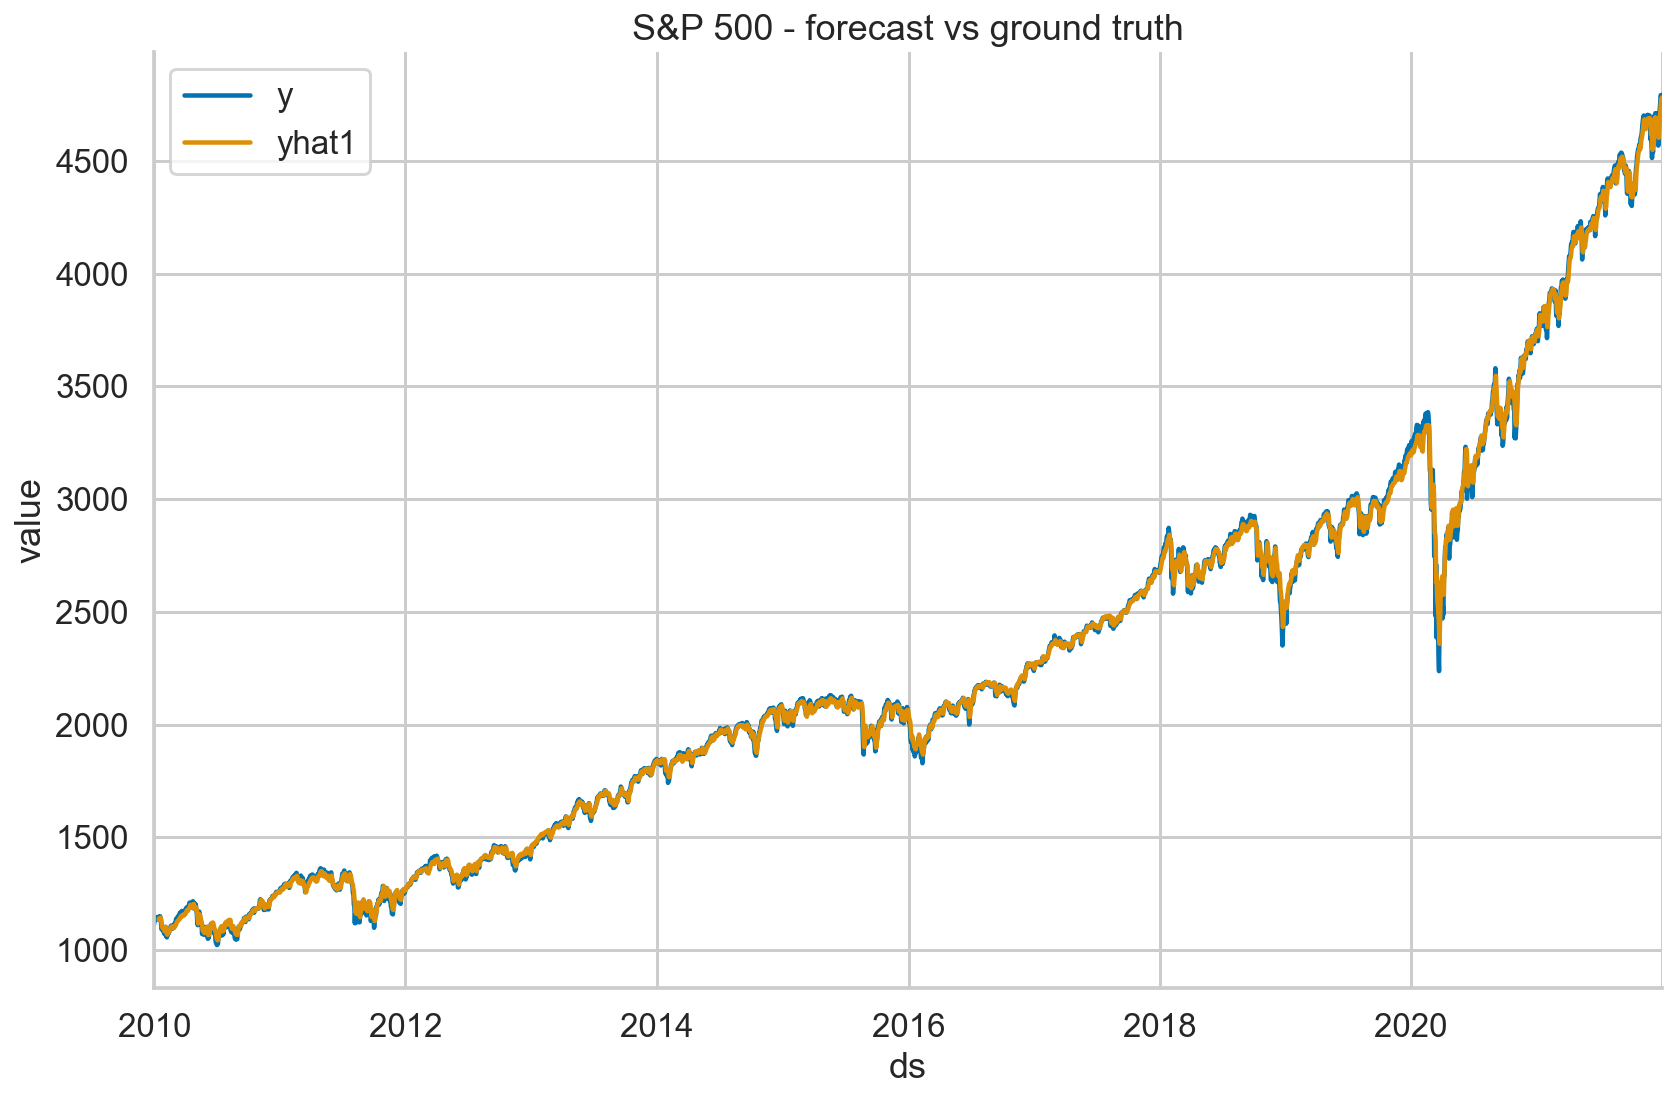

In [10]:
set_random_seed(42)
set_log_level(log_level="ERROR")
model = NeuralProphet(
    changepoints_range=0.95,
    n_lags=10,
    ar_reg=1,
)
metrics = model.fit(df_train, freq="B")

pred_df = model.predict(df)
pred_df.plot(x="ds", y=["y", "yhat1"], 
             title="S&P 500 - forecast vs ground truth",
             ylabel="value");

plt.tight_layout()
sns.despine()
# plt.savefig("이미지/피규어_15_19")

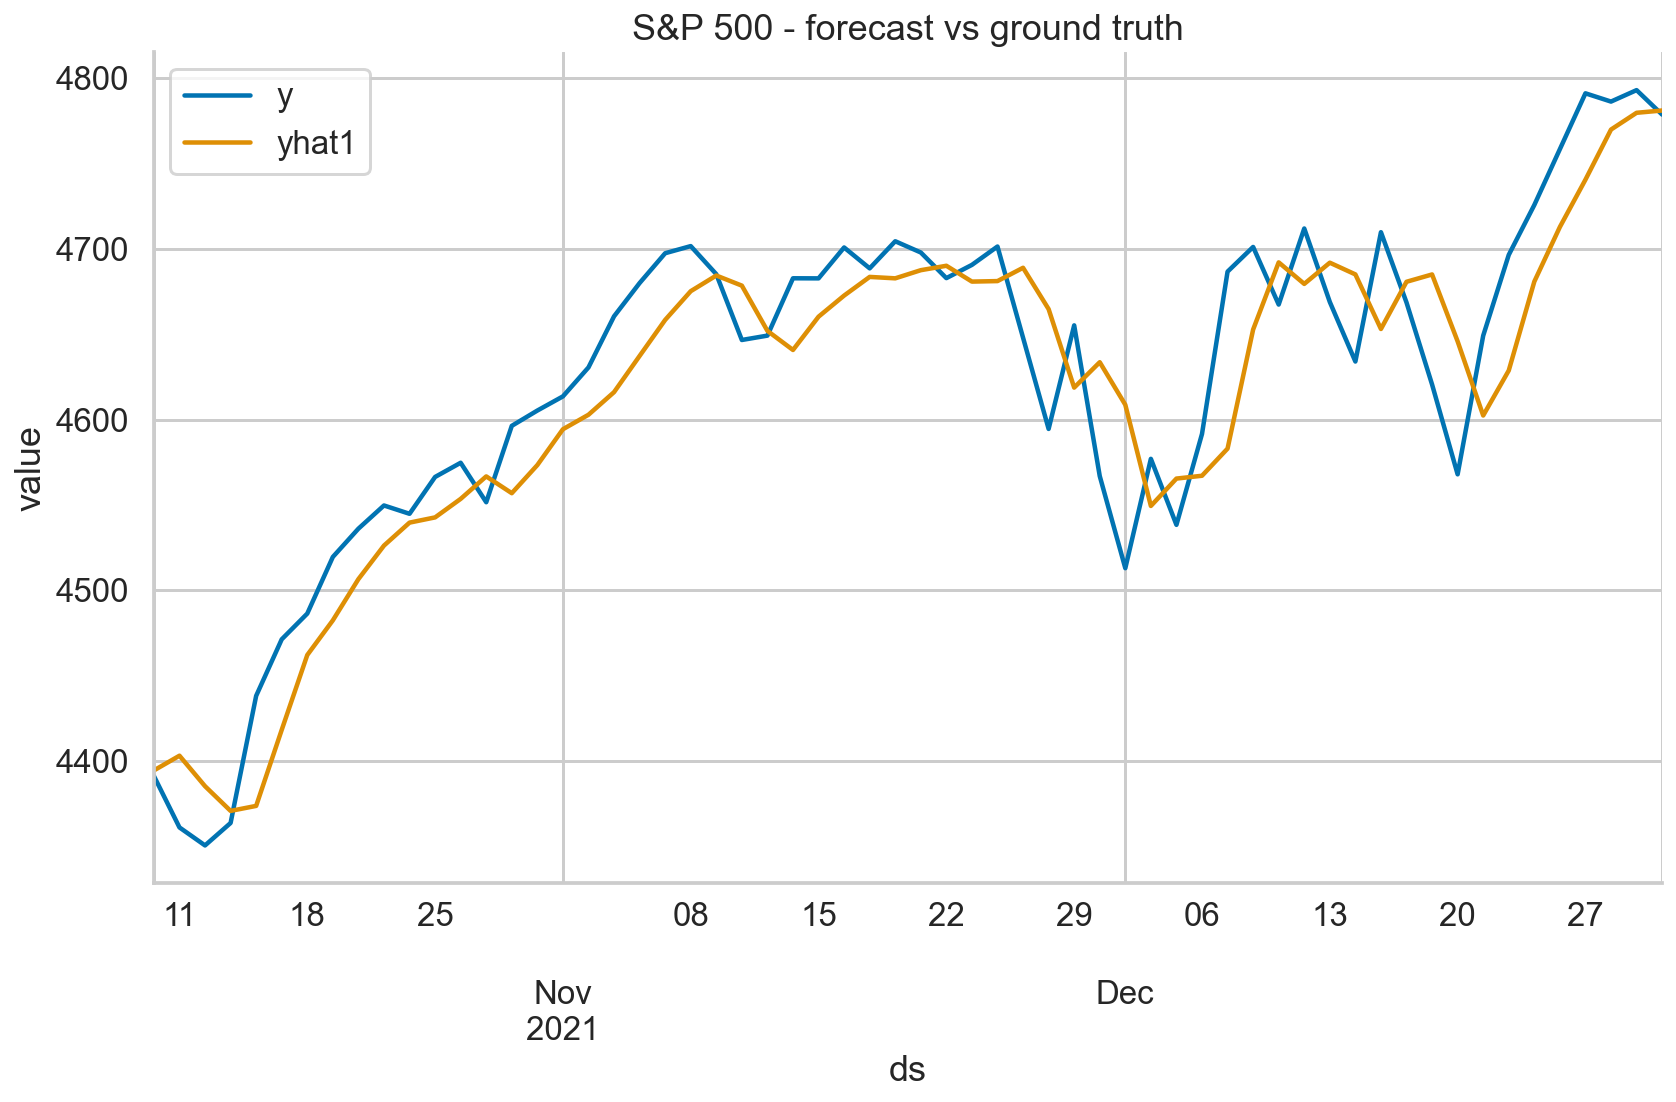

In [11]:
(
    pred_df
    .iloc[-TEST_LENGTH:]
    .plot(x="ds", y=["y", "yhat1"], 
          title="S&P 500 - forecast vs ground truth",
          ylabel="value")
);

plt.tight_layout()
sns.despine()
# plt.savefig("이미지/피규어_15_20")

7. NeuralProphet에 AR-Net 추가:

 82%|████████▏ | 113/137 [00:00<00:00, 559.38it/s]


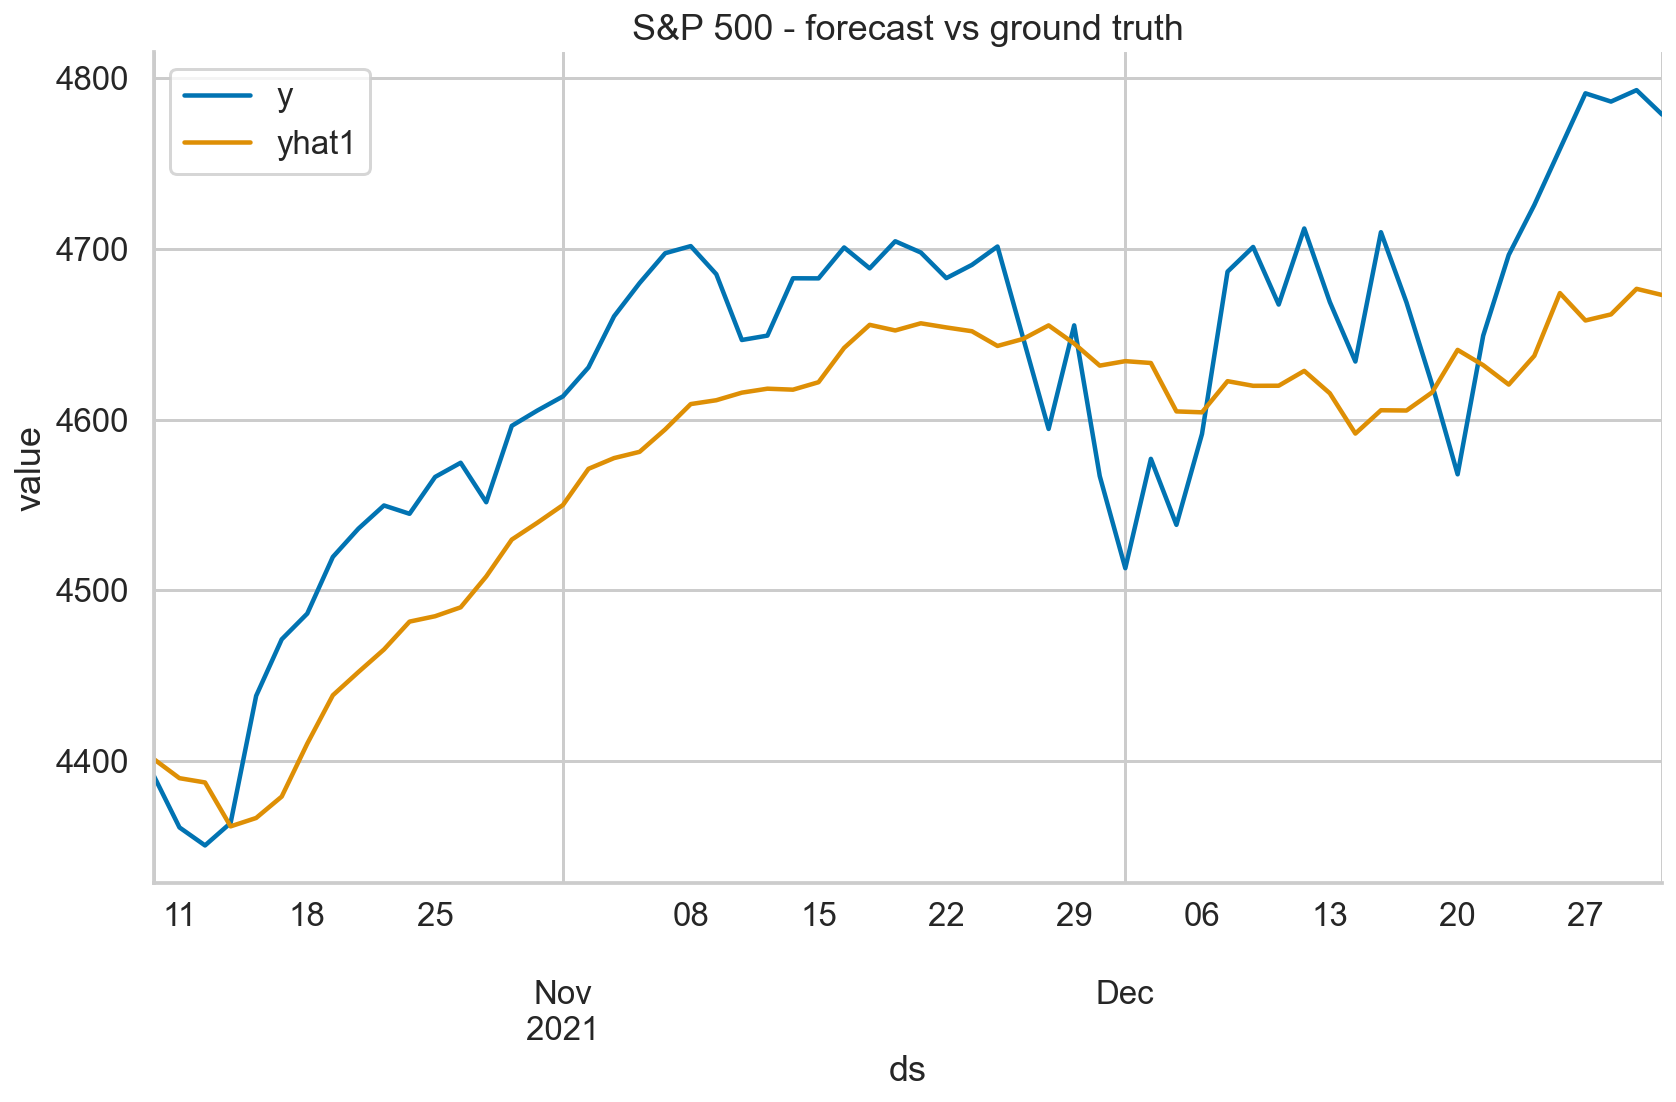

In [12]:
set_random_seed(42)
set_log_level(log_level="ERROR")
model = NeuralProphet(
    changepoints_range=0.95,
    n_lags=10,
    ar_reg=1,
    num_hidden_layers=3,
    d_hidden=32,
)
metrics = model.fit(df_train, freq="B")

pred_df = model.predict(df)

(
    pred_df
    .iloc[-TEST_LENGTH:]
    .plot(x="ds", y=["y", "yhat1"], 
          title="S&P 500 - forecast vs ground truth",
          ylabel="value")
);

plt.tight_layout()
sns.despine()
# plt.savefig("이미지/피규어_15_21")

In [13]:
model.test(df_test)

SmoothL1Loss        MAE       RMSE
0      0.000311  65.459953  72.100792

8. 모델의 구성 요소와 매개변수를 플로팅합니다.

In [14]:
# AR 플롯에 문제가 있으므로 플로팅 전용입니다.
# 구성요소를 플로팅한 후 Notebook 상단의 설정으로 되돌릴 수 있습니다.
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

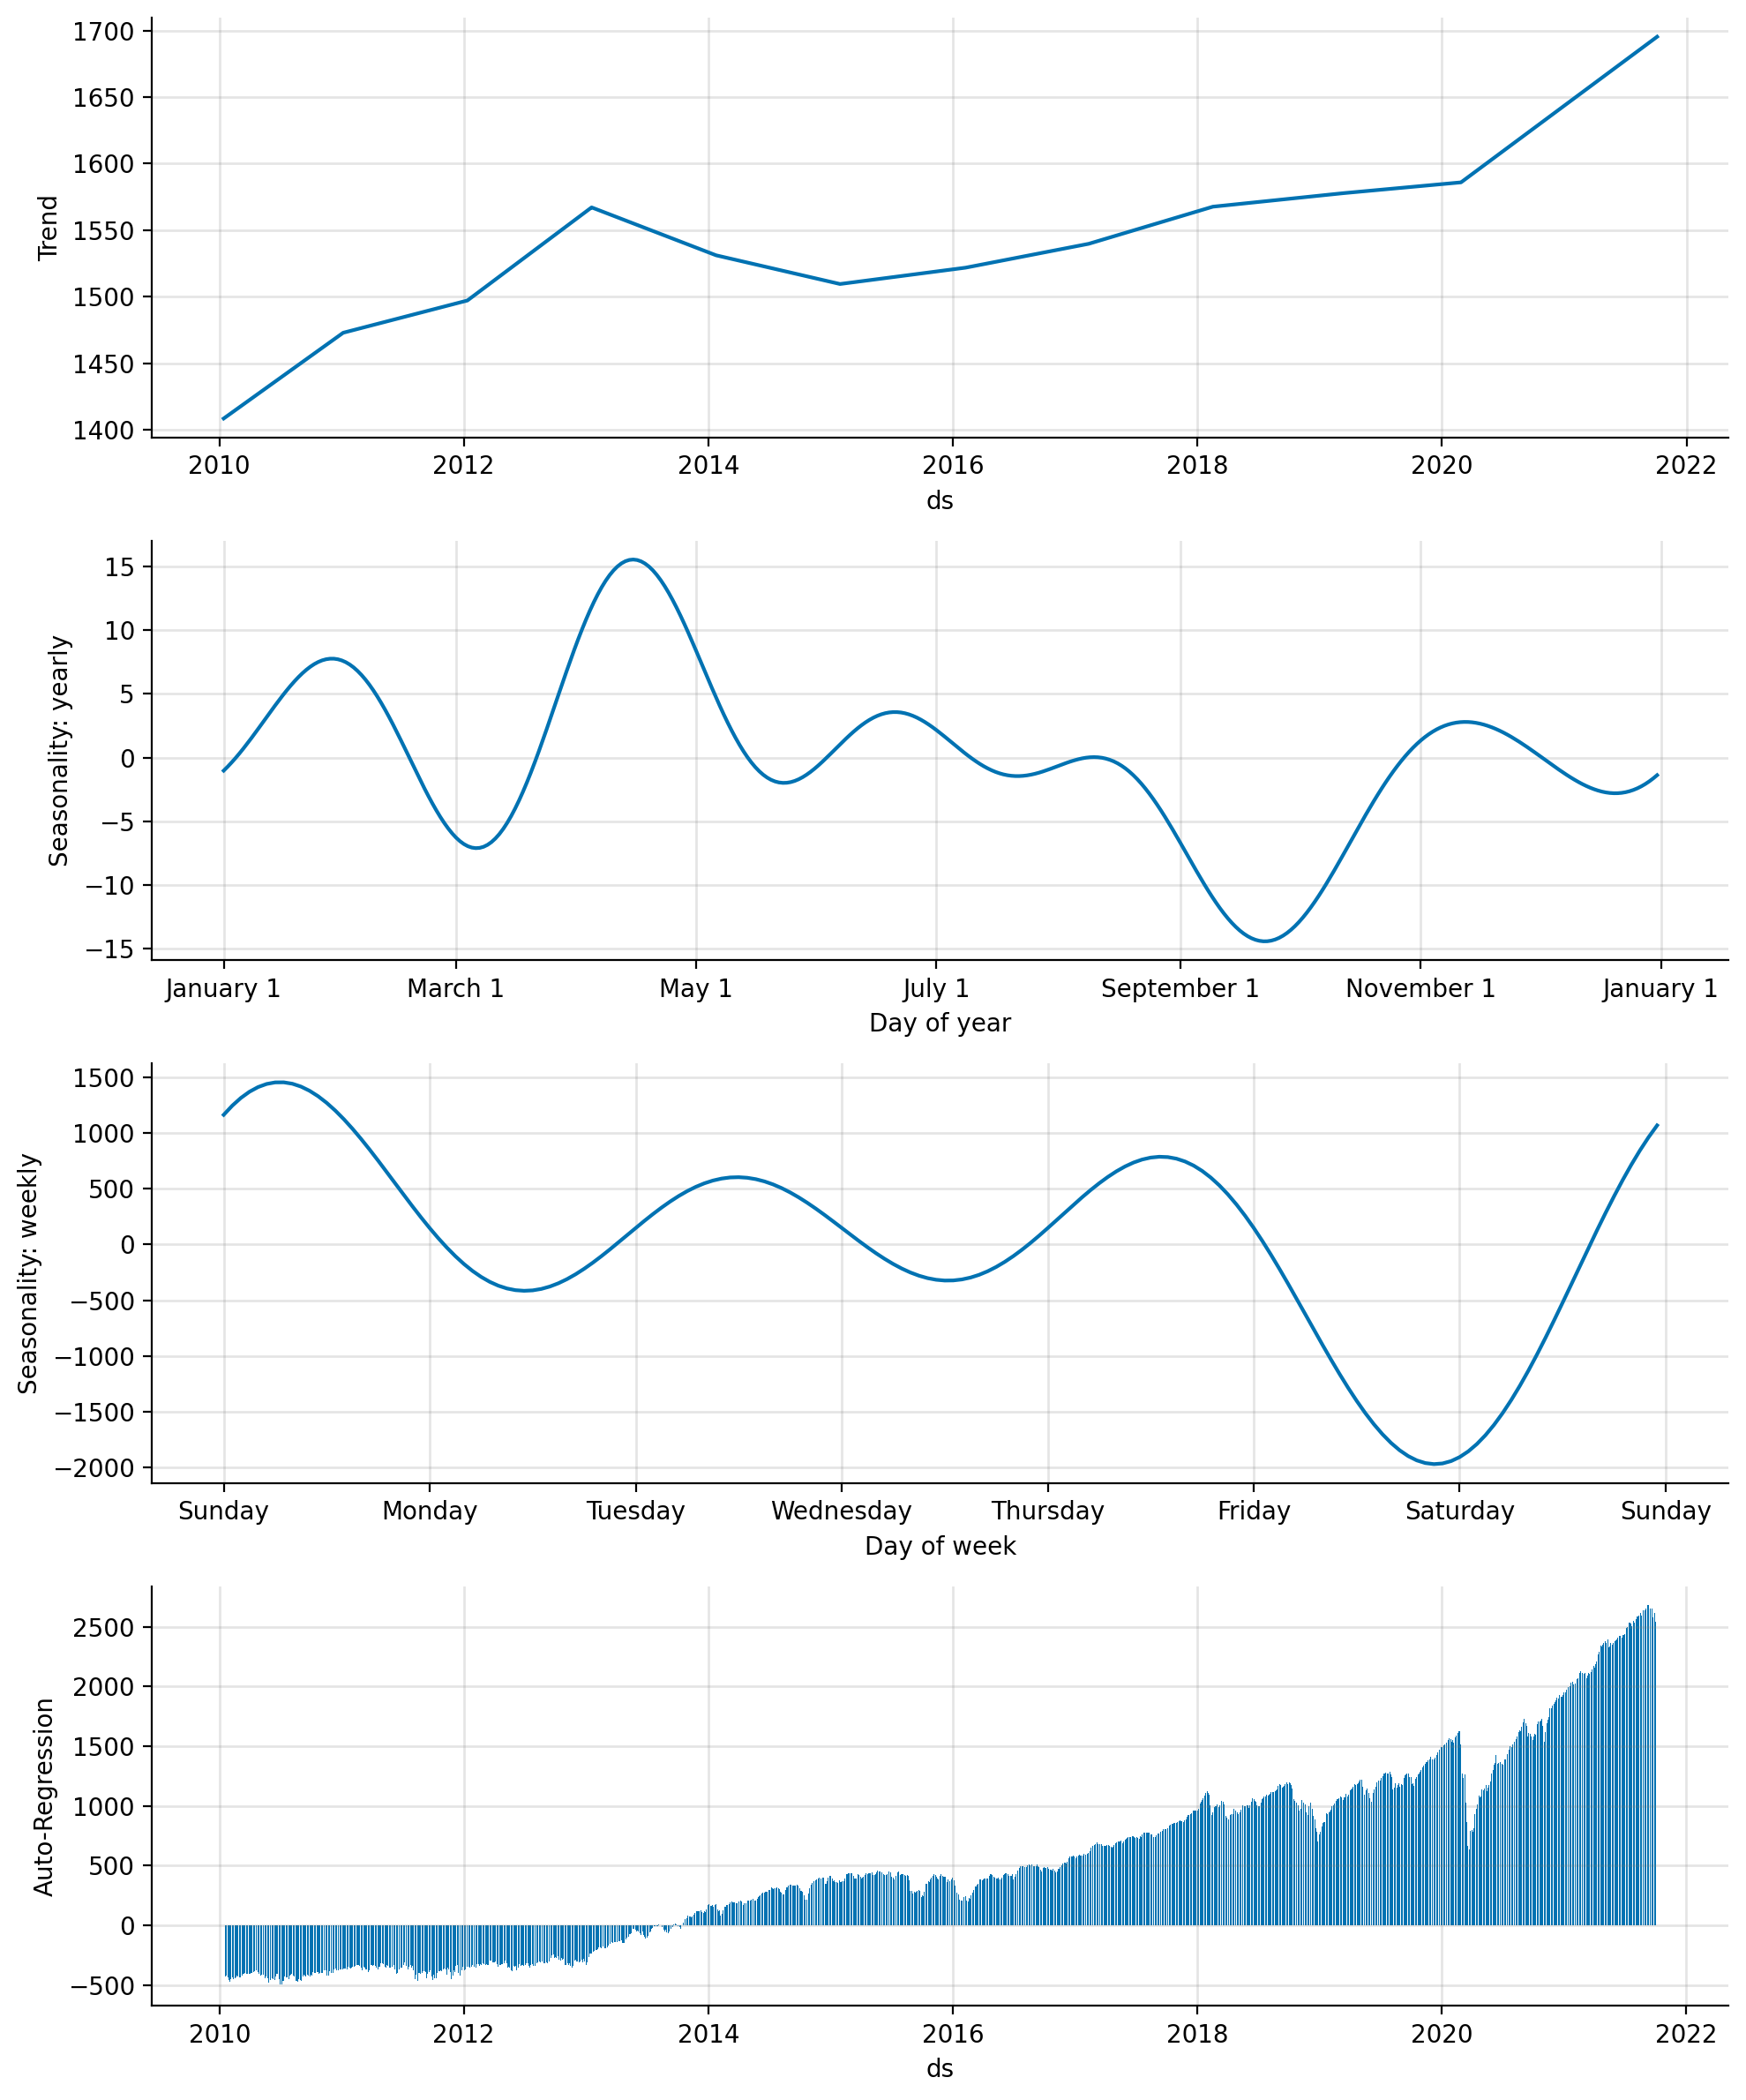

In [15]:
model.plot_components(model.predict(df_train));

plt.tight_layout()
sns.despine()
# plt.savefig("이미지/피규어_15_22")

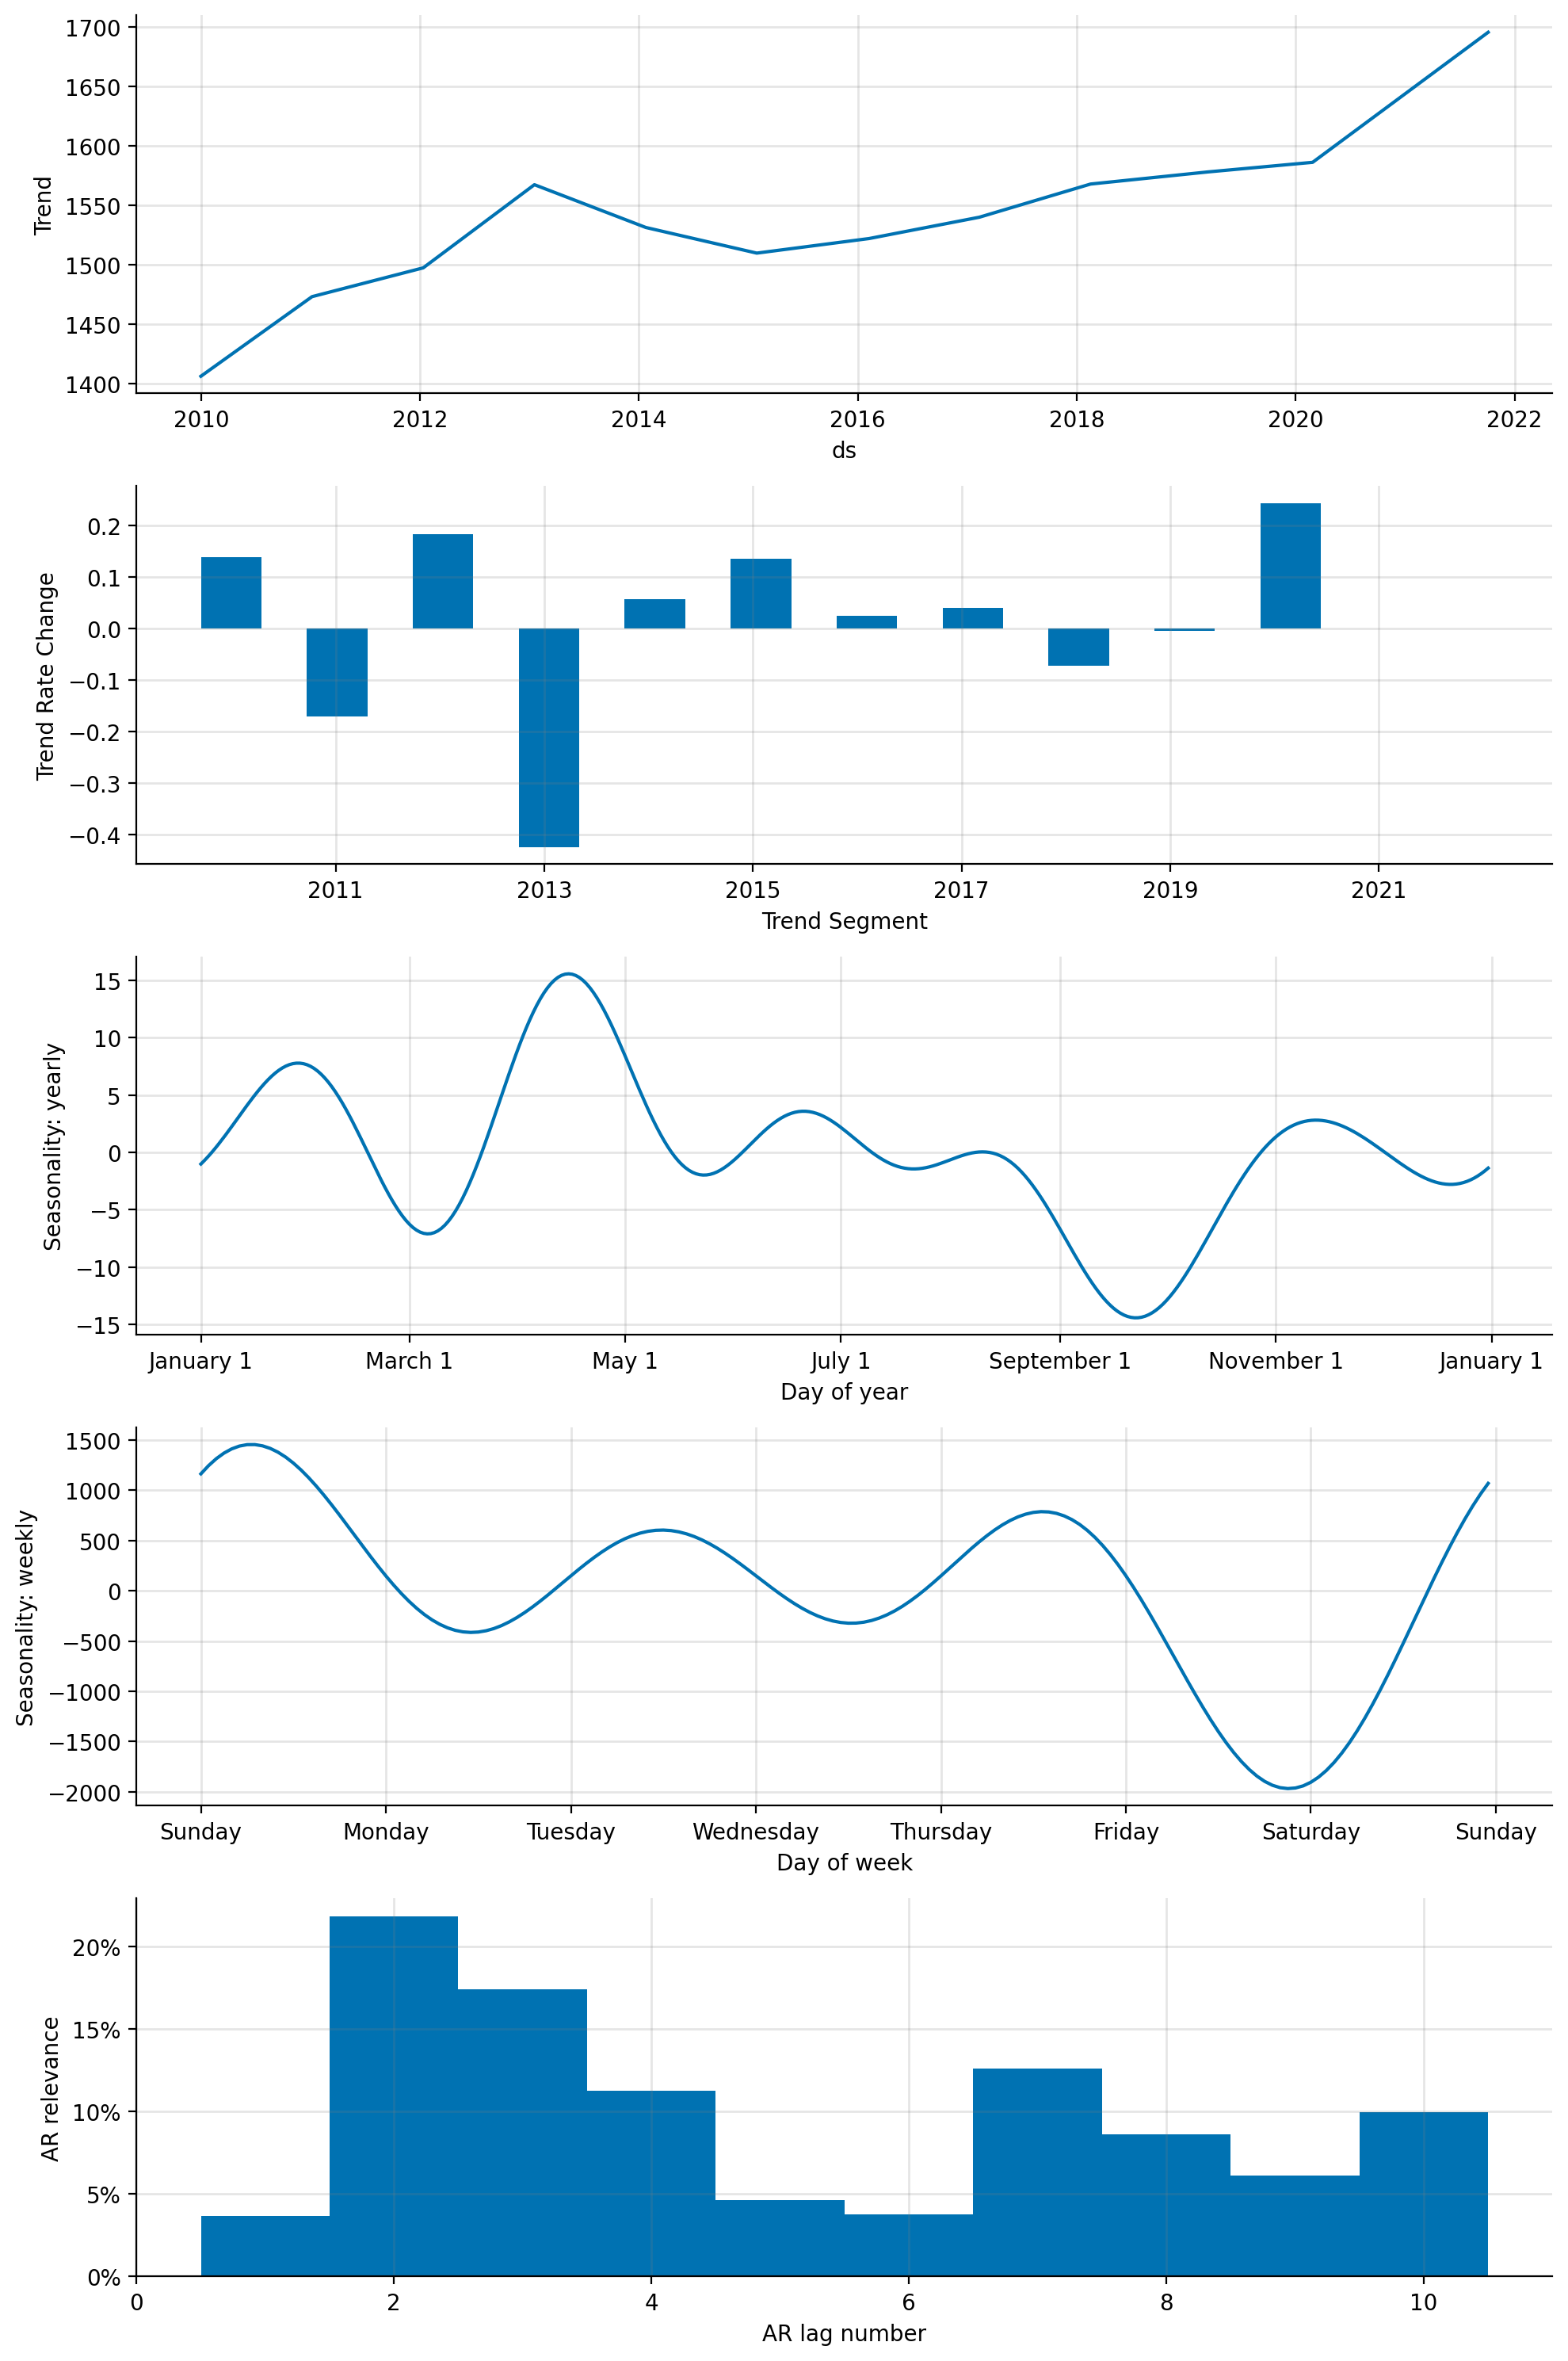

In [16]:
model.plot_parameters();

plt.tight_layout()
sns.despine()
# plt.savefig("이미지/피규어_15_23")

### 더 많은 것이 있습니다

1. 모델에 휴일을 추가합니다.

In [17]:
set_random_seed(42)
set_log_level(log_level="ERROR")
model = NeuralProphet(
    changepoints_range=0.95,
    n_lags=10,
    ar_reg=1,
    num_hidden_layers=3,
    d_hidden=32,
)

model = model.add_country_holidays(
    "US", lower_window=-1, upper_window=1
)
metrics = model.fit(df_train, freq="B")

100%|██████████| 137/137 [00:00<00:00, 637.01it/s]


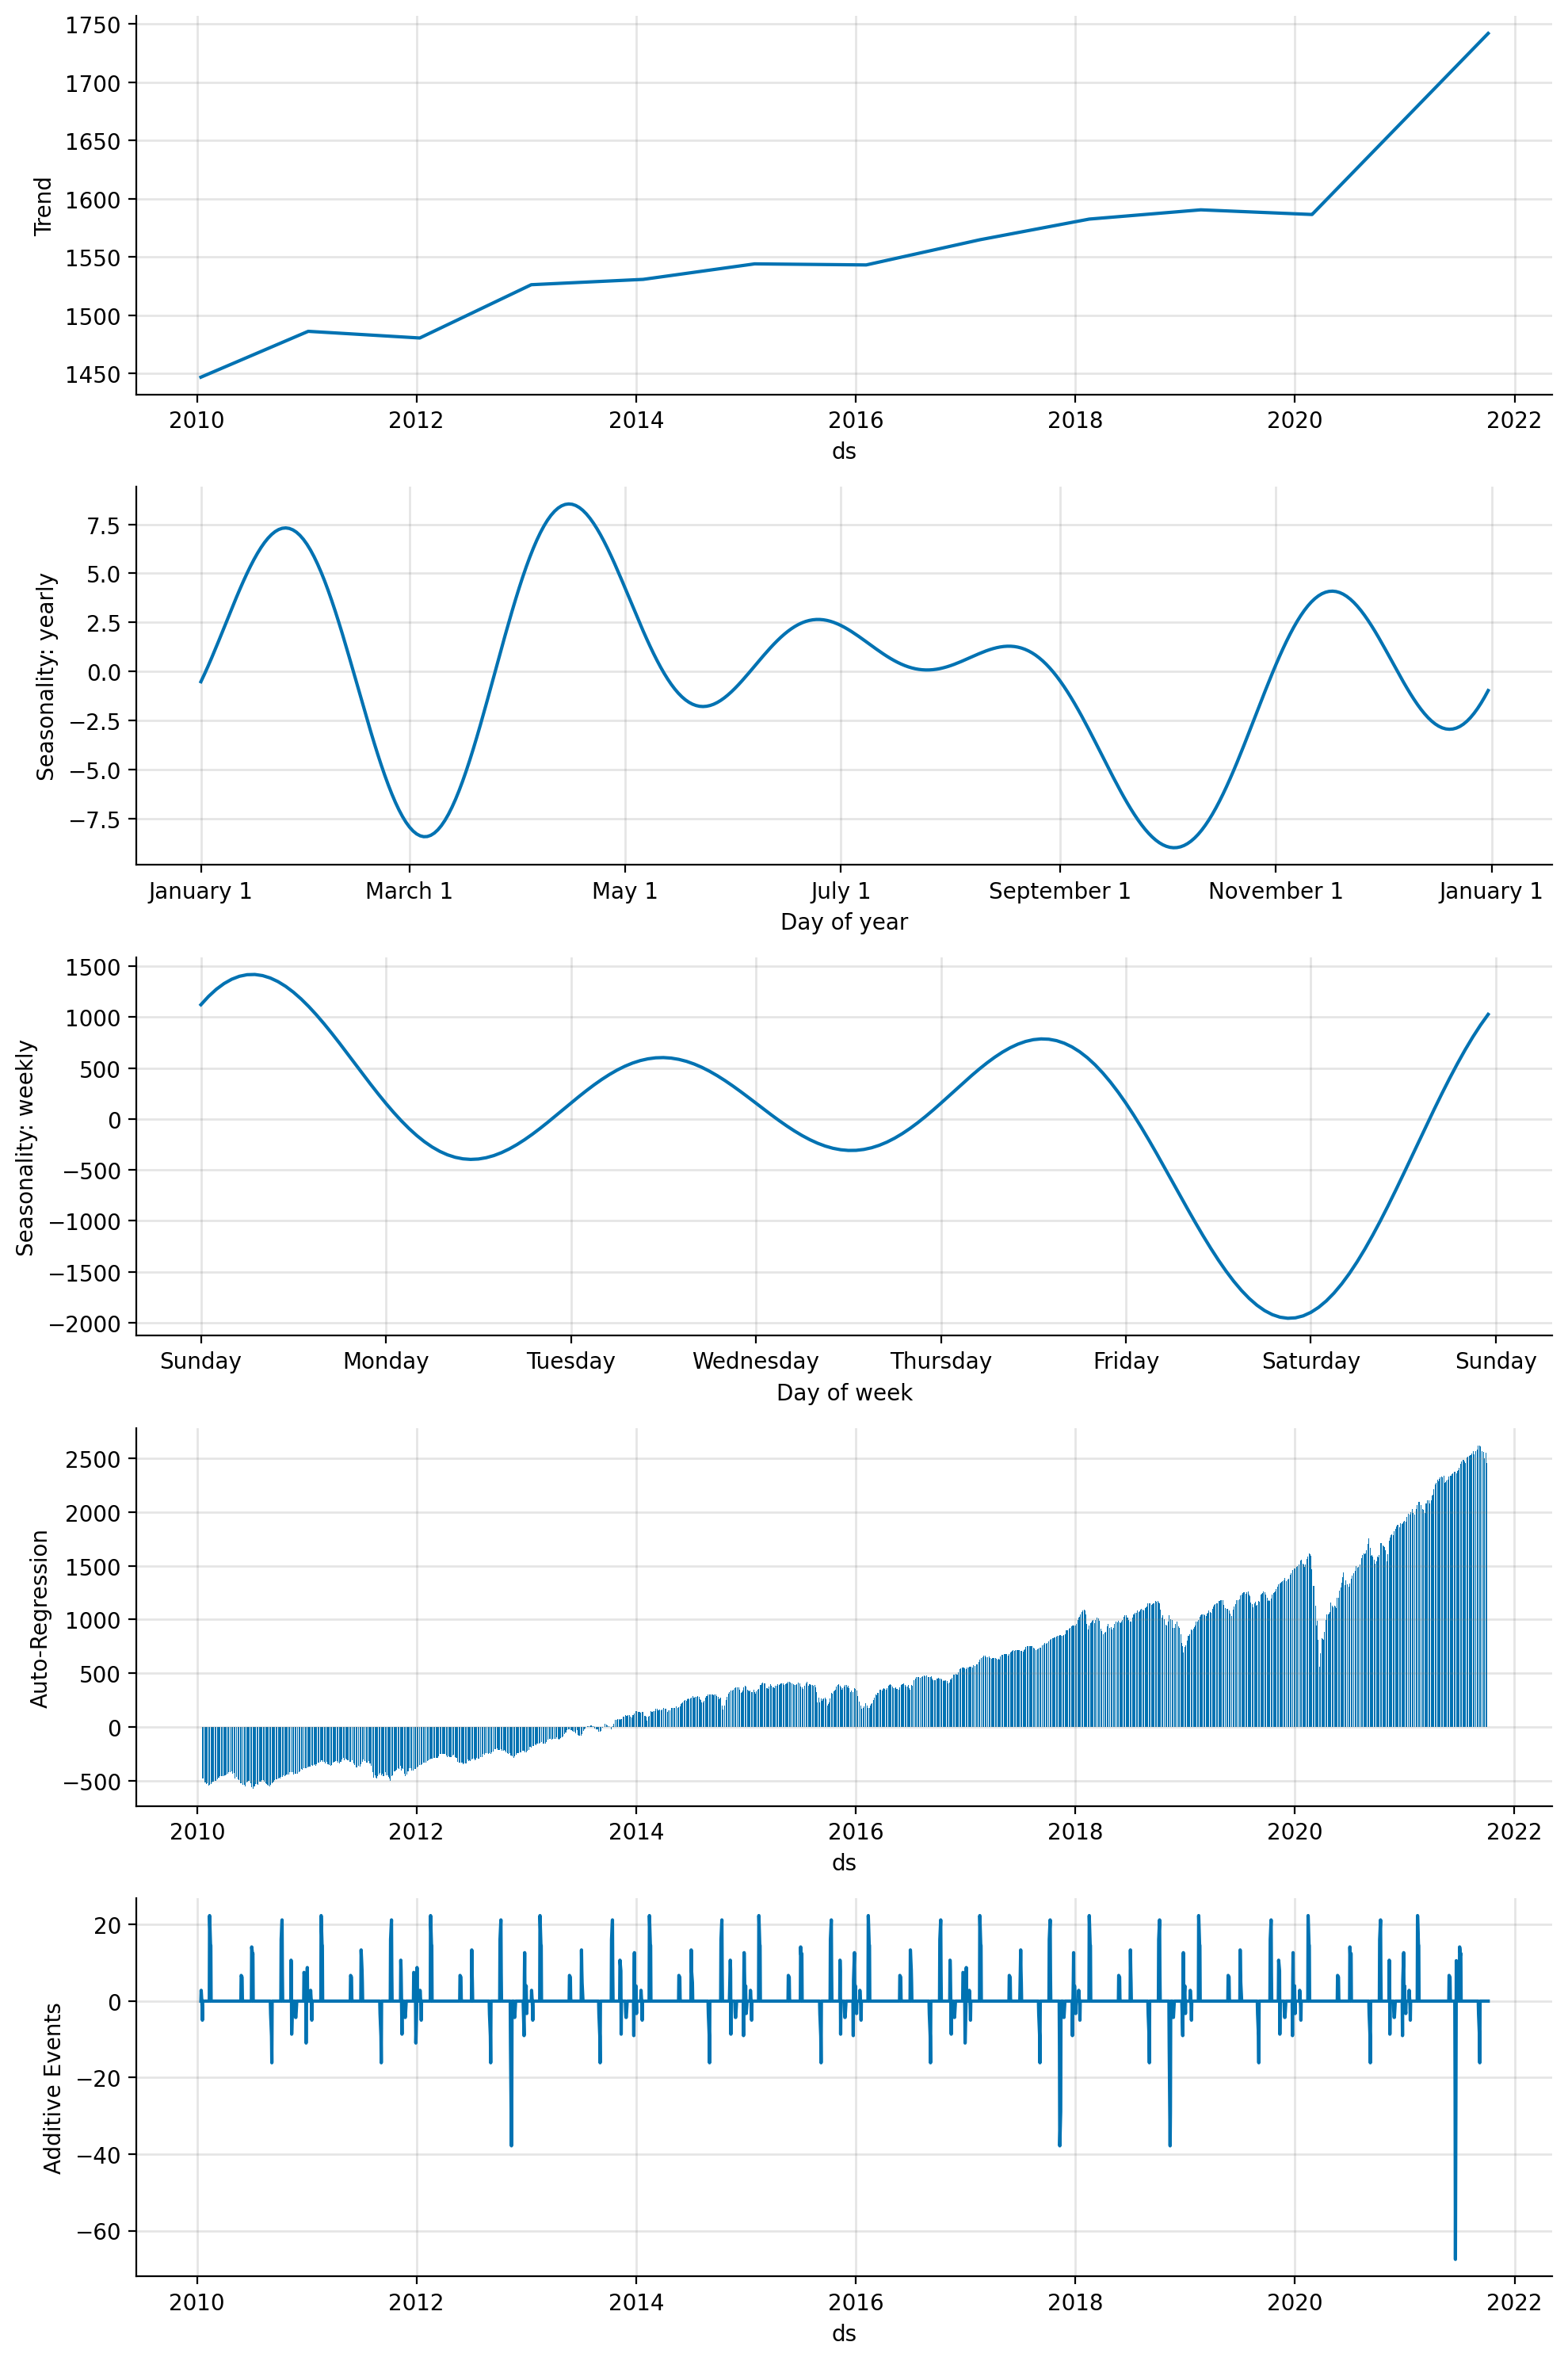

In [18]:
pred_df = model.predict(df_train)
model.plot_components(pred_df)

plt.tight_layout()
sns.despine()
# plt.savefig("이미지/피규어_15_24")

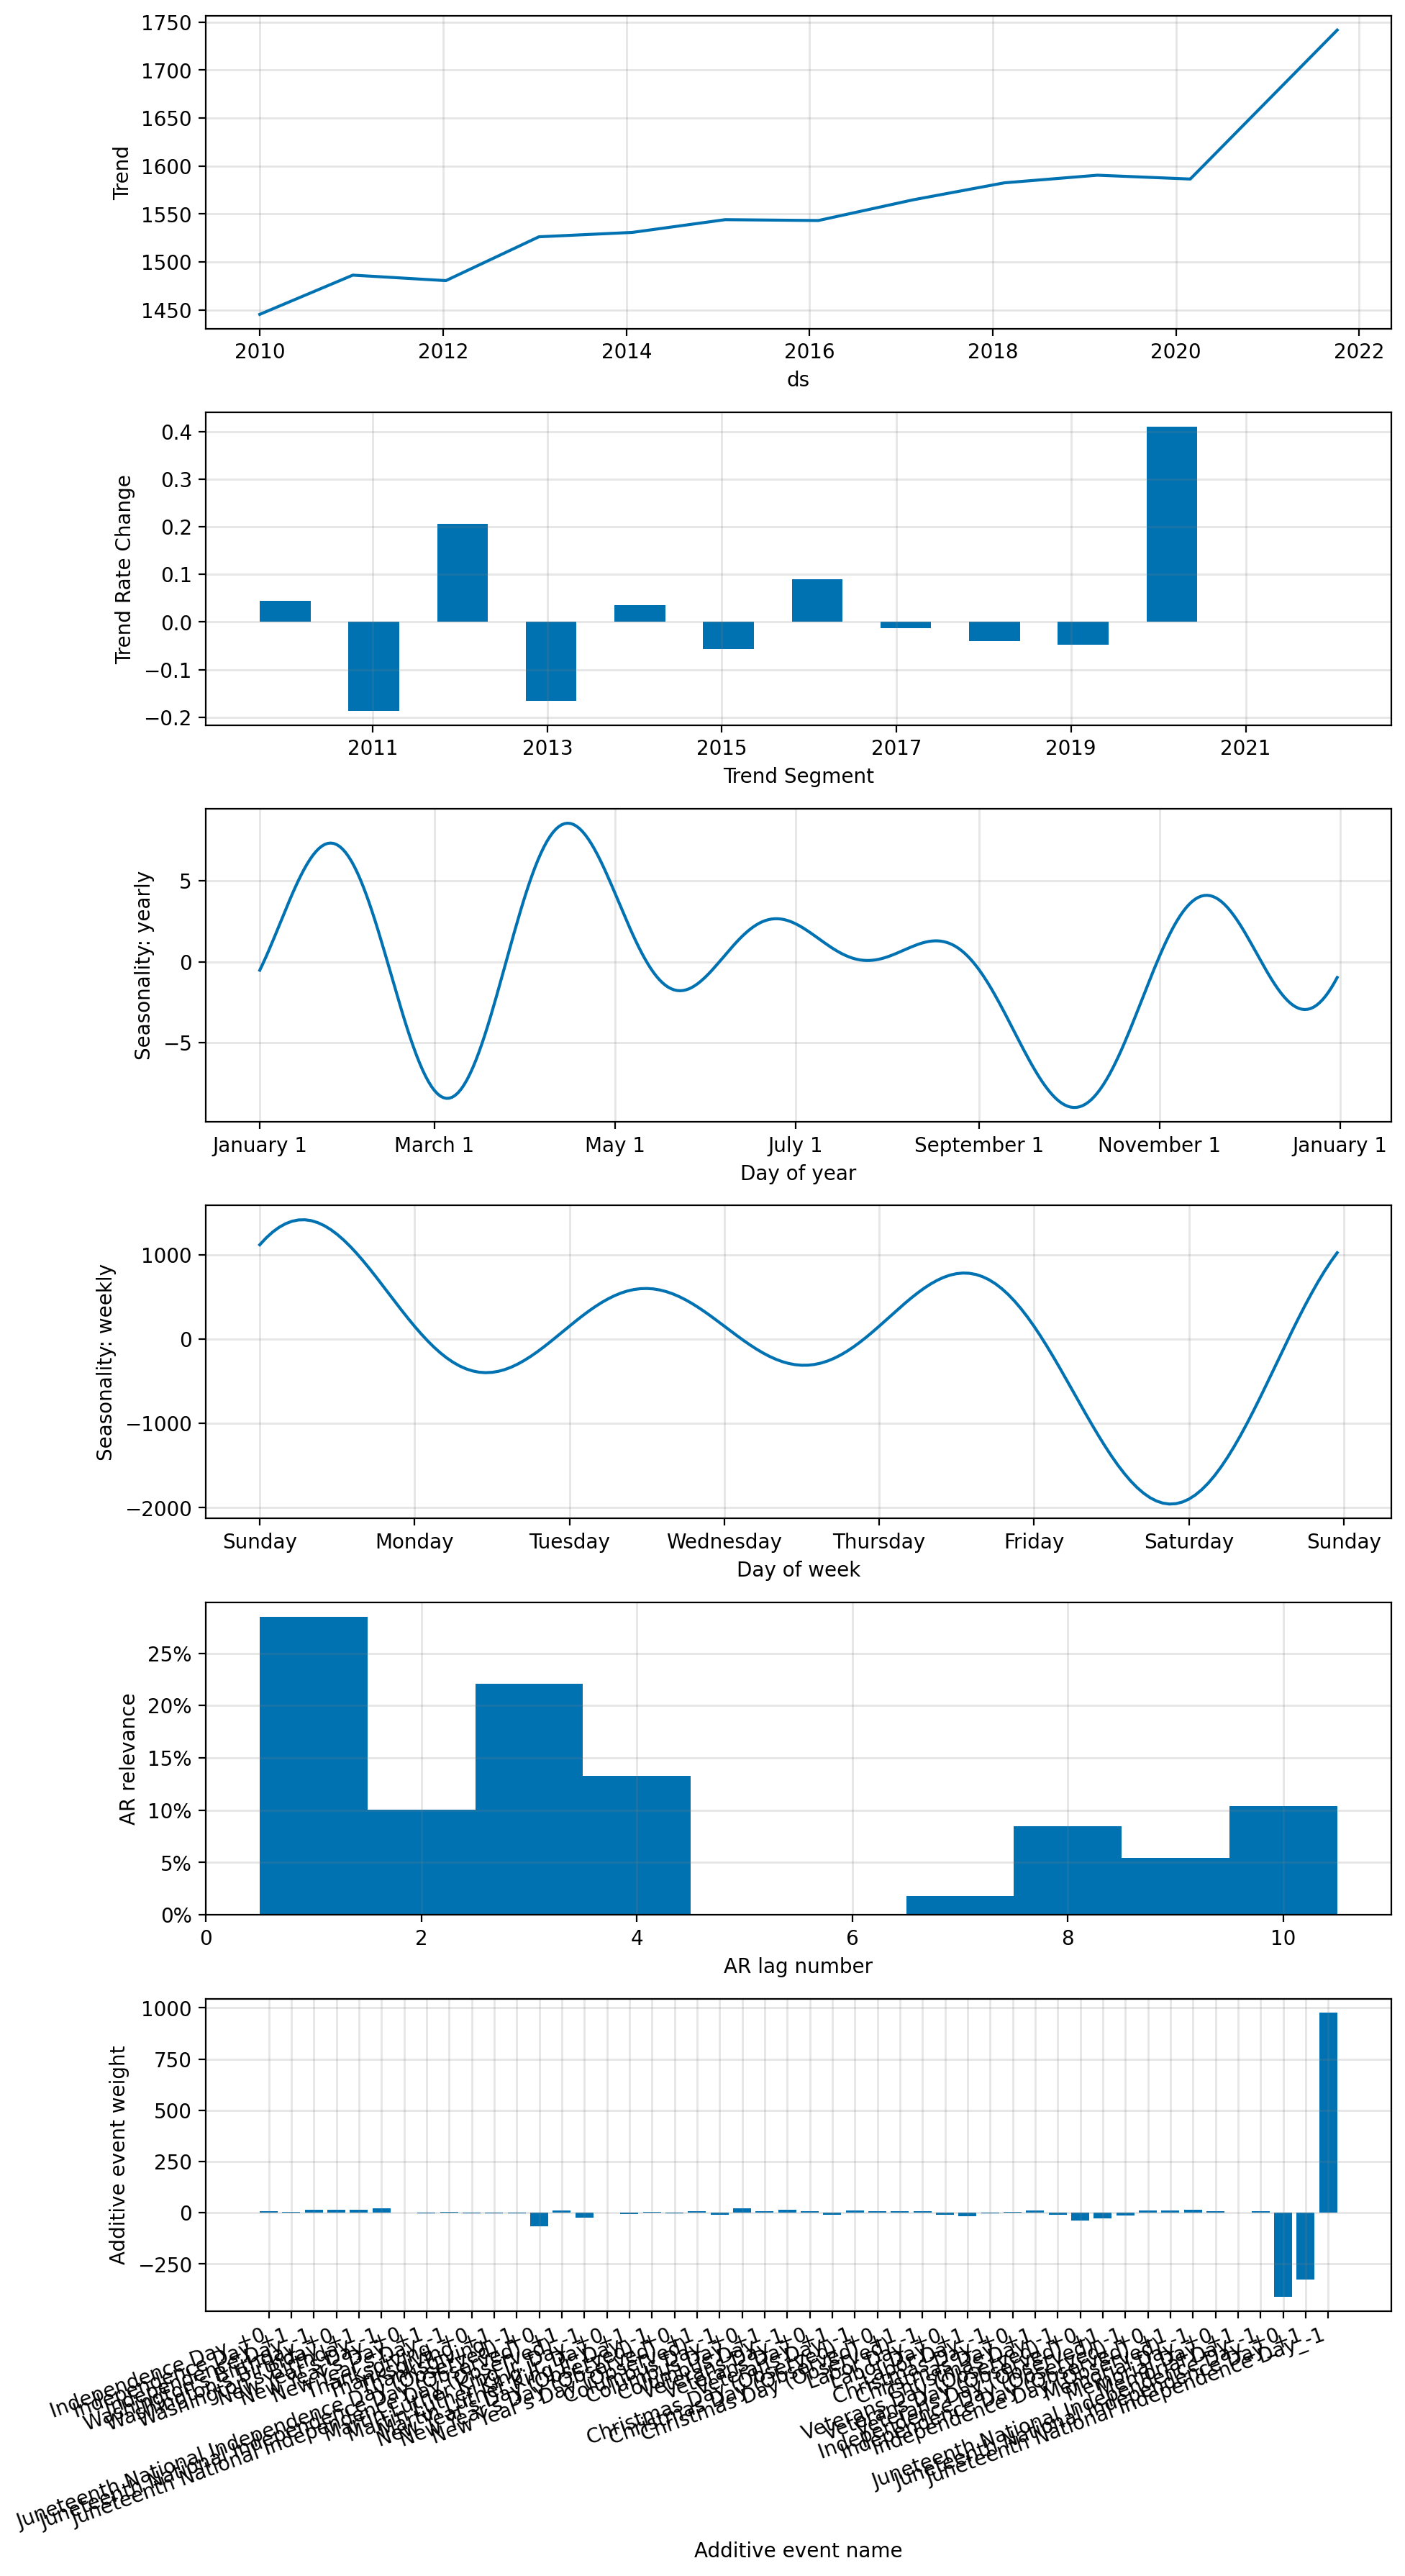

In [19]:
model.plot_parameters();

2. 10일 전의 다단계 예측을 만듭니다.

In [13]:
set_random_seed(42)
set_log_level(log_level="ERROR")
model = NeuralProphet(
    n_lags=10,
    n_forecasts=10,
    ar_reg=1,
    learning_rate=0.01
)
metrics = model.fit(df_train, freq="B")
pred_df = model.predict(df)
pred_df.tail()

ds            y        yhat1   residual1        yhat2  \
3126 2021-12-24  4758.489990  4650.537109 -107.952881  4658.835938   
3127 2021-12-27  4791.189941  4678.010742 -113.179199  4684.404785   
3128 2021-12-28  4786.350098  4733.727051  -52.623047  4726.821777   
3129 2021-12-29  4793.060059  4743.061035  -49.999023  4752.594238   
3130 2021-12-30  4778.729980  4739.231934  -39.498047  4743.820801   

       residual2        yhat3   residual3        yhat4   residual4  ...  \
3126  -99.654053  4628.593262 -129.896729  4628.078125 -130.411865  ...   
3127 -106.785156  4667.214355 -123.975586  4644.814941    -146.375  ...   
3128   -59.52832  4719.004395  -67.345703  4654.171875 -132.178223  ...   
3129   -40.46582  4732.162598  -60.897461  4711.364746  -81.695312  ...   
3130   -34.90918  4716.883789  -61.846191  4736.578125  -42.151855  ...   

              ar4          ar5          ar6          ar7          ar8  \
3126  3135.196533  3184.866943  3190.829102  3203.072998  3161.448975   
3127    3152.4646  3068.444092  3219.397217  3183.488525  3173.246338   
3128  3160.530518  3120.293457  3135.982178  3160.213867  3240.533203   
3129  3217.064453   3193.08374  3127.438965  3115.985596  3198.358643   
3130  3242.431152  3233.673828  3179.129639  3142.590088  3121.921387   

              ar9         ar10        trend season_yearly season_weekly  
3126  3186.029541  3196.741699   1177.05127     -3.653834    319.484009  
3127  3146.842773  3235.819336  1177.903931     -3.819474    318.265717  
3128  3186.236328  3165.561279   1178.18811     -3.757542    319.211151  
3129  3185.796875  3191.491699  1178.472412     -3.634705     319.46283  
3130  3162.443604  3235.914551  1178.756592     -3.450272    318.840424  

[5 rows x 35 columns]

In [14]:
# 랜덤_시드_설정(42)
pred_df = model.predict(df, raw=True, decompose=False)
pred_df.tail().round(2)

ds        step0        step1        step2        step3  \
3116 2021-12-24  4650.540039  4684.399902  4719.000000  4711.359863   
3117 2021-12-27  4678.009766  4726.819824  4732.160156  4736.580078   
3118 2021-12-28  4733.729980  4752.589844  4716.879883  4745.649902   
3119 2021-12-29  4743.060059  4743.819824  4702.350098  4733.750000   
3120 2021-12-30  4739.229980  4752.520020  4730.939941  4760.689941   

            step4        step5        step6        step7        step8  \
3116  4727.819824  4667.189941  4714.819824  4683.540039  4706.020020   
3117  4733.509766  4689.540039  4733.549805  4748.560059  4753.779785   
3118  4740.490234  4727.629883  4744.220215  4767.180176  4777.370117   
3119  4747.859863  4734.129883  4760.209961  4742.779785  4779.910156   
3120  4776.040039  4763.520020  4772.279785  4735.459961  4766.009766   

            step9  
3116  4724.060059  
3117  4767.770020  
3118  4781.660156  
3119  4803.180176  
3120  4802.129883

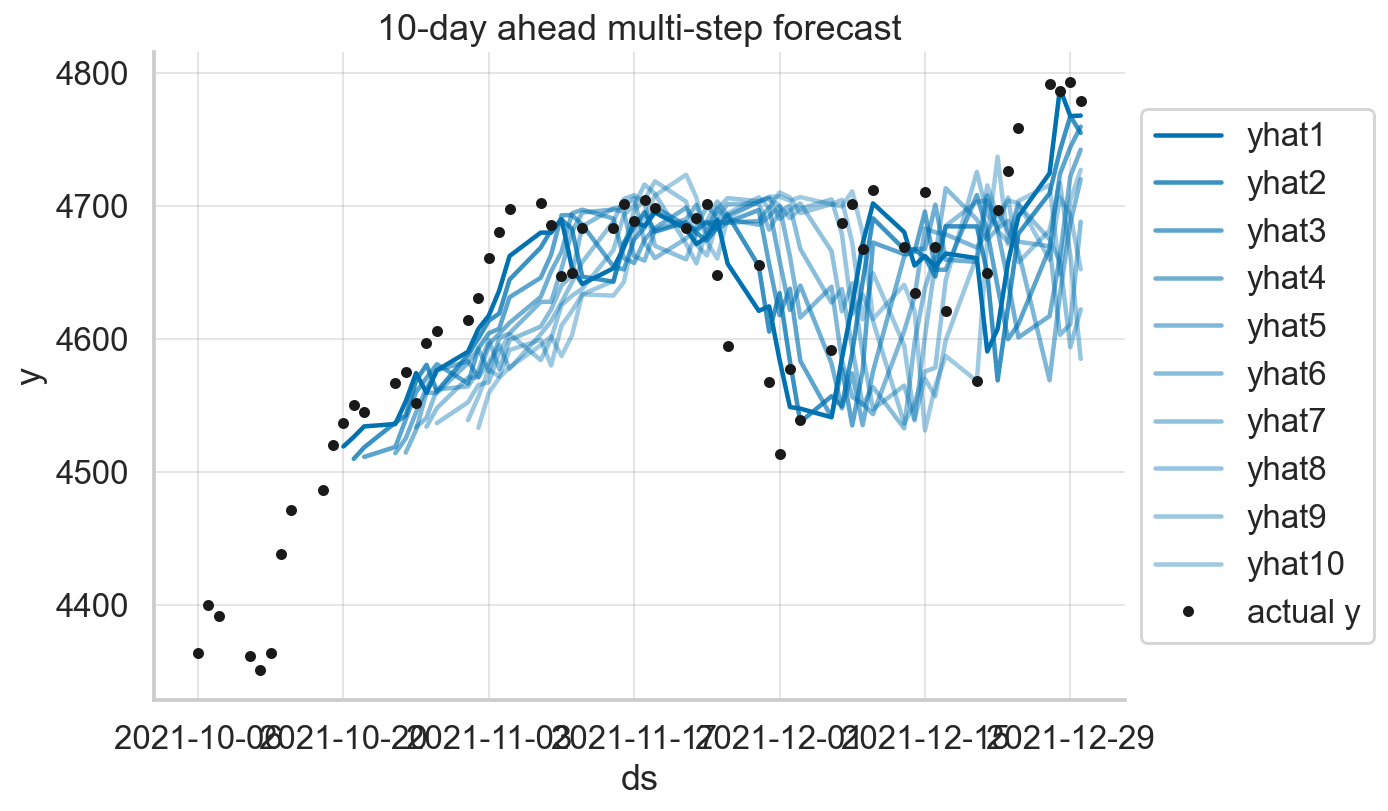

In [10]:
pred_df = model.predict(df_test)
model.plot(pred_df)
ax = plt.gca()
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_title("10-day ahead multi-step forecast")

plt.tight_layout()
sns.despine()
# plt.savefig("이미지/피규어_15_27")

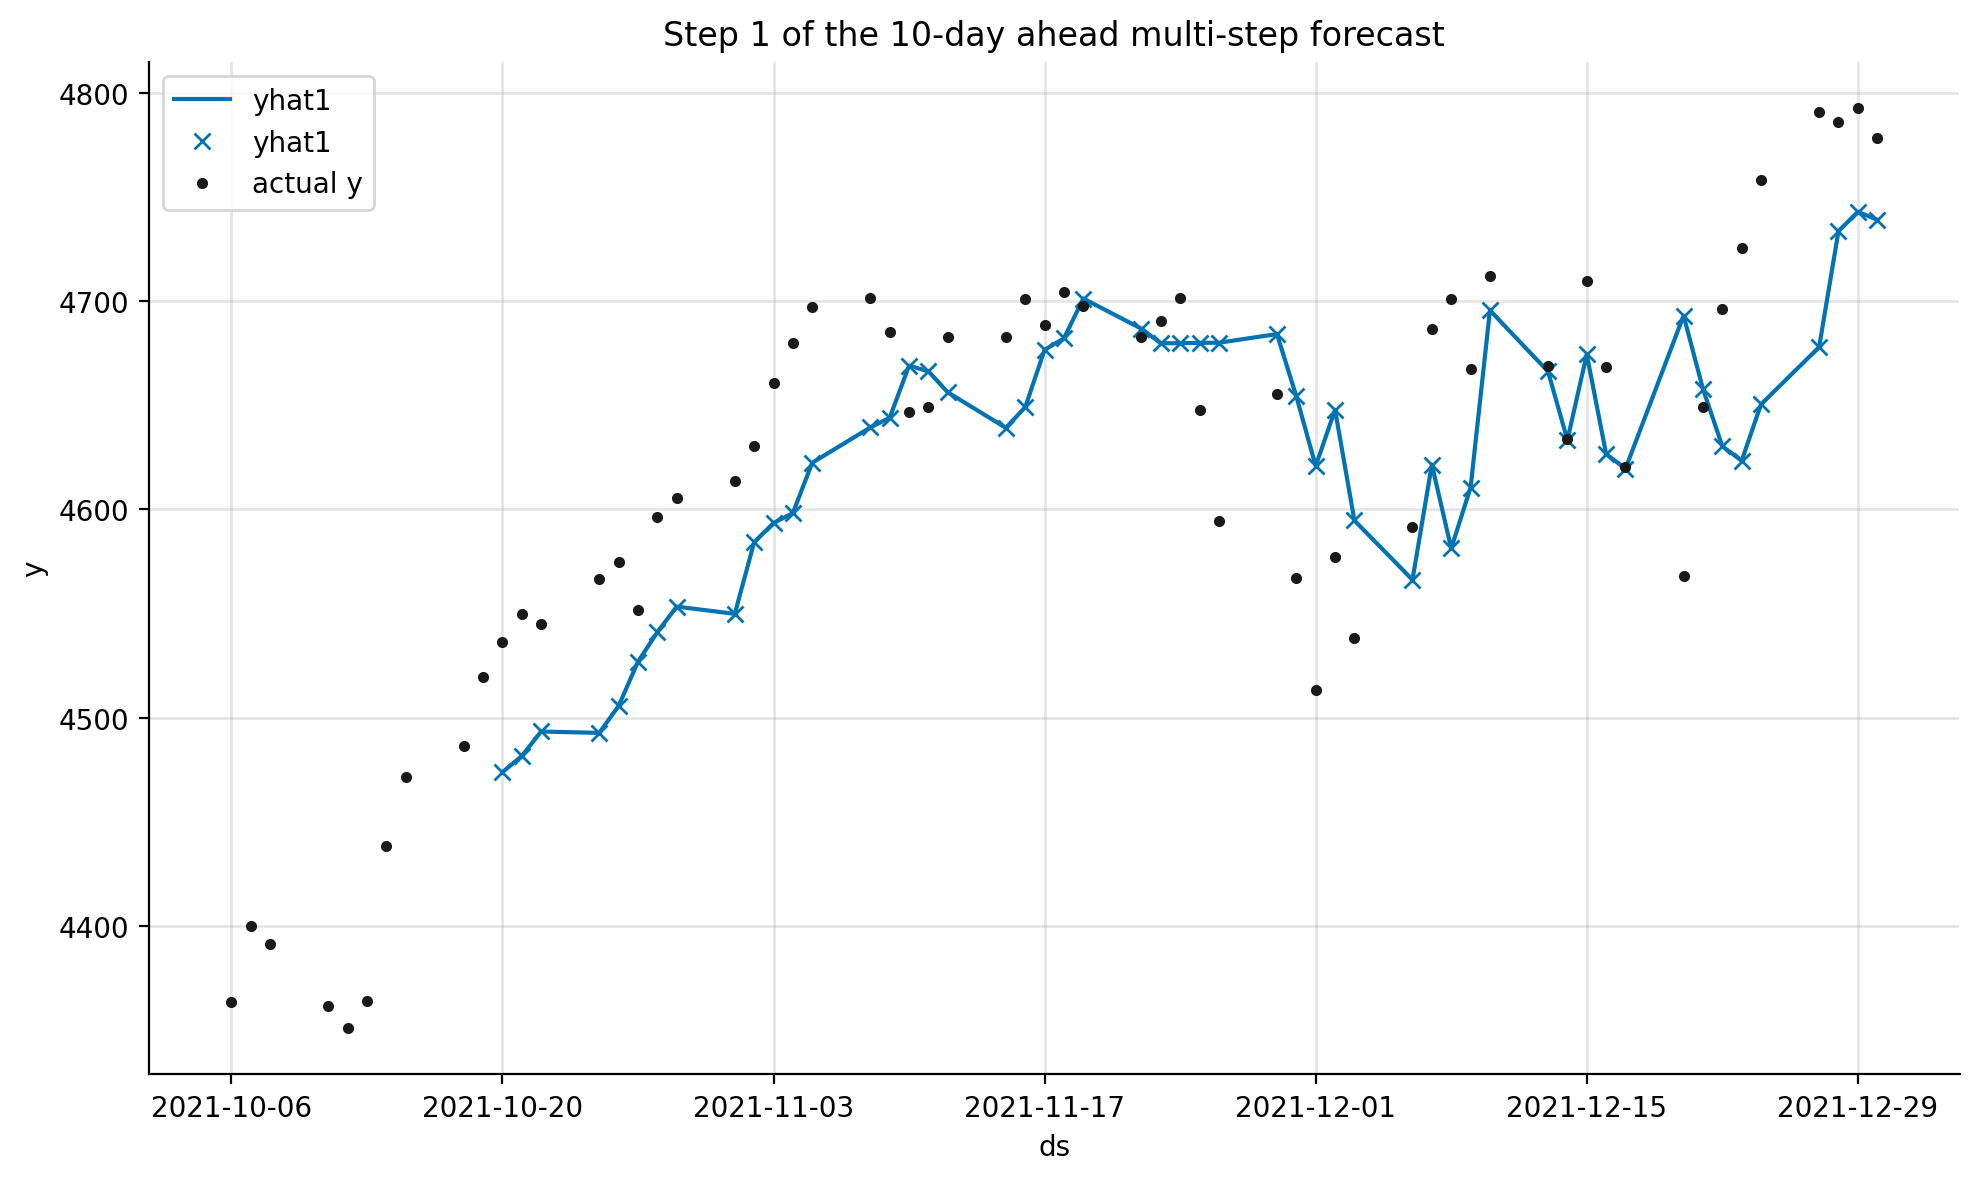

In [23]:
model = model.highlight_nth_step_ahead_of_each_forecast(1)
model.plot(pred_df)
ax = plt.gca()
ax.set_title("Step 1 of the 10-day ahead multi-step forecast")

plt.tight_layout()
sns.despine()
# plt.savefig("이미지/피규어_15_28")

### 성능 최적화 팁

데이터 전처리

이상치 처리
결측치 보간
적절한 변환 적용


모델 구성

AR 시차 최적화
변화점 수 조정
계절성 주기 설정


학습 최적화

배치 크기 조정
학습률 조정
정규화 강도 조절



### NeuralProphet vs Prophet
주요 차이점:

향상된 성능

AR 컴포넌트 추가
딥러닝 기반 구조
PyTorch 백엔드


유연성

커스텀 손실 함수
다양한 정규화 옵션
고급 학습 설정


확장성

GPU 지원
배치 처리
병렬 처리



### 활용 사례

금융 시계열

주가 예측
거래량 예측
변동성 예측


수요 예측

판매량 예측
트래픽 예측
리소스 사용량 예측


비즈니스 메트릭

KPI 예측
성과 지표 예측
트렌드 분석



NeuralProphet은 Prophet의 해석가능성을 유지하면서 딥러닝의 장점을 활용하여 더 정확한 예측을 제공할 수 있습니다. 특히 복잡한 패턴이 있는 시계열 데이터에서 효과적입니다.